# DAQL for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('BipedalWalker-v2')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [4]:
# state = env.reset()
# batch = []
# for _ in range(1111):
#     #env.render()
#     action = env.action_space.sample()
#     next_state, reward, done, _ = env.step(action) # take a random action
#     batch.append([state, action, next_state, reward, float(done)])
#     state = next_state
#     if done:
#         state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print('states:', np.max(np.array(states)), np.min(np.array(states)))
# print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

In [8]:
# env.action_space.high, env.action_space.low

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_shape], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_state')
    rewards = tf.placeholder(tf.float32, [None, state_size], name='rewards')
    return states, actions, next_states, rewards

In [10]:
# a = act(s, r)
def generator(states, rewards, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=state_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, rewards])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        pred = tf.tanh(logits)
        return pred

In [11]:
# s', Q = env(s, a)
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        next_states_logits = tf.layers.dense(inputs=nl2, units=state_size)        
        Qlogits = tf.layers.dense(inputs=next_states_logits, units=1, trainable=False)        
        return next_states_logits, Qlogits

In [12]:
def model_loss(action_size, hidden_size, state_size, rewards, states, actions, next_states):
    actions_pred = generator(states=states, rewards=rewards, hidden_size=hidden_size, state_size=state_size)
    _, gQs = discriminator(actions=actions_pred, states=states, hidden_size=hidden_size, action_size=action_size) 
    gloss = -tf.reduce_mean(gQs)
    next_states_pred, _ = discriminator(actions=actions, states=states, hidden_size=hidden_size, 
                                        action_size=action_size, reuse=True) 
    #dloss = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dloss = tf.reduce_mean(tf.reduce_sum(tf.square(next_states - next_states_pred), axis=1)) # DQN
#     print(dloss.shape, tf.square(next_states - next_states_pred).shape)
#     print(dloss.shape, tf.reduce_sum(tf.square(next_states - next_states_pred), axis=1).shape)
    return actions_pred, next_states_pred, gloss, dloss

In [13]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards = model_input(state_size=state_size, 
                                                                                action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_pred, self.next_states_pred, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, actions=self.actions, next_states=self.next_states, rewards=self.rewards) 
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, 
                                           d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [15]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [17]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size == one episode size is 1000/int(1e3) steps
gamma = 0.99                   # future reward discount

In [18]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [19]:
env.observation_space.high, env.observation_space.low, env.observation_space.shape, \
env.action_space.high, env.action_space.low, env.action_space.shape, \
env.reward_range, env.action_space,

(array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32),
 array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 (24,),
 array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32),
 (4,),
 (-inf, inf),
 Box(4,))

In [20]:
# print('states:', np.max(np.array(states)), np.min(np.array(states)))
# print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

In [21]:
# state = env.reset()
# total_reward = 0
# num_step = 0
# for each_step in range(memory_size):
#     action = env.action_space.sample() # randomness
#     action = np.clip(action, -1, 1) # clipped: [-1, +1]
#     next_state, reward, done, _ = env.step(action)
#     rate = -1 # success rate: [-1, +1]
#     memory.buffer.append([state, action, next_state, reward, float(done), rate])
#     num_step += 1 # memory updated
#     total_reward += reward # max reward 300
#     state = next_state
#     if done is True:
#         print('Progress:', each_step/memory_size)
#         state = env.reset()
#         # Best 100-episode average reward was 220.62 ± 0.69. 
#         # (BipedalWalker-v2 is considered "solved" 
#         #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
#         rate = total_reward/300
#         rate = np.clip(rate, -1, 1) 
#         total_reward = 0 # reset
#         for idx in range(num_step): # episode length
#             if memory.buffer[-1-idx][-1] == -1:
#                 memory.buffer[-1-idx][-1] = rate
#         num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
len(memory.buffer), memory.buffer.maxlen

(0, 100000)

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111111111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()
        state_ = np.zeros_like(state)

        # Training steps/batches
        while True:
            env.render()
            action_pred = sess.run(model.actions_pred, feed_dict={model.states: state.reshape([1, -1]),
                                                                  model.rewards: state_.reshape([1, -1])})
            noise = np.random.normal(loc=0, scale=0.1, size=action_size) # randomness
            action = action_pred.reshape([-1]) + noise
            #print(action.shape, action_logits.shape, noise.shape)
            action = np.clip(action, -1, 1) # clipped
            next_state, reward, done, _ = env.step(action)
            #rate = -1 # success rate: -1 to +1
            memory.buffer.append([state, state_, action, next_state])
            #num_step += 1 # memory updated
            total_reward += reward # max reward 300
            state = next_state
            next_state_pred = sess.run(model.next_states_pred, feed_dict={model.states: state.reshape([1, -1]),
                                                                          model.actions: action.reshape([1, -1])})
            state_ = next_state_pred.reshape([-1])
            #print(state.shape, state_.shape, action.shape, next_state.shape)
            #print(state.dtype, state_.dtype, action.dtype, next_state.dtype)
            
            # Training
            if len(memory.buffer) >= batch_size:
                #print('memory readyyyyyyyyyyyyyyyyyyyyy')
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                states_ = np.array([each[1] for each in batch])
                actions = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])
                #print(states.shape, states_.shape, actions.shape, next_states.shape)
                #print(states.dtype, states_.dtype, actions.dtype, next_states.dtype)
                #next_states_logits = sess.run(model.next_states_pred, feed_dict = {model.states: next_states})
                #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # discrete DQN
                #nextQs = nextQs_logits.reshape([-1]) * (1-dones) # continuous DPG
                #targetQs = rewards + (gamma * nextQs)
                gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.next_states: next_states, 
                                                           model.rewards: states_})
                gloss_batch.append(gloss)
                dloss_batch.append(dloss)
                
            if done is True:
                #print(len(memory.buffer))
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) >= 300:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode:0 meanR:-104.2189 R:-104.2189 gloss:nan dloss:nan
Episode:1 meanR:-100.7788 R:-97.3386 gloss:0.1648 dloss:7.9181
Episode:2 meanR:-105.1030 R:-113.7515 gloss:0.1819 dloss:6.5080
Episode:3 meanR:-108.7931 R:-119.8633 gloss:0.0597 dloss:5.9579
Episode:4 meanR:-110.4865 R:-117.2601 gloss:-0.0507 dloss:5.5967
Episode:5 meanR:-109.9707 R:-107.3916 gloss:-0.2122 dloss:5.2379
Episode:6 meanR:-111.2779 R:-119.1209 gloss:-0.4614 dloss:4.7171
Episode:7 meanR:-112.3893 R:-120.1692 gloss:-0.6625 dloss:4.2840
Episode:8 meanR:-113.5180 R:-122.5481 gloss:-0.8615 dloss:3.8792
Episode:9 meanR:-114.5333 R:-123.6707 gloss:-1.0473 dloss:3.5472
Episode:10 meanR:-115.3180 R:-123.1648 gloss:-1.2034 dloss:3.2204
Episode:11 meanR:-116.0288 R:-123.8482 gloss:-1.3070 dloss:2.9576
Episode:12 meanR:-116.6078 R:-123.5554 gloss:-1.3798 dloss:2.7167
Episode:13 meanR:-117.0793 R:-123.2090 gloss:-1.4311 dloss:2.5925
Episode:14 meanR:-117.4948 R:-123.3120 gloss:-1.4477 dloss:2.4740
Episode:15 meanR:-117.8626 R:-1

Episode:125 meanR:-122.4781 R:-122.7680 gloss:-1.3744 dloss:0.6333
Episode:126 meanR:-122.4690 R:-122.8009 gloss:-1.3563 dloss:0.6128
Episode:127 meanR:-122.4549 R:-121.8039 gloss:-1.3806 dloss:0.6377
Episode:128 meanR:-122.4462 R:-123.0636 gloss:-1.4036 dloss:0.6202
Episode:129 meanR:-122.4349 R:-122.5569 gloss:-1.3653 dloss:0.6265
Episode:130 meanR:-122.4330 R:-123.3635 gloss:-1.3886 dloss:0.6120
Episode:131 meanR:-122.4254 R:-122.7498 gloss:-1.3692 dloss:0.6226
Episode:132 meanR:-122.4058 R:-121.6450 gloss:-1.3775 dloss:0.6275
Episode:133 meanR:-122.3918 R:-122.0038 gloss:-1.3860 dloss:0.6253
Episode:134 meanR:-122.3740 R:-121.6090 gloss:-1.3818 dloss:0.5985
Episode:135 meanR:-122.3746 R:-123.4402 gloss:-1.3695 dloss:0.6139
Episode:136 meanR:-122.2537 R:-111.5420 gloss:-1.3708 dloss:0.5880
Episode:137 meanR:-122.2521 R:-123.4842 gloss:-1.3838 dloss:0.6002
Episode:138 meanR:-122.2505 R:-123.4922 gloss:-1.3814 dloss:0.5925
Episode:139 meanR:-122.2634 R:-124.5264 gloss:-1.3711 dloss:0.

Episode:248 meanR:-123.1010 R:-122.6611 gloss:-1.3673 dloss:0.4286
Episode:249 meanR:-123.1019 R:-122.8066 gloss:-1.3686 dloss:0.4130
Episode:250 meanR:-123.0942 R:-122.7005 gloss:-1.3639 dloss:0.4047
Episode:251 meanR:-123.0880 R:-122.6032 gloss:-1.3640 dloss:0.4017
Episode:252 meanR:-123.0792 R:-122.3437 gloss:-1.3545 dloss:0.4116
Episode:253 meanR:-123.0811 R:-123.1415 gloss:-1.3664 dloss:0.4265
Episode:254 meanR:-123.0806 R:-122.9821 gloss:-1.3654 dloss:0.4042
Episode:255 meanR:-123.0783 R:-122.7337 gloss:-1.3839 dloss:0.4079
Episode:256 meanR:-123.0975 R:-123.0489 gloss:-1.3637 dloss:0.3932
Episode:257 meanR:-123.1089 R:-123.3312 gloss:-1.3698 dloss:0.4205
Episode:258 meanR:-123.1265 R:-123.2485 gloss:-1.3676 dloss:0.3937
Episode:259 meanR:-123.1254 R:-122.9284 gloss:-1.3786 dloss:0.4046
Episode:260 meanR:-123.1263 R:-122.8213 gloss:-1.3720 dloss:0.4109
Episode:261 meanR:-123.1228 R:-123.3760 gloss:-1.3798 dloss:0.3873
Episode:262 meanR:-123.1182 R:-123.2493 gloss:-1.3626 dloss:0.

Episode:371 meanR:-122.0055 R:-120.3770 gloss:-1.2989 dloss:0.3699
Episode:372 meanR:-121.8103 R:-117.2338 gloss:-1.3083 dloss:0.3618
Episode:373 meanR:-121.6798 R:-119.9432 gloss:-1.2967 dloss:0.3675
Episode:374 meanR:-121.7035 R:-120.5873 gloss:-1.2974 dloss:0.3633
Episode:375 meanR:-121.7061 R:-120.2201 gloss:-1.3076 dloss:0.3631
Episode:376 meanR:-121.7648 R:-120.2570 gloss:-1.3033 dloss:0.3654
Episode:377 meanR:-121.6618 R:-120.5334 gloss:-1.3103 dloss:0.3540
Episode:378 meanR:-121.6725 R:-119.4101 gloss:-1.2973 dloss:0.3567
Episode:379 meanR:-121.5709 R:-119.5853 gloss:-1.2961 dloss:0.3514
Episode:380 meanR:-121.5857 R:-119.4313 gloss:-1.3010 dloss:0.3451
Episode:381 meanR:-121.3466 R:-121.6033 gloss:-1.3073 dloss:0.3475
Episode:382 meanR:-121.2270 R:-119.7161 gloss:-1.2986 dloss:0.3601
Episode:383 meanR:-121.0584 R:-119.3277 gloss:-1.2999 dloss:0.3539
Episode:384 meanR:-121.0746 R:-120.3623 gloss:-1.3084 dloss:0.3557
Episode:385 meanR:-121.0697 R:-114.1111 gloss:-1.3077 dloss:0.

Episode:494 meanR:-122.7151 R:-117.6559 gloss:-1.2127 dloss:0.3212
Episode:495 meanR:-122.5483 R:-117.7799 gloss:-1.2068 dloss:0.3153
Episode:496 meanR:-122.5614 R:-117.6650 gloss:-1.2122 dloss:0.3192
Episode:497 meanR:-122.5617 R:-115.1609 gloss:-1.2115 dloss:0.3212
Episode:498 meanR:-122.3972 R:-117.8323 gloss:-1.2079 dloss:0.3080
Episode:499 meanR:-122.2941 R:-119.0381 gloss:-1.2103 dloss:0.3153
Episode:500 meanR:-122.2599 R:-118.7319 gloss:-1.2107 dloss:0.3249
Episode:501 meanR:-122.2198 R:-118.1122 gloss:-1.2133 dloss:0.3159
Episode:502 meanR:-122.0961 R:-118.0651 gloss:-1.2038 dloss:0.3055
Episode:503 meanR:-122.1012 R:-117.9931 gloss:-1.2098 dloss:0.3205
Episode:504 meanR:-122.0111 R:-118.2317 gloss:-1.2028 dloss:0.3183
Episode:505 meanR:-121.8903 R:-115.0282 gloss:-1.2133 dloss:0.3141
Episode:506 meanR:-121.7736 R:-115.1155 gloss:-1.2159 dloss:0.3104
Episode:507 meanR:-121.6814 R:-118.0753 gloss:-1.2048 dloss:0.3085
Episode:508 meanR:-121.5944 R:-118.1539 gloss:-1.2095 dloss:0.

Episode:617 meanR:-121.9165 R:-126.1460 gloss:-1.1589 dloss:0.3002
Episode:618 meanR:-122.0005 R:-126.5586 gloss:-1.1648 dloss:0.3154
Episode:619 meanR:-122.0862 R:-126.6558 gloss:-1.1605 dloss:0.3104
Episode:620 meanR:-122.1951 R:-126.2842 gloss:-1.1572 dloss:0.3116
Episode:621 meanR:-122.2949 R:-126.0091 gloss:-1.1533 dloss:0.3080
Episode:622 meanR:-122.3985 R:-126.1024 gloss:-1.1513 dloss:0.3108
Episode:623 meanR:-122.5000 R:-125.8085 gloss:-1.1496 dloss:0.3041
Episode:624 meanR:-122.5770 R:-126.0242 gloss:-1.1536 dloss:0.3073
Episode:625 meanR:-122.6824 R:-126.3623 gloss:-1.1571 dloss:0.3041
Episode:626 meanR:-122.7560 R:-125.7466 gloss:-1.1560 dloss:0.2991
Episode:627 meanR:-122.8385 R:-126.6404 gloss:-1.1439 dloss:0.2976
Episode:628 meanR:-122.8993 R:-125.3364 gloss:-1.1473 dloss:0.3076
Episode:629 meanR:-123.0077 R:-126.2743 gloss:-1.1621 dloss:0.3082
Episode:630 meanR:-123.1105 R:-125.4260 gloss:-1.1424 dloss:0.3006
Episode:631 meanR:-123.1829 R:-125.4702 gloss:-1.1514 dloss:0.

Episode:740 meanR:-126.6485 R:-126.5744 gloss:-1.1042 dloss:0.2871
Episode:741 meanR:-126.6761 R:-127.8213 gloss:-1.1046 dloss:0.2905
Episode:742 meanR:-126.6858 R:-126.9934 gloss:-1.1051 dloss:0.2860
Episode:743 meanR:-126.6984 R:-127.3555 gloss:-1.1099 dloss:0.2900
Episode:744 meanR:-126.7090 R:-126.6567 gloss:-1.1103 dloss:0.2781
Episode:745 meanR:-126.7207 R:-127.2740 gloss:-1.1103 dloss:0.2857
Episode:746 meanR:-126.7345 R:-126.9955 gloss:-1.1004 dloss:0.2809
Episode:747 meanR:-126.7286 R:-125.6940 gloss:-1.1092 dloss:0.2856
Episode:748 meanR:-126.7393 R:-127.2979 gloss:-1.1041 dloss:0.2898
Episode:749 meanR:-126.7081 R:-125.6321 gloss:-1.1058 dloss:0.2780
Episode:750 meanR:-126.7065 R:-126.1381 gloss:-1.1057 dloss:0.2780
Episode:751 meanR:-126.7227 R:-127.1113 gloss:-1.1042 dloss:0.2905
Episode:752 meanR:-126.7094 R:-126.2118 gloss:-1.0989 dloss:0.2801
Episode:753 meanR:-126.7172 R:-126.5471 gloss:-1.1030 dloss:0.2868
Episode:754 meanR:-126.7042 R:-126.7411 gloss:-1.1078 dloss:0.

Episode:863 meanR:-126.8179 R:-126.8410 gloss:-1.0717 dloss:0.2654
Episode:864 meanR:-126.8117 R:-126.9493 gloss:-1.0676 dloss:0.2728
Episode:865 meanR:-126.8116 R:-126.8326 gloss:-1.0670 dloss:0.2689
Episode:866 meanR:-126.8233 R:-127.2105 gloss:-1.0716 dloss:0.2746
Episode:867 meanR:-126.8282 R:-126.6659 gloss:-1.0754 dloss:0.2671
Episode:868 meanR:-126.8285 R:-126.4286 gloss:-1.0673 dloss:0.2634
Episode:869 meanR:-126.8280 R:-126.8740 gloss:-1.0715 dloss:0.2648
Episode:870 meanR:-126.8368 R:-127.8822 gloss:-1.0668 dloss:0.2695
Episode:871 meanR:-126.8349 R:-126.8893 gloss:-1.0742 dloss:0.2651
Episode:872 meanR:-126.8221 R:-125.7970 gloss:-1.0704 dloss:0.2666
Episode:873 meanR:-126.8304 R:-127.1244 gloss:-1.0730 dloss:0.2584
Episode:874 meanR:-126.8411 R:-126.7583 gloss:-1.0756 dloss:0.2748
Episode:875 meanR:-126.8393 R:-126.4274 gloss:-1.0733 dloss:0.2652
Episode:876 meanR:-126.8417 R:-126.4073 gloss:-1.0799 dloss:0.2688
Episode:877 meanR:-126.8274 R:-125.9589 gloss:-1.0757 dloss:0.

Episode:986 meanR:-126.7922 R:-127.0595 gloss:-1.0448 dloss:0.2584
Episode:987 meanR:-126.7908 R:-126.9355 gloss:-1.0416 dloss:0.2490
Episode:988 meanR:-126.7967 R:-127.0794 gloss:-1.0470 dloss:0.2526
Episode:989 meanR:-126.8054 R:-127.1003 gloss:-1.0478 dloss:0.2548
Episode:990 meanR:-126.8131 R:-127.6348 gloss:-1.0383 dloss:0.2457
Episode:991 meanR:-126.8256 R:-127.1826 gloss:-1.0384 dloss:0.2609
Episode:992 meanR:-126.8192 R:-125.5119 gloss:-1.0392 dloss:0.2611
Episode:993 meanR:-126.8277 R:-127.3334 gloss:-1.0428 dloss:0.2567
Episode:994 meanR:-126.8357 R:-127.8069 gloss:-1.0454 dloss:0.2523
Episode:995 meanR:-126.8434 R:-127.1671 gloss:-1.0452 dloss:0.2536
Episode:996 meanR:-126.8540 R:-127.3987 gloss:-1.0487 dloss:0.2550
Episode:997 meanR:-126.8685 R:-127.7946 gloss:-1.0481 dloss:0.2619
Episode:998 meanR:-126.8532 R:-125.6978 gloss:-1.0557 dloss:0.2578
Episode:999 meanR:-126.8508 R:-126.5787 gloss:-1.0388 dloss:0.2611
Episode:1000 meanR:-126.8590 R:-127.6720 gloss:-1.0474 dloss:0

Episode:1107 meanR:-126.8000 R:-127.1113 gloss:-1.0311 dloss:0.2511
Episode:1108 meanR:-126.8150 R:-127.7180 gloss:-1.0288 dloss:0.2464
Episode:1109 meanR:-126.8220 R:-127.3606 gloss:-1.0214 dloss:0.2457
Episode:1110 meanR:-126.8143 R:-127.2165 gloss:-1.0221 dloss:0.2535
Episode:1111 meanR:-126.8149 R:-126.5167 gloss:-1.0312 dloss:0.2408
Episode:1112 meanR:-126.8227 R:-127.3540 gloss:-1.0286 dloss:0.2471
Episode:1113 meanR:-126.8175 R:-126.9368 gloss:-1.0261 dloss:0.2473
Episode:1114 meanR:-126.8260 R:-127.6394 gloss:-1.0287 dloss:0.2474
Episode:1115 meanR:-126.8404 R:-127.4552 gloss:-1.0295 dloss:0.2526
Episode:1116 meanR:-126.8477 R:-127.3481 gloss:-1.0253 dloss:0.2425
Episode:1117 meanR:-126.8623 R:-127.6983 gloss:-1.0224 dloss:0.2439
Episode:1118 meanR:-126.8617 R:-127.2842 gloss:-1.0272 dloss:0.2468
Episode:1119 meanR:-126.8689 R:-126.8156 gloss:-1.0250 dloss:0.2477
Episode:1120 meanR:-126.8545 R:-125.1262 gloss:-1.0237 dloss:0.2461
Episode:1121 meanR:-126.8386 R:-126.4364 gloss:-

Episode:1228 meanR:-125.6366 R:-125.5795 gloss:-1.0097 dloss:0.2421
Episode:1229 meanR:-125.6117 R:-125.9254 gloss:-1.0079 dloss:0.2465
Episode:1230 meanR:-125.5904 R:-125.3471 gloss:-1.0119 dloss:0.2474
Episode:1231 meanR:-125.5739 R:-124.5489 gloss:-1.0151 dloss:0.2451
Episode:1232 meanR:-125.5371 R:-122.9995 gloss:-1.0037 dloss:0.2465
Episode:1233 meanR:-125.5451 R:-126.0862 gloss:-1.0071 dloss:0.2456
Episode:1234 meanR:-125.5396 R:-125.8347 gloss:-1.0118 dloss:0.2438
Episode:1235 meanR:-125.5241 R:-123.9900 gloss:-1.0044 dloss:0.2431
Episode:1236 meanR:-125.5351 R:-126.5015 gloss:-1.0148 dloss:0.2469
Episode:1237 meanR:-125.5238 R:-124.2550 gloss:-1.0146 dloss:0.2407
Episode:1238 meanR:-125.5224 R:-125.0476 gloss:-1.0052 dloss:0.2507
Episode:1239 meanR:-125.5352 R:-126.5977 gloss:-1.0075 dloss:0.2441
Episode:1240 meanR:-125.5396 R:-126.2192 gloss:-1.0132 dloss:0.2507
Episode:1241 meanR:-125.5422 R:-125.6144 gloss:-1.0077 dloss:0.2359
Episode:1242 meanR:-125.5352 R:-124.6316 gloss:-

Episode:1349 meanR:-125.4968 R:-125.2419 gloss:-0.9591 dloss:0.2354
Episode:1350 meanR:-125.4979 R:-125.3273 gloss:-0.9661 dloss:0.2218
Episode:1351 meanR:-125.4907 R:-124.7677 gloss:-0.9599 dloss:0.2349
Episode:1352 meanR:-125.4873 R:-125.3299 gloss:-0.9640 dloss:0.2328
Episode:1353 meanR:-125.4968 R:-125.8222 gloss:-0.9570 dloss:0.2327
Episode:1354 meanR:-125.4880 R:-125.2217 gloss:-0.9630 dloss:0.2287
Episode:1355 meanR:-125.5029 R:-126.5014 gloss:-0.9586 dloss:0.2354
Episode:1356 meanR:-125.5150 R:-126.4938 gloss:-0.9648 dloss:0.2314
Episode:1357 meanR:-125.5222 R:-126.6105 gloss:-0.9635 dloss:0.2350
Episode:1358 meanR:-125.5330 R:-126.0390 gloss:-0.9593 dloss:0.2381
Episode:1359 meanR:-125.5428 R:-126.4965 gloss:-0.9564 dloss:0.2217
Episode:1360 meanR:-125.5557 R:-126.5589 gloss:-0.9615 dloss:0.2236
Episode:1361 meanR:-125.5451 R:-125.0332 gloss:-0.9573 dloss:0.2221
Episode:1362 meanR:-125.5454 R:-125.6528 gloss:-0.9562 dloss:0.2297
Episode:1363 meanR:-125.5526 R:-125.7667 gloss:-

Episode:1470 meanR:-126.2009 R:-127.1626 gloss:-0.9050 dloss:0.2201
Episode:1471 meanR:-126.2059 R:-126.7183 gloss:-0.9061 dloss:0.2240
Episode:1472 meanR:-126.2231 R:-127.3678 gloss:-0.9075 dloss:0.2260
Episode:1473 meanR:-126.2254 R:-126.0284 gloss:-0.9021 dloss:0.2223
Episode:1474 meanR:-126.1930 R:-122.5788 gloss:-0.9069 dloss:0.2190
Episode:1475 meanR:-126.1695 R:-122.6231 gloss:-0.9029 dloss:0.2236
Episode:1476 meanR:-126.1024 R:-119.1294 gloss:-0.9077 dloss:0.2216
Episode:1477 meanR:-126.0941 R:-124.2061 gloss:-0.9056 dloss:0.2283
Episode:1478 meanR:-126.1085 R:-127.1739 gloss:-0.9091 dloss:0.2189
Episode:1479 meanR:-126.1094 R:-125.5427 gloss:-0.9094 dloss:0.2226
Episode:1480 meanR:-126.1481 R:-128.9935 gloss:-0.8993 dloss:0.2206
Episode:1481 meanR:-126.1374 R:-125.7964 gloss:-0.9025 dloss:0.2230
Episode:1482 meanR:-126.0729 R:-119.7486 gloss:-0.8991 dloss:0.2157
Episode:1483 meanR:-126.0467 R:-122.6920 gloss:-0.9050 dloss:0.2240
Episode:1484 meanR:-126.0291 R:-123.3367 gloss:-

Episode:1591 meanR:-126.8505 R:-127.4466 gloss:-0.8699 dloss:0.2056
Episode:1592 meanR:-126.8673 R:-127.4163 gloss:-0.8739 dloss:0.2091
Episode:1593 meanR:-126.8607 R:-125.8119 gloss:-0.8751 dloss:0.2068
Episode:1594 meanR:-126.8553 R:-125.7379 gloss:-0.8699 dloss:0.2035
Episode:1595 meanR:-126.8462 R:-126.3882 gloss:-0.8734 dloss:0.2056
Episode:1596 meanR:-126.8477 R:-126.4912 gloss:-0.8718 dloss:0.2006
Episode:1597 meanR:-126.8481 R:-126.4805 gloss:-0.8717 dloss:0.2081
Episode:1598 meanR:-126.8664 R:-128.4656 gloss:-0.8711 dloss:0.2074
Episode:1599 meanR:-126.8696 R:-126.5360 gloss:-0.8719 dloss:0.2038
Episode:1600 meanR:-126.8714 R:-126.7466 gloss:-0.8689 dloss:0.2045
Episode:1601 meanR:-126.8816 R:-127.3247 gloss:-0.8746 dloss:0.2036
Episode:1602 meanR:-126.8851 R:-127.0495 gloss:-0.8678 dloss:0.2018
Episode:1603 meanR:-126.8812 R:-126.9195 gloss:-0.8725 dloss:0.2003
Episode:1604 meanR:-126.9038 R:-127.7359 gloss:-0.8740 dloss:0.2056
Episode:1605 meanR:-126.8757 R:-125.0878 gloss:-

Episode:1712 meanR:-123.6551 R:-127.4544 gloss:-0.8752 dloss:0.2027
Episode:1713 meanR:-123.6506 R:-126.4759 gloss:-0.8781 dloss:0.2090
Episode:1714 meanR:-123.5434 R:-115.8328 gloss:-0.8798 dloss:0.2116
Episode:1715 meanR:-123.4951 R:-122.2513 gloss:-0.8764 dloss:0.2044
Episode:1716 meanR:-123.4628 R:-124.2042 gloss:-0.8788 dloss:0.2064
Episode:1717 meanR:-123.4085 R:-121.9766 gloss:-0.8784 dloss:0.2127
Episode:1718 meanR:-123.3284 R:-119.6720 gloss:-0.8743 dloss:0.2079
Episode:1719 meanR:-123.2441 R:-117.6502 gloss:-0.8764 dloss:0.2122
Episode:1720 meanR:-123.2444 R:-126.9960 gloss:-0.8790 dloss:0.2015
Episode:1721 meanR:-123.1349 R:-116.0578 gloss:-0.8823 dloss:0.2075
Episode:1722 meanR:-123.0797 R:-114.1832 gloss:-0.8837 dloss:0.2024
Episode:1723 meanR:-122.9693 R:-116.4083 gloss:-0.8805 dloss:0.2132
Episode:1724 meanR:-123.0130 R:-131.4136 gloss:-0.8825 dloss:0.2127
Episode:1725 meanR:-122.8996 R:-118.7729 gloss:-0.8842 dloss:0.2108
Episode:1726 meanR:-122.8408 R:-123.8525 gloss:-

Episode:1833 meanR:-119.6679 R:-121.0830 gloss:-0.8866 dloss:0.2028
Episode:1834 meanR:-119.6977 R:-119.3347 gloss:-0.8868 dloss:0.2052
Episode:1835 meanR:-119.7471 R:-120.4919 gloss:-0.8874 dloss:0.2107
Episode:1836 meanR:-119.7762 R:-118.7953 gloss:-0.8852 dloss:0.2067
Episode:1837 meanR:-119.8455 R:-124.4310 gloss:-0.8842 dloss:0.2161
Episode:1838 meanR:-119.8637 R:-119.6352 gloss:-0.8858 dloss:0.2096
Episode:1839 meanR:-119.9128 R:-120.6125 gloss:-0.8862 dloss:0.2077
Episode:1840 meanR:-119.8245 R:-118.3322 gloss:-0.8872 dloss:0.2158
Episode:1841 meanR:-119.8068 R:-118.3207 gloss:-0.8848 dloss:0.2102
Episode:1842 meanR:-119.7351 R:-120.7566 gloss:-0.8852 dloss:0.2104
Episode:1843 meanR:-119.6421 R:-108.5190 gloss:-0.8877 dloss:0.2127
Episode:1844 meanR:-119.6431 R:-120.2330 gloss:-0.8891 dloss:0.2233
Episode:1845 meanR:-119.6934 R:-125.9481 gloss:-0.8871 dloss:0.2105
Episode:1846 meanR:-119.6632 R:-120.1023 gloss:-0.8821 dloss:0.2118
Episode:1847 meanR:-119.6176 R:-118.3144 gloss:-

Episode:1954 meanR:-120.2201 R:-118.9403 gloss:-0.8829 dloss:0.2130
Episode:1955 meanR:-120.2514 R:-121.5593 gloss:-0.8812 dloss:0.2191
Episode:1956 meanR:-120.2135 R:-118.6548 gloss:-0.8828 dloss:0.2167
Episode:1957 meanR:-120.1560 R:-117.2546 gloss:-0.8816 dloss:0.2189
Episode:1958 meanR:-120.2549 R:-118.8490 gloss:-0.8799 dloss:0.2192
Episode:1959 meanR:-120.3574 R:-128.5666 gloss:-0.8842 dloss:0.2162
Episode:1960 meanR:-120.4660 R:-127.3850 gloss:-0.8846 dloss:0.2190
Episode:1961 meanR:-120.5146 R:-124.0307 gloss:-0.8835 dloss:0.2172
Episode:1962 meanR:-120.5045 R:-118.2727 gloss:-0.8861 dloss:0.2136
Episode:1963 meanR:-120.4987 R:-117.6636 gloss:-0.8816 dloss:0.2173
Episode:1964 meanR:-120.4606 R:-117.5096 gloss:-0.8761 dloss:0.2183
Episode:1965 meanR:-120.4709 R:-118.6792 gloss:-0.8826 dloss:0.2170
Episode:1966 meanR:-120.5615 R:-125.5425 gloss:-0.8836 dloss:0.2124
Episode:1967 meanR:-120.6645 R:-127.7444 gloss:-0.8812 dloss:0.2106
Episode:1968 meanR:-120.7451 R:-128.2674 gloss:-

Episode:2075 meanR:-119.2284 R:-118.2673 gloss:-0.8837 dloss:0.2195
Episode:2076 meanR:-119.1777 R:-120.6848 gloss:-0.8838 dloss:0.2200
Episode:2077 meanR:-119.1588 R:-116.8660 gloss:-0.8848 dloss:0.2210
Episode:2078 meanR:-119.1849 R:-117.5860 gloss:-0.8800 dloss:0.2185
Episode:2079 meanR:-119.2438 R:-118.1605 gloss:-0.8813 dloss:0.2243
Episode:2080 meanR:-119.2179 R:-116.0629 gloss:-0.8804 dloss:0.2200
Episode:2081 meanR:-119.2207 R:-118.8273 gloss:-0.8807 dloss:0.2244
Episode:2082 meanR:-119.2294 R:-118.8523 gloss:-0.8806 dloss:0.2259
Episode:2083 meanR:-119.1305 R:-116.2963 gloss:-0.8778 dloss:0.2347
Episode:2084 meanR:-119.1488 R:-120.3411 gloss:-0.8831 dloss:0.2227
Episode:2085 meanR:-119.1325 R:-116.4473 gloss:-0.8824 dloss:0.2306
Episode:2086 meanR:-119.0940 R:-116.2302 gloss:-0.8787 dloss:0.2189
Episode:2087 meanR:-118.9842 R:-116.1411 gloss:-0.8790 dloss:0.2250
Episode:2088 meanR:-118.9523 R:-114.0920 gloss:-0.8829 dloss:0.2231
Episode:2089 meanR:-118.8912 R:-117.3713 gloss:-

Episode:2196 meanR:-116.7183 R:-114.9339 gloss:-0.8772 dloss:0.2157
Episode:2197 meanR:-116.7181 R:-116.0093 gloss:-0.8768 dloss:0.2172
Episode:2198 meanR:-116.7052 R:-120.1887 gloss:-0.8820 dloss:0.2330
Episode:2199 meanR:-116.6861 R:-115.9609 gloss:-0.8835 dloss:0.2339
Episode:2200 meanR:-116.7072 R:-118.4355 gloss:-0.8769 dloss:0.2288
Episode:2201 meanR:-116.6880 R:-114.2005 gloss:-0.8836 dloss:0.2210
Episode:2202 meanR:-116.6718 R:-114.5179 gloss:-0.8744 dloss:0.2196
Episode:2203 meanR:-116.6750 R:-116.6114 gloss:-0.8757 dloss:0.2271
Episode:2204 meanR:-116.6572 R:-115.0763 gloss:-0.8837 dloss:0.2248
Episode:2205 meanR:-116.6522 R:-114.9761 gloss:-0.8755 dloss:0.2213
Episode:2206 meanR:-116.6390 R:-114.9370 gloss:-0.8752 dloss:0.2278
Episode:2207 meanR:-116.6330 R:-115.2242 gloss:-0.8757 dloss:0.2204
Episode:2208 meanR:-116.6067 R:-114.2166 gloss:-0.8809 dloss:0.2201
Episode:2209 meanR:-116.5990 R:-116.5916 gloss:-0.8774 dloss:0.2202
Episode:2210 meanR:-116.5894 R:-114.7688 gloss:-

Episode:2317 meanR:-116.5764 R:-121.6755 gloss:-0.8739 dloss:0.2202
Episode:2318 meanR:-116.5331 R:-116.2519 gloss:-0.8771 dloss:0.2199
Episode:2319 meanR:-116.5263 R:-119.2823 gloss:-0.8762 dloss:0.2271
Episode:2320 meanR:-116.5681 R:-118.6145 gloss:-0.8755 dloss:0.2194
Episode:2321 meanR:-116.5367 R:-116.4684 gloss:-0.8732 dloss:0.2195
Episode:2322 meanR:-116.5657 R:-117.4650 gloss:-0.8782 dloss:0.2227
Episode:2323 meanR:-116.5150 R:-115.5646 gloss:-0.8809 dloss:0.2255
Episode:2324 meanR:-116.5001 R:-116.2127 gloss:-0.8752 dloss:0.2184
Episode:2325 meanR:-116.5100 R:-114.7167 gloss:-0.8755 dloss:0.2207
Episode:2326 meanR:-116.5301 R:-116.0551 gloss:-0.8783 dloss:0.2212
Episode:2327 meanR:-116.5378 R:-115.7375 gloss:-0.8749 dloss:0.2212
Episode:2328 meanR:-116.4828 R:-114.7117 gloss:-0.8797 dloss:0.2157
Episode:2329 meanR:-116.5419 R:-120.8883 gloss:-0.8747 dloss:0.2276
Episode:2330 meanR:-116.5522 R:-115.9558 gloss:-0.8725 dloss:0.2111
Episode:2331 meanR:-116.5648 R:-116.0937 gloss:-

Episode:2438 meanR:-116.8809 R:-116.3369 gloss:-0.8787 dloss:0.2162
Episode:2439 meanR:-116.8283 R:-115.9466 gloss:-0.8773 dloss:0.2107
Episode:2440 meanR:-116.7725 R:-114.4705 gloss:-0.8762 dloss:0.2208
Episode:2441 meanR:-116.7323 R:-116.5220 gloss:-0.8731 dloss:0.2195
Episode:2442 meanR:-116.7470 R:-115.6198 gloss:-0.8765 dloss:0.2220
Episode:2443 meanR:-116.7282 R:-115.3527 gloss:-0.8806 dloss:0.2201
Episode:2444 meanR:-116.7052 R:-115.0757 gloss:-0.8716 dloss:0.2114
Episode:2445 meanR:-116.7196 R:-117.1895 gloss:-0.8812 dloss:0.2189
Episode:2446 meanR:-116.6992 R:-114.6880 gloss:-0.8779 dloss:0.2156
Episode:2447 meanR:-116.6848 R:-120.3601 gloss:-0.8793 dloss:0.2209
Episode:2448 meanR:-116.6979 R:-114.9769 gloss:-0.8776 dloss:0.2214
Episode:2449 meanR:-116.7087 R:-115.9767 gloss:-0.8729 dloss:0.2201
Episode:2450 meanR:-116.6996 R:-114.1650 gloss:-0.8786 dloss:0.2167
Episode:2451 meanR:-116.6548 R:-114.7249 gloss:-0.8806 dloss:0.2139
Episode:2452 meanR:-116.5937 R:-114.4384 gloss:-

Episode:2559 meanR:-116.6079 R:-116.7251 gloss:-0.8806 dloss:0.2082
Episode:2560 meanR:-116.5878 R:-114.2039 gloss:-0.8821 dloss:0.2081
Episode:2561 meanR:-116.5596 R:-117.3190 gloss:-0.8795 dloss:0.2095
Episode:2562 meanR:-116.5711 R:-115.9620 gloss:-0.8825 dloss:0.2209
Episode:2563 meanR:-116.5502 R:-114.8092 gloss:-0.8780 dloss:0.2158
Episode:2564 meanR:-116.5716 R:-116.2689 gloss:-0.8805 dloss:0.2173
Episode:2565 meanR:-116.5586 R:-114.4861 gloss:-0.8771 dloss:0.2056
Episode:2566 meanR:-116.5334 R:-114.8355 gloss:-0.8818 dloss:0.2261
Episode:2567 meanR:-116.5353 R:-115.0978 gloss:-0.8796 dloss:0.2172
Episode:2568 meanR:-116.5204 R:-115.0753 gloss:-0.8829 dloss:0.2136
Episode:2569 meanR:-116.4618 R:-115.2816 gloss:-0.8797 dloss:0.2138
Episode:2570 meanR:-116.4889 R:-117.2093 gloss:-0.8771 dloss:0.2052
Episode:2571 meanR:-116.4457 R:-114.9778 gloss:-0.8792 dloss:0.2160
Episode:2572 meanR:-116.4408 R:-116.2051 gloss:-0.8791 dloss:0.2128
Episode:2573 meanR:-116.4390 R:-116.8979 gloss:-

Episode:2680 meanR:-116.4261 R:-116.9399 gloss:-0.8840 dloss:0.2049
Episode:2681 meanR:-116.4339 R:-116.9506 gloss:-0.8814 dloss:0.2094
Episode:2682 meanR:-116.4546 R:-117.7311 gloss:-0.8849 dloss:0.2087
Episode:2683 meanR:-116.4683 R:-117.4933 gloss:-0.8806 dloss:0.2204
Episode:2684 meanR:-116.4452 R:-114.8280 gloss:-0.8825 dloss:0.2119
Episode:2685 meanR:-116.4568 R:-116.3226 gloss:-0.8803 dloss:0.2029
Episode:2686 meanR:-116.4444 R:-116.8200 gloss:-0.8814 dloss:0.2083
Episode:2687 meanR:-116.3807 R:-114.1280 gloss:-0.8837 dloss:0.2091
Episode:2688 meanR:-116.3541 R:-114.5625 gloss:-0.8843 dloss:0.2102
Episode:2689 meanR:-116.3575 R:-116.5831 gloss:-0.8873 dloss:0.2047
Episode:2690 meanR:-116.3927 R:-119.7005 gloss:-0.8795 dloss:0.2036
Episode:2691 meanR:-116.4428 R:-119.6987 gloss:-0.8859 dloss:0.2129
Episode:2692 meanR:-116.4447 R:-116.4680 gloss:-0.8833 dloss:0.2108
Episode:2693 meanR:-116.4318 R:-115.1562 gloss:-0.8800 dloss:0.2001
Episode:2694 meanR:-116.4874 R:-121.4490 gloss:-

Episode:2801 meanR:-116.1143 R:-114.4977 gloss:-0.8840 dloss:0.2128
Episode:2802 meanR:-116.1194 R:-114.7311 gloss:-0.8879 dloss:0.2083
Episode:2803 meanR:-116.1130 R:-114.3344 gloss:-0.8871 dloss:0.1977
Episode:2804 meanR:-116.1018 R:-114.9099 gloss:-0.8898 dloss:0.2135
Episode:2805 meanR:-116.0969 R:-114.0873 gloss:-0.8842 dloss:0.1962
Episode:2806 meanR:-116.1434 R:-120.1628 gloss:-0.8865 dloss:0.2049
Episode:2807 meanR:-116.1724 R:-117.1302 gloss:-0.8864 dloss:0.2033
Episode:2808 meanR:-116.1446 R:-113.9076 gloss:-0.8905 dloss:0.2118
Episode:2809 meanR:-116.1259 R:-115.6415 gloss:-0.8853 dloss:0.1988
Episode:2810 meanR:-116.1534 R:-120.3641 gloss:-0.8876 dloss:0.2041
Episode:2811 meanR:-116.1566 R:-116.8425 gloss:-0.8884 dloss:0.2013
Episode:2812 meanR:-116.1366 R:-114.2357 gloss:-0.8877 dloss:0.1974
Episode:2813 meanR:-116.1297 R:-114.1906 gloss:-0.8853 dloss:0.2004
Episode:2814 meanR:-116.1509 R:-118.7660 gloss:-0.8852 dloss:0.1961
Episode:2815 meanR:-116.1776 R:-117.4612 gloss:-

Episode:2922 meanR:-116.4482 R:-114.6175 gloss:-0.8861 dloss:0.1973
Episode:2923 meanR:-116.4409 R:-113.8093 gloss:-0.8878 dloss:0.1917
Episode:2924 meanR:-116.4753 R:-117.2284 gloss:-0.8945 dloss:0.1913
Episode:2925 meanR:-116.4848 R:-115.5945 gloss:-0.8891 dloss:0.1956
Episode:2926 meanR:-116.4261 R:-113.9066 gloss:-0.8846 dloss:0.1897
Episode:2927 meanR:-116.4580 R:-117.9043 gloss:-0.8899 dloss:0.2029
Episode:2928 meanR:-116.4138 R:-114.4704 gloss:-0.8878 dloss:0.1958
Episode:2929 meanR:-116.4298 R:-116.6834 gloss:-0.8909 dloss:0.1994
Episode:2930 meanR:-116.4440 R:-119.5154 gloss:-0.8907 dloss:0.1998
Episode:2931 meanR:-116.5201 R:-121.7968 gloss:-0.8894 dloss:0.2024
Episode:2932 meanR:-116.4595 R:-114.1354 gloss:-0.8895 dloss:0.2030
Episode:2933 meanR:-116.4111 R:-115.3328 gloss:-0.8922 dloss:0.1918
Episode:2934 meanR:-116.3970 R:-113.8009 gloss:-0.8893 dloss:0.1995
Episode:2935 meanR:-116.4097 R:-119.5659 gloss:-0.8920 dloss:0.2016
Episode:2936 meanR:-116.3887 R:-114.8750 gloss:-

Episode:3043 meanR:-116.4040 R:-118.1762 gloss:-0.8844 dloss:0.1885
Episode:3044 meanR:-116.4568 R:-120.0002 gloss:-0.8872 dloss:0.1913
Episode:3045 meanR:-116.4510 R:-115.1944 gloss:-0.8878 dloss:0.1918
Episode:3046 meanR:-116.5146 R:-120.6100 gloss:-0.8813 dloss:0.1817
Episode:3047 meanR:-116.5204 R:-114.7660 gloss:-0.8905 dloss:0.1911
Episode:3048 meanR:-116.5367 R:-116.2999 gloss:-0.8840 dloss:0.1880
Episode:3049 meanR:-116.5310 R:-114.2742 gloss:-0.8888 dloss:0.1923
Episode:3050 meanR:-116.5839 R:-120.4328 gloss:-0.8879 dloss:0.1905
Episode:3051 meanR:-116.6160 R:-117.4010 gloss:-0.8893 dloss:0.1957
Episode:3052 meanR:-116.6196 R:-118.0175 gloss:-0.8846 dloss:0.1857
Episode:3053 meanR:-116.5608 R:-113.9282 gloss:-0.8888 dloss:0.1909
Episode:3054 meanR:-116.5604 R:-114.5226 gloss:-0.8898 dloss:0.1899
Episode:3055 meanR:-116.5600 R:-116.9058 gloss:-0.8878 dloss:0.1964
Episode:3056 meanR:-116.5559 R:-114.5894 gloss:-0.8857 dloss:0.1910
Episode:3057 meanR:-116.6080 R:-120.3219 gloss:-

Episode:3164 meanR:-117.0042 R:-115.7851 gloss:-0.8822 dloss:0.1845
Episode:3165 meanR:-116.9974 R:-114.3396 gloss:-0.8855 dloss:0.1912
Episode:3166 meanR:-116.9534 R:-115.4917 gloss:-0.8827 dloss:0.1864
Episode:3167 meanR:-116.9074 R:-115.0277 gloss:-0.8841 dloss:0.1878
Episode:3168 meanR:-116.9569 R:-119.9729 gloss:-0.8813 dloss:0.1765
Episode:3169 meanR:-116.9778 R:-119.5055 gloss:-0.8851 dloss:0.1805
Episode:3170 meanR:-116.9839 R:-119.8656 gloss:-0.8805 dloss:0.1890
Episode:3171 meanR:-116.9768 R:-114.8451 gloss:-0.8853 dloss:0.1846
Episode:3172 meanR:-116.9936 R:-116.3153 gloss:-0.8835 dloss:0.1861
Episode:3173 meanR:-116.9886 R:-115.0317 gloss:-0.8790 dloss:0.1831
Episode:3174 meanR:-117.0441 R:-120.1664 gloss:-0.8868 dloss:0.1859
Episode:3175 meanR:-116.9907 R:-114.2265 gloss:-0.8790 dloss:0.1825
Episode:3176 meanR:-116.9883 R:-114.8081 gloss:-0.8794 dloss:0.1799
Episode:3177 meanR:-116.9849 R:-113.9050 gloss:-0.8815 dloss:0.1892
Episode:3178 meanR:-116.9681 R:-114.5371 gloss:-

Episode:3285 meanR:-117.5483 R:-120.7669 gloss:-0.8790 dloss:0.1775
Episode:3286 meanR:-117.5681 R:-115.8322 gloss:-0.8774 dloss:0.1829
Episode:3287 meanR:-117.5783 R:-120.6200 gloss:-0.8826 dloss:0.1800
Episode:3288 meanR:-117.5487 R:-117.1910 gloss:-0.8778 dloss:0.1762
Episode:3289 meanR:-117.5830 R:-118.4279 gloss:-0.8777 dloss:0.1804
Episode:3290 meanR:-117.5384 R:-114.6634 gloss:-0.8837 dloss:0.1834
Episode:3291 meanR:-117.5330 R:-118.6993 gloss:-0.8776 dloss:0.1804
Episode:3292 meanR:-117.5388 R:-120.8883 gloss:-0.8788 dloss:0.1788
Episode:3293 meanR:-117.5529 R:-121.1852 gloss:-0.8794 dloss:0.1737
Episode:3294 meanR:-117.5696 R:-120.8856 gloss:-0.8783 dloss:0.1810
Episode:3295 meanR:-117.5915 R:-117.8325 gloss:-0.8773 dloss:0.1738
Episode:3296 meanR:-117.6077 R:-121.0153 gloss:-0.8783 dloss:0.1763
Episode:3297 meanR:-117.6607 R:-120.5326 gloss:-0.8772 dloss:0.1781
Episode:3298 meanR:-117.6471 R:-114.5738 gloss:-0.8794 dloss:0.1717
Episode:3299 meanR:-117.6918 R:-120.9170 gloss:-

Episode:3406 meanR:-118.7666 R:-120.3177 gloss:-0.8721 dloss:0.1623
Episode:3407 meanR:-118.7656 R:-120.7159 gloss:-0.8724 dloss:0.1695
Episode:3408 meanR:-118.8242 R:-120.4934 gloss:-0.8715 dloss:0.1697
Episode:3409 meanR:-118.8236 R:-120.6419 gloss:-0.8727 dloss:0.1720
Episode:3410 meanR:-118.8579 R:-120.1174 gloss:-0.8677 dloss:0.1746
Episode:3411 meanR:-118.8235 R:-117.0315 gloss:-0.8730 dloss:0.1732
Episode:3412 meanR:-118.7635 R:-114.7499 gloss:-0.8674 dloss:0.1645
Episode:3413 meanR:-118.7625 R:-120.8788 gloss:-0.8719 dloss:0.1711
Episode:3414 meanR:-118.8221 R:-121.0969 gloss:-0.8684 dloss:0.1670
Episode:3415 meanR:-118.8693 R:-120.7120 gloss:-0.8693 dloss:0.1632
Episode:3416 meanR:-118.8649 R:-120.2106 gloss:-0.8673 dloss:0.1588
Episode:3417 meanR:-118.8679 R:-120.9976 gloss:-0.8710 dloss:0.1615
Episode:3418 meanR:-118.8945 R:-123.4734 gloss:-0.8751 dloss:0.1640
Episode:3419 meanR:-118.9101 R:-122.5196 gloss:-0.8699 dloss:0.1652
Episode:3420 meanR:-119.0187 R:-125.2118 gloss:-

Episode:3527 meanR:-121.0365 R:-123.5268 gloss:-0.8654 dloss:0.1611
Episode:3528 meanR:-121.0390 R:-120.2593 gloss:-0.8602 dloss:0.1549
Episode:3529 meanR:-121.0505 R:-121.2046 gloss:-0.8680 dloss:0.1572
Episode:3530 meanR:-121.0522 R:-120.0016 gloss:-0.8649 dloss:0.1579
Episode:3531 meanR:-121.0760 R:-122.4235 gloss:-0.8651 dloss:0.1581
Episode:3532 meanR:-121.1438 R:-121.2430 gloss:-0.8623 dloss:0.1529
Episode:3533 meanR:-121.1440 R:-120.4033 gloss:-0.8610 dloss:0.1522
Episode:3534 meanR:-121.2019 R:-126.0039 gloss:-0.8622 dloss:0.1535
Episode:3535 meanR:-121.2031 R:-120.7040 gloss:-0.8633 dloss:0.1524
Episode:3536 meanR:-121.2392 R:-124.3450 gloss:-0.8690 dloss:0.1635
Episode:3537 meanR:-121.2383 R:-120.3043 gloss:-0.8614 dloss:0.1549
Episode:3538 meanR:-121.2387 R:-120.5960 gloss:-0.8626 dloss:0.1484
Episode:3539 meanR:-121.2392 R:-120.6879 gloss:-0.8641 dloss:0.1595
Episode:3540 meanR:-121.2404 R:-120.4403 gloss:-0.8661 dloss:0.1568
Episode:3541 meanR:-121.2584 R:-122.0097 gloss:-

Episode:3648 meanR:-121.2914 R:-119.6402 gloss:-0.8608 dloss:0.1412
Episode:3649 meanR:-121.3141 R:-122.4672 gloss:-0.8633 dloss:0.1520
Episode:3650 meanR:-121.3053 R:-119.5381 gloss:-0.8639 dloss:0.1474
Episode:3651 meanR:-121.2580 R:-120.8504 gloss:-0.8634 dloss:0.1528
Episode:3652 meanR:-121.2628 R:-116.0010 gloss:-0.8625 dloss:0.1507
Episode:3653 meanR:-121.2718 R:-125.6346 gloss:-0.8627 dloss:0.1485
Episode:3654 meanR:-121.2761 R:-120.6840 gloss:-0.8613 dloss:0.1427
Episode:3655 meanR:-121.2802 R:-119.9371 gloss:-0.8612 dloss:0.1408
Episode:3656 meanR:-121.2628 R:-120.5241 gloss:-0.8599 dloss:0.1451
Episode:3657 meanR:-121.2664 R:-120.7662 gloss:-0.8604 dloss:0.1524
Episode:3658 meanR:-121.3020 R:-124.0262 gloss:-0.8598 dloss:0.1481
Episode:3659 meanR:-121.2405 R:-117.9115 gloss:-0.8564 dloss:0.1469
Episode:3660 meanR:-121.2292 R:-125.0210 gloss:-0.8618 dloss:0.1487
Episode:3661 meanR:-121.2951 R:-125.7573 gloss:-0.8625 dloss:0.1477
Episode:3662 meanR:-121.3805 R:-123.4973 gloss:-

Episode:3769 meanR:-122.5483 R:-123.0971 gloss:-0.8604 dloss:0.1439
Episode:3770 meanR:-122.5865 R:-124.0552 gloss:-0.8606 dloss:0.1430
Episode:3771 meanR:-122.6027 R:-122.6535 gloss:-0.8581 dloss:0.1386
Episode:3772 meanR:-122.5712 R:-120.8927 gloss:-0.8582 dloss:0.1469
Episode:3773 meanR:-122.6107 R:-123.0705 gloss:-0.8582 dloss:0.1401
Episode:3774 meanR:-122.6118 R:-123.9750 gloss:-0.8578 dloss:0.1404
Episode:3775 meanR:-122.6873 R:-125.3389 gloss:-0.8555 dloss:0.1357
Episode:3776 meanR:-122.7500 R:-126.1216 gloss:-0.8576 dloss:0.1429
Episode:3777 meanR:-122.7514 R:-124.4556 gloss:-0.8562 dloss:0.1406
Episode:3778 meanR:-122.7609 R:-125.2692 gloss:-0.8610 dloss:0.1423
Episode:3779 meanR:-122.7005 R:-119.8476 gloss:-0.8565 dloss:0.1396
Episode:3780 meanR:-122.7415 R:-124.1726 gloss:-0.8585 dloss:0.1461
Episode:3781 meanR:-122.8117 R:-126.5919 gloss:-0.8565 dloss:0.1385
Episode:3782 meanR:-122.8577 R:-124.1203 gloss:-0.8580 dloss:0.1387
Episode:3783 meanR:-122.9391 R:-124.6266 gloss:-

Episode:3890 meanR:-124.8258 R:-124.9975 gloss:-0.8556 dloss:0.1450
Episode:3891 meanR:-124.8297 R:-125.4607 gloss:-0.8558 dloss:0.1443
Episode:3892 meanR:-124.8600 R:-125.8509 gloss:-0.8569 dloss:0.1424
Episode:3893 meanR:-124.8693 R:-125.1852 gloss:-0.8540 dloss:0.1456
Episode:3894 meanR:-124.8691 R:-124.9333 gloss:-0.8531 dloss:0.1390
Episode:3895 meanR:-124.8825 R:-125.5651 gloss:-0.8560 dloss:0.1446
Episode:3896 meanR:-124.9096 R:-123.6838 gloss:-0.8554 dloss:0.1442
Episode:3897 meanR:-124.9578 R:-125.0590 gloss:-0.8557 dloss:0.1477
Episode:3898 meanR:-124.9844 R:-126.8629 gloss:-0.8535 dloss:0.1484
Episode:3899 meanR:-125.0420 R:-125.4255 gloss:-0.8555 dloss:0.1476
Episode:3900 meanR:-125.0522 R:-125.9680 gloss:-0.8566 dloss:0.1438
Episode:3901 meanR:-125.0521 R:-125.1905 gloss:-0.8601 dloss:0.1454
Episode:3902 meanR:-125.0692 R:-124.0631 gloss:-0.8562 dloss:0.1495
Episode:3903 meanR:-125.1159 R:-126.7027 gloss:-0.8590 dloss:0.1478
Episode:3904 meanR:-125.1445 R:-125.2836 gloss:-

Episode:4011 meanR:-125.5629 R:-124.7402 gloss:-0.8538 dloss:0.1470
Episode:4012 meanR:-125.5722 R:-125.3411 gloss:-0.8570 dloss:0.1561
Episode:4013 meanR:-125.5881 R:-125.7567 gloss:-0.8535 dloss:0.1500
Episode:4014 meanR:-125.5933 R:-124.5971 gloss:-0.8553 dloss:0.1495
Episode:4015 meanR:-125.5686 R:-124.2783 gloss:-0.8555 dloss:0.1489
Episode:4016 meanR:-125.5613 R:-125.1747 gloss:-0.8534 dloss:0.1455
Episode:4017 meanR:-125.5538 R:-125.4070 gloss:-0.8522 dloss:0.1469
Episode:4018 meanR:-125.5512 R:-125.3970 gloss:-0.8517 dloss:0.1449
Episode:4019 meanR:-125.5447 R:-125.2376 gloss:-0.8551 dloss:0.1515
Episode:4020 meanR:-125.5526 R:-126.7473 gloss:-0.8542 dloss:0.1496
Episode:4021 meanR:-125.5530 R:-125.7563 gloss:-0.8513 dloss:0.1445
Episode:4022 meanR:-125.5556 R:-125.6601 gloss:-0.8543 dloss:0.1508
Episode:4023 meanR:-125.5666 R:-127.1761 gloss:-0.8538 dloss:0.1472
Episode:4024 meanR:-125.5762 R:-126.0910 gloss:-0.8506 dloss:0.1460
Episode:4025 meanR:-125.5812 R:-125.6429 gloss:-

Episode:4132 meanR:-125.5655 R:-125.5105 gloss:-0.8525 dloss:0.1554
Episode:4133 meanR:-125.5496 R:-125.0900 gloss:-0.8509 dloss:0.1499
Episode:4134 meanR:-125.5427 R:-124.7573 gloss:-0.8514 dloss:0.1555
Episode:4135 meanR:-125.5490 R:-125.6842 gloss:-0.8481 dloss:0.1480
Episode:4136 meanR:-125.5715 R:-125.7500 gloss:-0.8513 dloss:0.1547
Episode:4137 meanR:-125.5708 R:-125.6004 gloss:-0.8521 dloss:0.1505
Episode:4138 meanR:-125.5821 R:-126.1510 gloss:-0.8514 dloss:0.1542
Episode:4139 meanR:-125.5747 R:-125.3660 gloss:-0.8515 dloss:0.1536
Episode:4140 meanR:-125.5701 R:-125.9917 gloss:-0.8526 dloss:0.1522
Episode:4141 meanR:-125.5789 R:-125.1016 gloss:-0.8515 dloss:0.1563
Episode:4142 meanR:-125.5781 R:-125.5460 gloss:-0.8550 dloss:0.1507
Episode:4143 meanR:-125.5684 R:-124.9362 gloss:-0.8496 dloss:0.1520
Episode:4144 meanR:-125.5611 R:-124.4383 gloss:-0.8496 dloss:0.1537
Episode:4145 meanR:-125.5669 R:-125.9505 gloss:-0.8526 dloss:0.1517
Episode:4146 meanR:-125.5731 R:-125.3663 gloss:-

Episode:4253 meanR:-125.5904 R:-125.8550 gloss:-0.8469 dloss:0.1568
Episode:4254 meanR:-125.5711 R:-124.8203 gloss:-0.8482 dloss:0.1568
Episode:4255 meanR:-125.5802 R:-125.1148 gloss:-0.8439 dloss:0.1615
Episode:4256 meanR:-125.5809 R:-125.8638 gloss:-0.8475 dloss:0.1580
Episode:4257 meanR:-125.5695 R:-125.2382 gloss:-0.8488 dloss:0.1545
Episode:4258 meanR:-125.5726 R:-125.9258 gloss:-0.8468 dloss:0.1552
Episode:4259 meanR:-125.5719 R:-125.6476 gloss:-0.8463 dloss:0.1548
Episode:4260 meanR:-125.5787 R:-126.8596 gloss:-0.8477 dloss:0.1568
Episode:4261 meanR:-125.5813 R:-124.8982 gloss:-0.8524 dloss:0.1610
Episode:4262 meanR:-125.5901 R:-125.7298 gloss:-0.8477 dloss:0.1590
Episode:4263 meanR:-125.5798 R:-125.1787 gloss:-0.8474 dloss:0.1587
Episode:4264 meanR:-125.5818 R:-125.9919 gloss:-0.8488 dloss:0.1576
Episode:4265 meanR:-125.5917 R:-126.0255 gloss:-0.8469 dloss:0.1582
Episode:4266 meanR:-125.5956 R:-126.4133 gloss:-0.8477 dloss:0.1567
Episode:4267 meanR:-125.5896 R:-125.2273 gloss:-

Episode:4374 meanR:-125.6187 R:-125.9767 gloss:-0.8429 dloss:0.1628
Episode:4375 meanR:-125.6179 R:-125.7915 gloss:-0.8460 dloss:0.1580
Episode:4376 meanR:-125.6199 R:-126.0237 gloss:-0.8473 dloss:0.1591
Episode:4377 meanR:-125.6043 R:-125.0783 gloss:-0.8480 dloss:0.1567
Episode:4378 meanR:-125.6075 R:-126.6065 gloss:-0.8437 dloss:0.1586
Episode:4379 meanR:-125.6015 R:-126.0352 gloss:-0.8462 dloss:0.1650
Episode:4380 meanR:-125.6073 R:-126.6113 gloss:-0.8470 dloss:0.1596
Episode:4381 meanR:-125.5955 R:-125.4240 gloss:-0.8508 dloss:0.1630
Episode:4382 meanR:-125.5967 R:-125.5484 gloss:-0.8476 dloss:0.1608
Episode:4383 meanR:-125.5967 R:-125.1503 gloss:-0.8450 dloss:0.1606
Episode:4384 meanR:-125.5987 R:-125.7940 gloss:-0.8452 dloss:0.1591
Episode:4385 meanR:-125.5999 R:-125.4105 gloss:-0.8466 dloss:0.1579
Episode:4386 meanR:-125.6081 R:-125.9153 gloss:-0.8443 dloss:0.1584
Episode:4387 meanR:-125.6058 R:-125.1567 gloss:-0.8445 dloss:0.1588
Episode:4388 meanR:-125.6076 R:-125.4564 gloss:-

Episode:4495 meanR:-125.5953 R:-125.1863 gloss:-0.8427 dloss:0.1627
Episode:4496 meanR:-125.5939 R:-125.9613 gloss:-0.8435 dloss:0.1637
Episode:4497 meanR:-125.5984 R:-126.0289 gloss:-0.8428 dloss:0.1592
Episode:4498 meanR:-125.6066 R:-125.0787 gloss:-0.8443 dloss:0.1621
Episode:4499 meanR:-125.6156 R:-124.6384 gloss:-0.8438 dloss:0.1600
Episode:4500 meanR:-125.6173 R:-124.9709 gloss:-0.8406 dloss:0.1613
Episode:4501 meanR:-125.6102 R:-125.3284 gloss:-0.8434 dloss:0.1612
Episode:4502 meanR:-125.6068 R:-125.7955 gloss:-0.8413 dloss:0.1592
Episode:4503 meanR:-125.6171 R:-126.3711 gloss:-0.8431 dloss:0.1602
Episode:4504 meanR:-125.6134 R:-125.9823 gloss:-0.8450 dloss:0.1585
Episode:4505 meanR:-125.6100 R:-125.3506 gloss:-0.8456 dloss:0.1641
Episode:4506 meanR:-125.6145 R:-126.4146 gloss:-0.8431 dloss:0.1649
Episode:4507 meanR:-125.6144 R:-125.0224 gloss:-0.8436 dloss:0.1623
Episode:4508 meanR:-125.6089 R:-125.4239 gloss:-0.8429 dloss:0.1569
Episode:4509 meanR:-125.6054 R:-125.5802 gloss:-

Episode:4616 meanR:-125.5580 R:-125.0390 gloss:-0.8408 dloss:0.1640
Episode:4617 meanR:-125.5604 R:-126.8915 gloss:-0.8404 dloss:0.1635
Episode:4618 meanR:-125.5557 R:-125.3080 gloss:-0.8410 dloss:0.1578
Episode:4619 meanR:-125.5590 R:-126.5300 gloss:-0.8449 dloss:0.1671
Episode:4620 meanR:-125.5668 R:-125.9471 gloss:-0.8406 dloss:0.1647
Episode:4621 meanR:-125.5695 R:-125.9382 gloss:-0.8439 dloss:0.1639
Episode:4622 meanR:-125.5707 R:-125.2044 gloss:-0.8400 dloss:0.1658
Episode:4623 meanR:-125.5635 R:-125.6569 gloss:-0.8409 dloss:0.1644
Episode:4624 meanR:-125.5688 R:-125.8873 gloss:-0.8441 dloss:0.1595
Episode:4625 meanR:-125.5605 R:-125.0950 gloss:-0.8415 dloss:0.1631
Episode:4626 meanR:-125.5698 R:-127.1672 gloss:-0.8435 dloss:0.1620
Episode:4627 meanR:-125.5724 R:-125.7136 gloss:-0.8441 dloss:0.1655
Episode:4628 meanR:-125.5693 R:-125.0533 gloss:-0.8407 dloss:0.1725
Episode:4629 meanR:-125.5767 R:-126.1381 gloss:-0.8434 dloss:0.1627
Episode:4630 meanR:-125.5942 R:-127.2154 gloss:-

Episode:4737 meanR:-125.4036 R:-125.6566 gloss:-0.8438 dloss:0.1634
Episode:4738 meanR:-125.4002 R:-125.1835 gloss:-0.8416 dloss:0.1621
Episode:4739 meanR:-125.3941 R:-125.6316 gloss:-0.8431 dloss:0.1569
Episode:4740 meanR:-125.3831 R:-124.6365 gloss:-0.8379 dloss:0.1623
Episode:4741 meanR:-125.3958 R:-126.2826 gloss:-0.8399 dloss:0.1601
Episode:4742 meanR:-125.4006 R:-126.0503 gloss:-0.8385 dloss:0.1626
Episode:4743 meanR:-125.4013 R:-125.6537 gloss:-0.8426 dloss:0.1570
Episode:4744 meanR:-125.3795 R:-123.6932 gloss:-0.8397 dloss:0.1584
Episode:4745 meanR:-125.3874 R:-125.9639 gloss:-0.8387 dloss:0.1612
Episode:4746 meanR:-125.3869 R:-124.9233 gloss:-0.8382 dloss:0.1553
Episode:4747 meanR:-125.3926 R:-125.8629 gloss:-0.8388 dloss:0.1626
Episode:4748 meanR:-125.3550 R:-122.3778 gloss:-0.8412 dloss:0.1615
Episode:4749 meanR:-125.3471 R:-124.8140 gloss:-0.8427 dloss:0.1578
Episode:4750 meanR:-125.3400 R:-124.9907 gloss:-0.8408 dloss:0.1671
Episode:4751 meanR:-125.3411 R:-126.2206 gloss:-

Episode:4858 meanR:-123.4039 R:-120.1816 gloss:-0.8348 dloss:0.1591
Episode:4859 meanR:-123.3522 R:-119.4195 gloss:-0.8400 dloss:0.1621
Episode:4860 meanR:-123.3139 R:-120.8866 gloss:-0.8348 dloss:0.1566
Episode:4861 meanR:-123.2900 R:-123.1404 gloss:-0.8362 dloss:0.1580
Episode:4862 meanR:-123.2794 R:-125.2226 gloss:-0.8334 dloss:0.1550
Episode:4863 meanR:-123.2177 R:-118.6454 gloss:-0.8397 dloss:0.1593
Episode:4864 meanR:-123.1616 R:-114.4990 gloss:-0.8389 dloss:0.1536
Episode:4865 meanR:-123.1668 R:-125.7519 gloss:-0.8395 dloss:0.1612
Episode:4866 meanR:-123.1760 R:-126.6724 gloss:-0.8371 dloss:0.1530
Episode:4867 meanR:-123.0706 R:-115.0123 gloss:-0.8359 dloss:0.1486
Episode:4868 meanR:-123.0592 R:-117.8478 gloss:-0.8350 dloss:0.1606
Episode:4869 meanR:-123.0568 R:-125.0059 gloss:-0.8407 dloss:0.1577
Episode:4870 meanR:-122.9372 R:-114.1078 gloss:-0.8373 dloss:0.1544
Episode:4871 meanR:-122.8512 R:-117.4126 gloss:-0.8336 dloss:0.1563
Episode:4872 meanR:-122.8317 R:-114.9531 gloss:-

Episode:4979 meanR:-121.4680 R:-116.4340 gloss:-0.8410 dloss:0.1529
Episode:4980 meanR:-121.4539 R:-123.9187 gloss:-0.8335 dloss:0.1622
Episode:4981 meanR:-121.4297 R:-117.7999 gloss:-0.8375 dloss:0.1573
Episode:4982 meanR:-121.3272 R:-114.1119 gloss:-0.8364 dloss:0.1578
Episode:4983 meanR:-121.3260 R:-125.8450 gloss:-0.8333 dloss:0.1560
Episode:4984 meanR:-121.4243 R:-125.9585 gloss:-0.8367 dloss:0.1575
Episode:4985 meanR:-121.3796 R:-120.1497 gloss:-0.8336 dloss:0.1567
Episode:4986 meanR:-121.4588 R:-123.6641 gloss:-0.8325 dloss:0.1604
Episode:4987 meanR:-121.4754 R:-125.6590 gloss:-0.8380 dloss:0.1568
Episode:4988 meanR:-121.5381 R:-120.7105 gloss:-0.8305 dloss:0.1543
Episode:4989 meanR:-121.5297 R:-125.4995 gloss:-0.8388 dloss:0.1578
Episode:4990 meanR:-121.5134 R:-114.2492 gloss:-0.8371 dloss:0.1547
Episode:4991 meanR:-121.5297 R:-126.6752 gloss:-0.8345 dloss:0.1573
Episode:4992 meanR:-121.5294 R:-118.2249 gloss:-0.8368 dloss:0.1576
Episode:4993 meanR:-121.5466 R:-126.4121 gloss:-

Episode:5100 meanR:-120.1093 R:-121.9846 gloss:-0.8359 dloss:0.1536
Episode:5101 meanR:-120.1165 R:-121.1285 gloss:-0.8374 dloss:0.1531
Episode:5102 meanR:-120.1333 R:-116.2434 gloss:-0.8384 dloss:0.1567
Episode:5103 meanR:-120.1697 R:-119.4423 gloss:-0.8364 dloss:0.1565
Episode:5104 meanR:-120.1927 R:-120.2665 gloss:-0.8358 dloss:0.1625
Episode:5105 meanR:-120.1911 R:-114.4744 gloss:-0.8361 dloss:0.1575
Episode:5106 meanR:-120.1609 R:-114.5619 gloss:-0.8370 dloss:0.1579
Episode:5107 meanR:-120.0763 R:-116.6255 gloss:-0.8361 dloss:0.1571
Episode:5108 meanR:-120.1000 R:-118.7907 gloss:-0.8376 dloss:0.1538
Episode:5109 meanR:-120.0239 R:-118.1619 gloss:-0.8337 dloss:0.1497
Episode:5110 meanR:-119.9642 R:-119.1382 gloss:-0.8343 dloss:0.1542
Episode:5111 meanR:-119.8659 R:-114.4537 gloss:-0.8376 dloss:0.1578
Episode:5112 meanR:-119.7627 R:-116.3444 gloss:-0.8345 dloss:0.1565
Episode:5113 meanR:-119.6993 R:-119.8205 gloss:-0.8324 dloss:0.1576
Episode:5114 meanR:-119.6627 R:-119.6602 gloss:-

Episode:5221 meanR:-120.6827 R:-117.4938 gloss:-1.0684 dloss:0.2065
Episode:5222 meanR:-120.6555 R:-117.1180 gloss:-1.0539 dloss:0.1963
Episode:5223 meanR:-120.6883 R:-117.5027 gloss:-1.0387 dloss:0.2051
Episode:5224 meanR:-120.6607 R:-117.6521 gloss:-1.0347 dloss:0.2162
Episode:5225 meanR:-120.6389 R:-117.0788 gloss:-1.0256 dloss:0.2133
Episode:5226 meanR:-120.6318 R:-116.4084 gloss:-1.0058 dloss:0.2253
Episode:5227 meanR:-120.5799 R:-115.1422 gloss:-0.9965 dloss:0.1974
Episode:5228 meanR:-120.5074 R:-117.7160 gloss:-0.9841 dloss:0.2160
Episode:5229 meanR:-120.4539 R:-118.1053 gloss:-0.9824 dloss:0.2225
Episode:5230 meanR:-120.4657 R:-117.8754 gloss:-0.9645 dloss:0.2134
Episode:5231 meanR:-120.4307 R:-117.4295 gloss:-0.9573 dloss:0.2138
Episode:5232 meanR:-120.3898 R:-114.4574 gloss:-0.9541 dloss:0.2281
Episode:5233 meanR:-120.3788 R:-117.8197 gloss:-0.9467 dloss:0.2148
Episode:5234 meanR:-120.3652 R:-117.2520 gloss:-0.9441 dloss:0.2179
Episode:5235 meanR:-120.3547 R:-117.5792 gloss:-

Episode:5342 meanR:-122.4653 R:-123.3383 gloss:-0.9071 dloss:0.2311
Episode:5343 meanR:-122.4199 R:-123.0790 gloss:-0.9106 dloss:0.2320
Episode:5344 meanR:-122.3980 R:-124.9758 gloss:-0.9094 dloss:0.2217
Episode:5345 meanR:-122.3802 R:-125.6575 gloss:-0.9035 dloss:0.2329
Episode:5346 meanR:-122.3656 R:-124.2689 gloss:-0.9041 dloss:0.2289
Episode:5347 meanR:-122.3281 R:-122.8765 gloss:-0.9018 dloss:0.2325
Episode:5348 meanR:-122.3171 R:-124.3751 gloss:-0.9045 dloss:0.2327
Episode:5349 meanR:-122.3357 R:-124.2617 gloss:-0.9039 dloss:0.2295
Episode:5350 meanR:-122.3316 R:-123.9313 gloss:-0.8983 dloss:0.2299
Episode:5351 meanR:-122.3219 R:-124.4660 gloss:-0.8959 dloss:0.2291
Episode:5352 meanR:-122.3216 R:-123.8959 gloss:-0.8979 dloss:0.2370
Episode:5353 meanR:-122.3306 R:-124.2491 gloss:-0.8992 dloss:0.2297
Episode:5354 meanR:-122.3629 R:-125.0408 gloss:-0.8913 dloss:0.2362
Episode:5355 meanR:-122.3357 R:-124.5203 gloss:-0.8975 dloss:0.2302
Episode:5356 meanR:-122.3342 R:-122.4733 gloss:-

Episode:5463 meanR:-127.7135 R:-126.4430 gloss:-0.8842 dloss:0.2410
Episode:5464 meanR:-127.7056 R:-125.9580 gloss:-0.8847 dloss:0.2454
Episode:5465 meanR:-127.7352 R:-128.8372 gloss:-0.8865 dloss:0.2420
Episode:5466 meanR:-127.7325 R:-125.8929 gloss:-0.8880 dloss:0.2410
Episode:5467 meanR:-127.7482 R:-127.3062 gloss:-0.8833 dloss:0.2344
Episode:5468 meanR:-127.7946 R:-129.5450 gloss:-0.8880 dloss:0.2461
Episode:5469 meanR:-127.8071 R:-126.9947 gloss:-0.8875 dloss:0.2371
Episode:5470 meanR:-127.8655 R:-131.4254 gloss:-0.8917 dloss:0.2433
Episode:5471 meanR:-127.9095 R:-129.1184 gloss:-0.8917 dloss:0.2441
Episode:5472 meanR:-128.0447 R:-138.9512 gloss:-0.8908 dloss:0.2406
Episode:5473 meanR:-128.0542 R:-126.9314 gloss:-0.8866 dloss:0.2478
Episode:5474 meanR:-128.0607 R:-127.4298 gloss:-0.8915 dloss:0.2480
Episode:5475 meanR:-128.0976 R:-129.4375 gloss:-0.8928 dloss:0.2491
Episode:5476 meanR:-127.9950 R:-114.4766 gloss:-0.8943 dloss:0.2564
Episode:5477 meanR:-127.8806 R:-115.0697 gloss:-

Episode:5584 meanR:-123.1559 R:-129.5827 gloss:-0.9208 dloss:0.2685
Episode:5585 meanR:-123.2349 R:-128.1038 gloss:-0.9199 dloss:0.2779
Episode:5586 meanR:-123.2950 R:-127.0632 gloss:-0.9236 dloss:0.2760
Episode:5587 meanR:-123.3672 R:-128.3213 gloss:-0.9202 dloss:0.2683
Episode:5588 meanR:-123.4388 R:-129.2663 gloss:-0.9265 dloss:0.2701
Episode:5589 meanR:-123.4821 R:-126.6731 gloss:-0.9235 dloss:0.2641
Episode:5590 meanR:-123.5366 R:-127.7764 gloss:-0.9223 dloss:0.2628
Episode:5591 meanR:-123.5933 R:-127.8345 gloss:-0.9216 dloss:0.2781
Episode:5592 meanR:-123.6547 R:-128.0703 gloss:-0.9223 dloss:0.2708
Episode:5593 meanR:-123.6883 R:-127.1437 gloss:-0.9174 dloss:0.2705
Episode:5594 meanR:-123.7726 R:-130.2851 gloss:-0.9193 dloss:0.2676
Episode:5595 meanR:-123.8729 R:-126.8600 gloss:-0.9198 dloss:0.2775
Episode:5596 meanR:-124.0040 R:-128.0117 gloss:-0.9232 dloss:0.2682
Episode:5597 meanR:-124.0641 R:-128.2185 gloss:-0.9236 dloss:0.2727
Episode:5598 meanR:-124.1950 R:-127.1635 gloss:-

Episode:5705 meanR:-126.7994 R:-128.1196 gloss:-0.9234 dloss:0.2731
Episode:5706 meanR:-126.8085 R:-128.3174 gloss:-0.9209 dloss:0.2725
Episode:5707 meanR:-126.8483 R:-127.9356 gloss:-0.9219 dloss:0.2667
Episode:5708 meanR:-126.8708 R:-128.4865 gloss:-0.9238 dloss:0.2666
Episode:5709 meanR:-126.8856 R:-127.9134 gloss:-0.9227 dloss:0.2678
Episode:5710 meanR:-126.9255 R:-129.6594 gloss:-0.9270 dloss:0.2740
Episode:5711 meanR:-126.9462 R:-128.1611 gloss:-0.9288 dloss:0.2693
Episode:5712 meanR:-126.9744 R:-127.4317 gloss:-0.9225 dloss:0.2670
Episode:5713 meanR:-126.9868 R:-127.4338 gloss:-0.9281 dloss:0.2723
Episode:5714 meanR:-127.0072 R:-128.0315 gloss:-0.9214 dloss:0.2644
Episode:5715 meanR:-127.0173 R:-127.9955 gloss:-0.9259 dloss:0.2636
Episode:5716 meanR:-127.0452 R:-126.8161 gloss:-0.9244 dloss:0.2663
Episode:5717 meanR:-127.0538 R:-126.8426 gloss:-0.9235 dloss:0.2642
Episode:5718 meanR:-127.0759 R:-127.0592 gloss:-0.9311 dloss:0.2746
Episode:5719 meanR:-127.0681 R:-126.8864 gloss:-

Episode:5826 meanR:-126.1133 R:-130.1834 gloss:-0.9226 dloss:0.2697
Episode:5827 meanR:-126.1330 R:-128.3037 gloss:-0.9226 dloss:0.2737
Episode:5828 meanR:-126.1464 R:-127.5608 gloss:-0.9198 dloss:0.2612
Episode:5829 meanR:-126.1624 R:-128.0184 gloss:-0.9184 dloss:0.2771
Episode:5830 meanR:-126.1897 R:-128.7555 gloss:-0.9203 dloss:0.2688
Episode:5831 meanR:-126.2452 R:-130.1594 gloss:-0.9226 dloss:0.2683
Episode:5832 meanR:-126.2816 R:-128.1433 gloss:-0.9239 dloss:0.2642
Episode:5833 meanR:-126.2834 R:-126.1587 gloss:-0.9209 dloss:0.2669
Episode:5834 meanR:-126.2870 R:-126.7310 gloss:-0.9260 dloss:0.2631
Episode:5835 meanR:-126.3120 R:-127.9222 gloss:-0.9250 dloss:0.2572
Episode:5836 meanR:-126.3402 R:-127.9714 gloss:-0.9268 dloss:0.2768
Episode:5837 meanR:-126.3714 R:-127.6255 gloss:-0.9240 dloss:0.2688
Episode:5838 meanR:-126.4001 R:-127.4941 gloss:-0.9197 dloss:0.2693
Episode:5839 meanR:-126.4207 R:-127.8836 gloss:-0.9203 dloss:0.2649
Episode:5840 meanR:-126.4383 R:-128.0872 gloss:-

Episode:5947 meanR:-126.6904 R:-128.4681 gloss:-0.9171 dloss:0.2622
Episode:5948 meanR:-126.7033 R:-128.0805 gloss:-0.9232 dloss:0.2631
Episode:5949 meanR:-126.7152 R:-127.1149 gloss:-0.9204 dloss:0.2612
Episode:5950 meanR:-126.7283 R:-127.9603 gloss:-0.9241 dloss:0.2575
Episode:5951 meanR:-126.7508 R:-127.0069 gloss:-0.9201 dloss:0.2608
Episode:5952 meanR:-126.7560 R:-126.8730 gloss:-0.9252 dloss:0.2592
Episode:5953 meanR:-126.7549 R:-126.5884 gloss:-0.9254 dloss:0.2638
Episode:5954 meanR:-126.7834 R:-128.0773 gloss:-0.9264 dloss:0.2628
Episode:5955 meanR:-126.8041 R:-126.8501 gloss:-0.9233 dloss:0.2592
Episode:5956 meanR:-126.8239 R:-126.5593 gloss:-0.9274 dloss:0.2658
Episode:5957 meanR:-126.8524 R:-130.1951 gloss:-0.9231 dloss:0.2604
Episode:5958 meanR:-126.8672 R:-128.3365 gloss:-0.9269 dloss:0.2672
Episode:5959 meanR:-126.9109 R:-130.3971 gloss:-0.9268 dloss:0.2579
Episode:5960 meanR:-126.9332 R:-128.0907 gloss:-0.9292 dloss:0.2561
Episode:5961 meanR:-126.9475 R:-126.0275 gloss:-

Episode:6068 meanR:-126.3406 R:-126.5891 gloss:-0.9279 dloss:0.2591
Episode:6069 meanR:-126.3537 R:-125.3121 gloss:-0.9259 dloss:0.2569
Episode:6070 meanR:-126.3868 R:-127.8433 gloss:-0.9258 dloss:0.2494
Episode:6071 meanR:-126.4058 R:-127.7790 gloss:-0.9282 dloss:0.2596
Episode:6072 meanR:-126.4464 R:-128.5333 gloss:-0.9248 dloss:0.2520
Episode:6073 meanR:-126.4687 R:-128.3332 gloss:-0.9245 dloss:0.2551
Episode:6074 meanR:-126.4962 R:-127.8365 gloss:-0.9238 dloss:0.2595
Episode:6075 meanR:-126.5036 R:-127.1093 gloss:-0.9263 dloss:0.2601
Episode:6076 meanR:-126.5183 R:-127.7274 gloss:-0.9283 dloss:0.2506
Episode:6077 meanR:-126.5513 R:-129.0663 gloss:-0.9334 dloss:0.2543
Episode:6078 meanR:-126.5804 R:-127.9080 gloss:-0.9238 dloss:0.2611
Episode:6079 meanR:-126.6106 R:-127.9746 gloss:-0.9274 dloss:0.2564
Episode:6080 meanR:-126.6656 R:-130.3343 gloss:-0.9280 dloss:0.2526
Episode:6081 meanR:-126.6896 R:-128.1949 gloss:-0.9223 dloss:0.2600
Episode:6082 meanR:-126.6784 R:-126.2687 gloss:-

Episode:6189 meanR:-126.4844 R:-125.8451 gloss:-0.9274 dloss:0.2527
Episode:6190 meanR:-126.4850 R:-126.0136 gloss:-0.9236 dloss:0.2481
Episode:6191 meanR:-126.4671 R:-124.4596 gloss:-0.9286 dloss:0.2352
Episode:6192 meanR:-126.4680 R:-125.8683 gloss:-0.9275 dloss:0.2540
Episode:6193 meanR:-126.5017 R:-127.8325 gloss:-0.9252 dloss:0.2493
Episode:6194 meanR:-126.5244 R:-128.2520 gloss:-0.9289 dloss:0.2497
Episode:6195 meanR:-126.5657 R:-130.1237 gloss:-0.9296 dloss:0.2523
Episode:6196 meanR:-126.5943 R:-128.1161 gloss:-0.9237 dloss:0.2516
Episode:6197 meanR:-126.6427 R:-129.9122 gloss:-0.9304 dloss:0.2456
Episode:6198 meanR:-126.6764 R:-128.0000 gloss:-0.9308 dloss:0.2443
Episode:6199 meanR:-126.6881 R:-127.3471 gloss:-0.9292 dloss:0.2513
Episode:6200 meanR:-126.7055 R:-128.5994 gloss:-0.9278 dloss:0.2474
Episode:6201 meanR:-126.7200 R:-127.6201 gloss:-0.9277 dloss:0.2513
Episode:6202 meanR:-126.7289 R:-126.9608 gloss:-0.9202 dloss:0.2482
Episode:6203 meanR:-126.7281 R:-128.0947 gloss:-

Episode:6310 meanR:-126.0194 R:-126.4037 gloss:-0.9315 dloss:0.2409
Episode:6311 meanR:-126.0245 R:-126.6839 gloss:-0.9254 dloss:0.2311
Episode:6312 meanR:-126.0196 R:-126.4213 gloss:-0.9237 dloss:0.2409
Episode:6313 meanR:-126.0246 R:-126.7932 gloss:-0.9259 dloss:0.2383
Episode:6314 meanR:-126.0462 R:-127.7625 gloss:-0.9223 dloss:0.2331
Episode:6315 meanR:-126.0375 R:-126.1962 gloss:-0.9259 dloss:0.2409
Episode:6316 meanR:-126.0329 R:-126.4833 gloss:-0.9253 dloss:0.2318
Episode:6317 meanR:-126.0524 R:-126.9319 gloss:-0.9281 dloss:0.2340
Episode:6318 meanR:-126.0275 R:-124.4632 gloss:-0.9223 dloss:0.2344
Episode:6319 meanR:-126.0119 R:-126.1651 gloss:-0.9257 dloss:0.2317
Episode:6320 meanR:-126.0172 R:-125.9862 gloss:-0.9219 dloss:0.2341
Episode:6321 meanR:-126.0394 R:-127.6464 gloss:-0.9228 dloss:0.2370
Episode:6322 meanR:-126.0366 R:-125.6672 gloss:-0.9254 dloss:0.2363
Episode:6323 meanR:-126.0561 R:-126.1210 gloss:-0.9257 dloss:0.2274
Episode:6324 meanR:-126.0617 R:-126.2303 gloss:-

Episode:6431 meanR:-125.8579 R:-124.4072 gloss:-0.9242 dloss:0.1887
Episode:6432 meanR:-125.8621 R:-126.1993 gloss:-0.9296 dloss:0.1892
Episode:6433 meanR:-125.8473 R:-125.2982 gloss:-0.9250 dloss:0.1885
Episode:6434 meanR:-125.8215 R:-124.5582 gloss:-0.9255 dloss:0.1928
Episode:6435 meanR:-125.7985 R:-125.9246 gloss:-0.9299 dloss:0.1939
Episode:6436 meanR:-125.7937 R:-125.4919 gloss:-0.9244 dloss:0.1931
Episode:6437 meanR:-125.7948 R:-126.0859 gloss:-0.9237 dloss:0.1855
Episode:6438 meanR:-125.8166 R:-126.4122 gloss:-0.9273 dloss:0.1878
Episode:6439 meanR:-125.7978 R:-126.5293 gloss:-0.9267 dloss:0.1883
Episode:6440 meanR:-125.7977 R:-124.9945 gloss:-0.9221 dloss:0.1822
Episode:6441 meanR:-125.7997 R:-126.5741 gloss:-0.9276 dloss:0.1878
Episode:6442 meanR:-125.7970 R:-125.8569 gloss:-0.9247 dloss:0.1867
Episode:6443 meanR:-125.7995 R:-124.5903 gloss:-0.9225 dloss:0.1811
Episode:6444 meanR:-125.8003 R:-126.2060 gloss:-0.9239 dloss:0.1904
Episode:6445 meanR:-125.8197 R:-126.3379 gloss:-

Episode:6552 meanR:-125.7643 R:-125.9701 gloss:-0.9252 dloss:0.1791
Episode:6553 meanR:-125.7956 R:-127.9856 gloss:-0.9261 dloss:0.1787
Episode:6554 meanR:-125.8035 R:-126.0038 gloss:-0.9262 dloss:0.1798
Episode:6555 meanR:-125.8009 R:-125.9079 gloss:-0.9224 dloss:0.1813
Episode:6556 meanR:-125.7940 R:-126.2936 gloss:-0.9209 dloss:0.1808
Episode:6557 meanR:-125.7833 R:-126.4196 gloss:-0.9194 dloss:0.1778
Episode:6558 meanR:-125.7988 R:-127.8139 gloss:-0.9206 dloss:0.1724
Episode:6559 meanR:-125.8029 R:-125.8806 gloss:-0.9221 dloss:0.1829
Episode:6560 meanR:-125.7965 R:-124.3669 gloss:-0.9220 dloss:0.1791
Episode:6561 meanR:-125.7965 R:-124.3116 gloss:-0.9218 dloss:0.1744
Episode:6562 meanR:-125.8074 R:-126.0794 gloss:-0.9231 dloss:0.1715
Episode:6563 meanR:-125.8199 R:-126.5059 gloss:-0.9159 dloss:0.1777
Episode:6564 meanR:-125.8431 R:-127.1111 gloss:-0.9240 dloss:0.1784
Episode:6565 meanR:-125.8583 R:-126.4078 gloss:-0.9188 dloss:0.1732
Episode:6566 meanR:-125.8665 R:-127.0381 gloss:-

Episode:6673 meanR:-127.5008 R:-126.8861 gloss:-0.9066 dloss:0.1599
Episode:6674 meanR:-127.5276 R:-127.3690 gloss:-0.9077 dloss:0.1605
Episode:6675 meanR:-127.5092 R:-126.5286 gloss:-0.9101 dloss:0.1617
Episode:6676 meanR:-127.5212 R:-128.7639 gloss:-0.9053 dloss:0.1649
Episode:6677 meanR:-127.5348 R:-125.8588 gloss:-0.9025 dloss:0.1612
Episode:6678 meanR:-127.5818 R:-130.9936 gloss:-0.9074 dloss:0.1654
Episode:6679 meanR:-127.6110 R:-127.4722 gloss:-0.9049 dloss:0.1605
Episode:6680 meanR:-127.6325 R:-128.0901 gloss:-0.9062 dloss:0.1592
Episode:6681 meanR:-127.5680 R:-124.3693 gloss:-0.9090 dloss:0.1591
Episode:6682 meanR:-127.5773 R:-128.4526 gloss:-0.9098 dloss:0.1665
Episode:6683 meanR:-127.5603 R:-127.5215 gloss:-0.9115 dloss:0.1620
Episode:6684 meanR:-127.5559 R:-126.2627 gloss:-0.9045 dloss:0.1649
Episode:6685 meanR:-127.5576 R:-127.7856 gloss:-0.9074 dloss:0.1567
Episode:6686 meanR:-127.5796 R:-128.5847 gloss:-0.9055 dloss:0.1658
Episode:6687 meanR:-127.6318 R:-132.1137 gloss:-

Episode:6794 meanR:-127.7553 R:-127.1439 gloss:-0.9015 dloss:0.1483
Episode:6795 meanR:-127.7579 R:-127.5853 gloss:-0.9061 dloss:0.1635
Episode:6796 meanR:-127.7354 R:-126.5134 gloss:-0.9031 dloss:0.1549
Episode:6797 meanR:-127.7504 R:-128.4428 gloss:-0.9064 dloss:0.1574
Episode:6798 meanR:-127.7402 R:-126.9302 gloss:-0.9044 dloss:0.1574
Episode:6799 meanR:-127.7190 R:-128.4972 gloss:-0.9095 dloss:0.1583
Episode:6800 meanR:-127.7050 R:-126.6087 gloss:-0.9086 dloss:0.1543
Episode:6801 meanR:-127.6811 R:-126.8750 gloss:-0.9062 dloss:0.1561
Episode:6802 meanR:-127.6679 R:-125.9376 gloss:-0.9088 dloss:0.1566
Episode:6803 meanR:-127.6458 R:-124.9180 gloss:-0.9045 dloss:0.1577
Episode:6804 meanR:-127.6742 R:-127.3104 gloss:-0.8990 dloss:0.1589
Episode:6805 meanR:-127.6755 R:-127.9567 gloss:-0.9025 dloss:0.1540
Episode:6806 meanR:-127.6526 R:-125.7774 gloss:-0.9032 dloss:0.1574
Episode:6807 meanR:-127.6460 R:-127.8522 gloss:-0.9055 dloss:0.1527
Episode:6808 meanR:-127.6656 R:-128.6967 gloss:-

Episode:6915 meanR:-127.0772 R:-126.7232 gloss:-0.9102 dloss:0.1536
Episode:6916 meanR:-127.0805 R:-128.2215 gloss:-0.9093 dloss:0.1543
Episode:6917 meanR:-127.0913 R:-128.5445 gloss:-0.9078 dloss:0.1548
Episode:6918 meanR:-127.0675 R:-124.8292 gloss:-0.9107 dloss:0.1529
Episode:6919 meanR:-127.0632 R:-128.4833 gloss:-0.9110 dloss:0.1548
Episode:6920 meanR:-127.0521 R:-126.0780 gloss:-0.9071 dloss:0.1545
Episode:6921 meanR:-127.0271 R:-124.7832 gloss:-0.9105 dloss:0.1525
Episode:6922 meanR:-126.9993 R:-125.6490 gloss:-0.9103 dloss:0.1500
Episode:6923 meanR:-126.9941 R:-126.0458 gloss:-0.9115 dloss:0.1557
Episode:6924 meanR:-126.9975 R:-126.7022 gloss:-0.9086 dloss:0.1574
Episode:6925 meanR:-126.9860 R:-125.9439 gloss:-0.9064 dloss:0.1532
Episode:6926 meanR:-126.9834 R:-126.3477 gloss:-0.9084 dloss:0.1494
Episode:6927 meanR:-126.9634 R:-125.5888 gloss:-0.9131 dloss:0.1535
Episode:6928 meanR:-126.9520 R:-125.3471 gloss:-0.9104 dloss:0.1525
Episode:6929 meanR:-126.9383 R:-126.2804 gloss:-

Episode:7036 meanR:-128.5320 R:-126.1824 gloss:-0.9135 dloss:0.1477
Episode:7037 meanR:-128.6157 R:-136.2244 gloss:-0.9149 dloss:0.1540
Episode:7038 meanR:-128.7098 R:-135.6517 gloss:-0.9181 dloss:0.1506
Episode:7039 meanR:-128.7216 R:-129.1074 gloss:-0.9145 dloss:0.1559
Episode:7040 meanR:-128.7535 R:-129.2809 gloss:-0.9175 dloss:0.1452
Episode:7041 meanR:-128.7722 R:-127.4549 gloss:-0.9135 dloss:0.1501
Episode:7042 meanR:-128.7703 R:-127.5368 gloss:-0.9178 dloss:0.1546
Episode:7043 meanR:-128.7795 R:-128.4801 gloss:-0.9185 dloss:0.1538
Episode:7044 meanR:-128.7800 R:-127.1056 gloss:-0.9165 dloss:0.1529
Episode:7045 meanR:-128.7957 R:-127.0465 gloss:-0.9184 dloss:0.1465
Episode:7046 meanR:-128.8029 R:-129.6801 gloss:-0.9181 dloss:0.1457
Episode:7047 meanR:-128.8041 R:-127.9802 gloss:-0.9144 dloss:0.1481
Episode:7048 meanR:-128.8039 R:-127.4304 gloss:-0.9164 dloss:0.1552
Episode:7049 meanR:-128.8129 R:-128.1107 gloss:-0.9158 dloss:0.1518
Episode:7050 meanR:-128.8000 R:-128.7235 gloss:-

Episode:7157 meanR:-129.8358 R:-129.4071 gloss:-0.9235 dloss:0.1548
Episode:7158 meanR:-129.8673 R:-129.9504 gloss:-0.9265 dloss:0.1562
Episode:7159 meanR:-129.8928 R:-130.5097 gloss:-0.9267 dloss:0.1547
Episode:7160 meanR:-129.8544 R:-128.2047 gloss:-0.9221 dloss:0.1527
Episode:7161 meanR:-129.8265 R:-125.5824 gloss:-0.9295 dloss:0.1511
Episode:7162 meanR:-129.7426 R:-127.0723 gloss:-0.9230 dloss:0.1537
Episode:7163 meanR:-129.7616 R:-128.3322 gloss:-0.9281 dloss:0.1537
Episode:7164 meanR:-129.6403 R:-126.1665 gloss:-0.9236 dloss:0.1547
Episode:7165 meanR:-129.6266 R:-125.1511 gloss:-0.9307 dloss:0.1494
Episode:7166 meanR:-129.6036 R:-126.1330 gloss:-0.9259 dloss:0.1596
Episode:7167 meanR:-129.5589 R:-126.4311 gloss:-0.9250 dloss:0.1518
Episode:7168 meanR:-129.5239 R:-126.4179 gloss:-0.9221 dloss:0.1536
Episode:7169 meanR:-129.4232 R:-126.7751 gloss:-0.9225 dloss:0.1504
Episode:7170 meanR:-129.4230 R:-126.9977 gloss:-0.9278 dloss:0.1517
Episode:7171 meanR:-129.3872 R:-126.4312 gloss:-

Episode:7278 meanR:-127.4424 R:-125.4829 gloss:-0.9741 dloss:0.1860
Episode:7279 meanR:-127.3645 R:-120.1797 gloss:-0.9677 dloss:0.1813
Episode:7280 meanR:-127.2653 R:-118.6614 gloss:-0.9665 dloss:0.1843
Episode:7281 meanR:-127.2668 R:-129.9592 gloss:-0.9707 dloss:0.1860
Episode:7282 meanR:-127.2446 R:-126.3113 gloss:-0.9718 dloss:0.1830
Episode:7283 meanR:-127.2473 R:-130.9332 gloss:-0.9716 dloss:0.1832
Episode:7284 meanR:-127.2695 R:-131.5550 gloss:-0.9697 dloss:0.1896
Episode:7285 meanR:-127.2774 R:-128.3023 gloss:-0.9660 dloss:0.1867
Episode:7286 meanR:-127.1842 R:-120.4783 gloss:-0.9695 dloss:0.1766
Episode:7287 meanR:-127.1777 R:-129.8945 gloss:-0.9602 dloss:0.1853
Episode:7288 meanR:-127.1467 R:-126.9338 gloss:-0.9756 dloss:0.1839
Episode:7289 meanR:-127.1613 R:-129.1063 gloss:-0.9668 dloss:0.1855
Episode:7290 meanR:-127.1419 R:-127.9455 gloss:-0.9647 dloss:0.1844
Episode:7291 meanR:-127.1112 R:-125.8862 gloss:-0.9640 dloss:0.1906
Episode:7292 meanR:-127.1032 R:-128.2112 gloss:-

Episode:7399 meanR:-124.8591 R:-126.2012 gloss:-0.9261 dloss:0.1739
Episode:7400 meanR:-124.8594 R:-120.3173 gloss:-0.9318 dloss:0.1823
Episode:7401 meanR:-124.9260 R:-125.7356 gloss:-0.9328 dloss:0.1843
Episode:7402 meanR:-125.0258 R:-130.4412 gloss:-0.9269 dloss:0.1786
Episode:7403 meanR:-125.0801 R:-125.0771 gloss:-0.9306 dloss:0.1768
Episode:7404 meanR:-125.1279 R:-124.9920 gloss:-0.9324 dloss:0.1829
Episode:7405 meanR:-125.2489 R:-132.8266 gloss:-0.9274 dloss:0.1815
Episode:7406 meanR:-125.3574 R:-130.6357 gloss:-0.9340 dloss:0.1819
Episode:7407 meanR:-125.4220 R:-126.3597 gloss:-0.9335 dloss:0.1830
Episode:7408 meanR:-125.5560 R:-133.6059 gloss:-0.9304 dloss:0.1809
Episode:7409 meanR:-125.6454 R:-129.3160 gloss:-0.9293 dloss:0.1778
Episode:7410 meanR:-125.7439 R:-130.0141 gloss:-0.9320 dloss:0.1817
Episode:7411 meanR:-125.8363 R:-129.1424 gloss:-0.9287 dloss:0.1762
Episode:7412 meanR:-125.9425 R:-131.4328 gloss:-0.9283 dloss:0.1778
Episode:7413 meanR:-125.9977 R:-125.8942 gloss:-

Episode:7520 meanR:-126.7170 R:-123.1948 gloss:-0.9383 dloss:0.1870
Episode:7521 meanR:-126.7148 R:-129.1285 gloss:-0.9330 dloss:0.1841
Episode:7522 meanR:-126.7551 R:-136.8299 gloss:-0.9318 dloss:0.1836
Episode:7523 meanR:-126.7501 R:-128.9253 gloss:-0.9322 dloss:0.1842
Episode:7524 meanR:-126.7490 R:-125.9640 gloss:-0.9286 dloss:0.1792
Episode:7525 meanR:-126.8061 R:-129.7981 gloss:-0.9383 dloss:0.1802
Episode:7526 meanR:-126.8950 R:-128.6978 gloss:-0.9304 dloss:0.1840
Episode:7527 meanR:-126.8719 R:-124.4363 gloss:-0.9267 dloss:0.1832
Episode:7528 meanR:-126.8577 R:-124.3955 gloss:-0.9284 dloss:0.1842
Episode:7529 meanR:-126.9429 R:-130.9422 gloss:-0.9313 dloss:0.1801
Episode:7530 meanR:-126.9657 R:-129.0843 gloss:-0.9281 dloss:0.1824
Episode:7531 meanR:-127.0002 R:-129.0351 gloss:-0.9346 dloss:0.1841
Episode:7532 meanR:-127.1216 R:-132.3863 gloss:-0.9348 dloss:0.1840
Episode:7533 meanR:-127.1708 R:-131.6513 gloss:-0.9336 dloss:0.1846
Episode:7534 meanR:-127.2618 R:-130.5650 gloss:-

Episode:7641 meanR:-125.5253 R:-138.0065 gloss:-0.9393 dloss:0.1837
Episode:7642 meanR:-125.5395 R:-127.2038 gloss:-0.9328 dloss:0.1869
Episode:7643 meanR:-125.4970 R:-125.4181 gloss:-0.9251 dloss:0.1813
Episode:7644 meanR:-125.5219 R:-128.0580 gloss:-0.9295 dloss:0.1840
Episode:7645 meanR:-125.5939 R:-132.6709 gloss:-0.9357 dloss:0.1870
Episode:7646 meanR:-125.6470 R:-125.4381 gloss:-0.9298 dloss:0.1812
Episode:7647 meanR:-125.6879 R:-127.1923 gloss:-0.9373 dloss:0.1891
Episode:7648 meanR:-125.7756 R:-128.9258 gloss:-0.9317 dloss:0.1804
Episode:7649 meanR:-125.8147 R:-124.9298 gloss:-0.9356 dloss:0.1875
Episode:7650 meanR:-125.8696 R:-125.5270 gloss:-0.9412 dloss:0.1849
Episode:7651 meanR:-125.9449 R:-127.8545 gloss:-0.9355 dloss:0.1863
Episode:7652 meanR:-125.9580 R:-127.2909 gloss:-0.9307 dloss:0.1899
Episode:7653 meanR:-126.0773 R:-131.7827 gloss:-0.9334 dloss:0.1850
Episode:7654 meanR:-126.2021 R:-131.8081 gloss:-0.9313 dloss:0.1861
Episode:7655 meanR:-126.2796 R:-127.8082 gloss:-

Episode:7762 meanR:-123.1993 R:-120.7519 gloss:-0.9358 dloss:0.1901
Episode:7763 meanR:-123.1288 R:-121.1537 gloss:-0.9278 dloss:0.1865
Episode:7764 meanR:-123.0570 R:-121.0990 gloss:-0.9328 dloss:0.1888
Episode:7765 meanR:-122.9596 R:-120.6933 gloss:-0.9357 dloss:0.1882
Episode:7766 meanR:-122.8899 R:-120.5207 gloss:-0.9318 dloss:0.1851
Episode:7767 meanR:-122.8349 R:-120.3620 gloss:-0.9267 dloss:0.1883
Episode:7768 meanR:-122.7715 R:-120.4325 gloss:-0.9314 dloss:0.1870
Episode:7769 meanR:-122.7917 R:-121.2685 gloss:-0.9266 dloss:0.1830
Episode:7770 meanR:-122.7969 R:-120.8027 gloss:-0.9236 dloss:0.1848
Episode:7771 meanR:-122.7945 R:-119.6813 gloss:-0.9288 dloss:0.1803
Episode:7772 meanR:-122.8028 R:-120.4983 gloss:-0.9304 dloss:0.1881
Episode:7773 meanR:-122.8162 R:-120.8251 gloss:-0.9337 dloss:0.1797
Episode:7774 meanR:-122.8196 R:-120.3325 gloss:-0.9330 dloss:0.1885
Episode:7775 meanR:-122.8280 R:-120.8686 gloss:-0.9326 dloss:0.1939
Episode:7776 meanR:-122.8349 R:-120.6898 gloss:-

Episode:7883 meanR:-120.8646 R:-121.7880 gloss:-0.9394 dloss:0.1852
Episode:7884 meanR:-120.8688 R:-121.2786 gloss:-0.9406 dloss:0.1815
Episode:7885 meanR:-120.8715 R:-120.8713 gloss:-0.9456 dloss:0.1874
Episode:7886 meanR:-120.8546 R:-120.4227 gloss:-0.9462 dloss:0.1963
Episode:7887 meanR:-120.8519 R:-120.7469 gloss:-0.9447 dloss:0.1875
Episode:7888 meanR:-120.8534 R:-120.9312 gloss:-0.9454 dloss:0.1909
Episode:7889 meanR:-120.8582 R:-121.1735 gloss:-0.9428 dloss:0.1798
Episode:7890 meanR:-120.8531 R:-120.6229 gloss:-0.9436 dloss:0.1793
Episode:7891 meanR:-120.8586 R:-121.5362 gloss:-0.9448 dloss:0.1806
Episode:7892 meanR:-120.8546 R:-120.3461 gloss:-0.9392 dloss:0.1846
Episode:7893 meanR:-120.8215 R:-120.8855 gloss:-0.9392 dloss:0.1904
Episode:7894 meanR:-120.8326 R:-120.7277 gloss:-0.9403 dloss:0.1795
Episode:7895 meanR:-120.8289 R:-120.6887 gloss:-0.9424 dloss:0.1851
Episode:7896 meanR:-120.8325 R:-120.3860 gloss:-0.9416 dloss:0.1856
Episode:7897 meanR:-120.8368 R:-120.7493 gloss:-

Episode:8004 meanR:-120.7621 R:-122.2717 gloss:-0.9483 dloss:0.1910
Episode:8005 meanR:-120.7599 R:-120.6612 gloss:-0.9432 dloss:0.1875
Episode:8006 meanR:-120.7622 R:-120.8741 gloss:-0.9485 dloss:0.1967
Episode:8007 meanR:-120.7558 R:-120.9212 gloss:-0.9461 dloss:0.1891
Episode:8008 meanR:-120.7543 R:-120.4770 gloss:-0.9380 dloss:0.1888
Episode:8009 meanR:-120.7512 R:-120.6686 gloss:-0.9477 dloss:0.1893
Episode:8010 meanR:-120.7586 R:-121.1153 gloss:-0.9441 dloss:0.1828
Episode:8011 meanR:-120.7579 R:-121.1201 gloss:-0.9494 dloss:0.1883
Episode:8012 meanR:-120.7553 R:-119.7558 gloss:-0.9445 dloss:0.1935
Episode:8013 meanR:-120.7570 R:-120.7076 gloss:-0.9528 dloss:0.1918
Episode:8014 meanR:-120.7563 R:-121.0137 gloss:-0.9387 dloss:0.1880
Episode:8015 meanR:-120.7601 R:-120.7062 gloss:-0.9401 dloss:0.1943
Episode:8016 meanR:-120.7416 R:-121.1976 gloss:-0.9413 dloss:0.1841
Episode:8017 meanR:-120.7190 R:-121.1469 gloss:-0.9427 dloss:0.1841
Episode:8018 meanR:-120.7329 R:-121.2288 gloss:-

Episode:8125 meanR:-120.7900 R:-120.4078 gloss:-0.9510 dloss:0.1798
Episode:8126 meanR:-120.7935 R:-121.1375 gloss:-0.9416 dloss:0.1910
Episode:8127 meanR:-120.7942 R:-120.8804 gloss:-0.9462 dloss:0.1890
Episode:8128 meanR:-120.7995 R:-121.8193 gloss:-0.9459 dloss:0.1886
Episode:8129 meanR:-120.7935 R:-119.8886 gloss:-0.9451 dloss:0.1911
Episode:8130 meanR:-120.7952 R:-120.7063 gloss:-0.9524 dloss:0.1847
Episode:8131 meanR:-120.7937 R:-120.7152 gloss:-0.9447 dloss:0.1889
Episode:8132 meanR:-120.7865 R:-119.8179 gloss:-0.9457 dloss:0.1877
Episode:8133 meanR:-120.7791 R:-120.4107 gloss:-0.9447 dloss:0.1865
Episode:8134 meanR:-120.7663 R:-119.7893 gloss:-0.9445 dloss:0.1960
Episode:8135 meanR:-120.7805 R:-122.0488 gloss:-0.9449 dloss:0.1903
Episode:8136 meanR:-120.7821 R:-120.8286 gloss:-0.9426 dloss:0.1920
Episode:8137 meanR:-120.7809 R:-120.7307 gloss:-0.9413 dloss:0.1870
Episode:8138 meanR:-120.7633 R:-119.8384 gloss:-0.9441 dloss:0.1853
Episode:8139 meanR:-120.7485 R:-121.3987 gloss:-

Episode:8246 meanR:-121.2313 R:-120.7240 gloss:-0.9438 dloss:0.1858
Episode:8247 meanR:-121.2160 R:-119.3698 gloss:-0.9418 dloss:0.1876
Episode:8248 meanR:-121.2194 R:-121.2517 gloss:-0.9457 dloss:0.1873
Episode:8249 meanR:-121.2075 R:-120.0168 gloss:-0.9404 dloss:0.1855
Episode:8250 meanR:-121.1930 R:-119.2973 gloss:-0.9404 dloss:0.1710
Episode:8251 meanR:-121.1861 R:-119.9132 gloss:-0.9416 dloss:0.1861
Episode:8252 meanR:-121.1837 R:-119.7744 gloss:-0.9403 dloss:0.1824
Episode:8253 meanR:-121.2053 R:-122.7403 gloss:-0.9382 dloss:0.1820
Episode:8254 meanR:-121.1990 R:-120.1084 gloss:-0.9429 dloss:0.1900
Episode:8255 meanR:-121.2116 R:-121.9935 gloss:-0.9443 dloss:0.1884
Episode:8256 meanR:-121.1987 R:-119.3943 gloss:-0.9398 dloss:0.1770
Episode:8257 meanR:-121.2321 R:-123.8255 gloss:-0.9455 dloss:0.1862
Episode:8258 meanR:-121.2299 R:-120.4547 gloss:-0.9432 dloss:0.1844
Episode:8259 meanR:-121.2563 R:-123.4781 gloss:-0.9507 dloss:0.1921
Episode:8260 meanR:-121.2573 R:-121.1736 gloss:-

Episode:8367 meanR:-120.8897 R:-120.0928 gloss:-0.9451 dloss:0.1806
Episode:8368 meanR:-120.9093 R:-122.1266 gloss:-0.9453 dloss:0.1837
Episode:8369 meanR:-120.9307 R:-122.2289 gloss:-0.9440 dloss:0.1828
Episode:8370 meanR:-120.9239 R:-118.8390 gloss:-0.9515 dloss:0.1846
Episode:8371 meanR:-120.8847 R:-119.9736 gloss:-0.9491 dloss:0.1871
Episode:8372 meanR:-120.8890 R:-120.3549 gloss:-0.9469 dloss:0.1919
Episode:8373 meanR:-120.8692 R:-121.2600 gloss:-0.9445 dloss:0.1862
Episode:8374 meanR:-120.8401 R:-119.6003 gloss:-0.9540 dloss:0.1801
Episode:8375 meanR:-120.8582 R:-121.1060 gloss:-0.9412 dloss:0.1840
Episode:8376 meanR:-120.8717 R:-122.3027 gloss:-0.9469 dloss:0.1881
Episode:8377 meanR:-120.8706 R:-119.8753 gloss:-0.9458 dloss:0.1809
Episode:8378 meanR:-120.8515 R:-120.7668 gloss:-0.9414 dloss:0.1817
Episode:8379 meanR:-120.8551 R:-119.6023 gloss:-0.9400 dloss:0.1698
Episode:8380 meanR:-120.8295 R:-119.8350 gloss:-0.9411 dloss:0.1766
Episode:8381 meanR:-120.8504 R:-122.6387 gloss:-

Episode:8488 meanR:-120.9226 R:-121.0410 gloss:-0.9422 dloss:0.1760
Episode:8489 meanR:-120.9095 R:-119.8372 gloss:-0.9397 dloss:0.1685
Episode:8490 meanR:-120.8785 R:-122.2661 gloss:-0.9466 dloss:0.1728
Episode:8491 meanR:-120.8558 R:-118.7944 gloss:-0.9430 dloss:0.1796
Episode:8492 meanR:-120.9061 R:-125.1317 gloss:-0.9426 dloss:0.1776
Episode:8493 meanR:-120.8592 R:-120.1758 gloss:-0.9359 dloss:0.1781
Episode:8494 meanR:-120.8578 R:-119.5024 gloss:-0.9428 dloss:0.1720
Episode:8495 meanR:-120.8603 R:-120.5319 gloss:-0.9466 dloss:0.1791
Episode:8496 meanR:-120.8707 R:-122.0868 gloss:-0.9400 dloss:0.1725
Episode:8497 meanR:-120.8541 R:-119.6447 gloss:-0.9445 dloss:0.1771
Episode:8498 meanR:-120.8789 R:-122.1340 gloss:-0.9402 dloss:0.1769
Episode:8499 meanR:-120.9074 R:-122.3884 gloss:-0.9420 dloss:0.1790
Episode:8500 meanR:-120.9132 R:-119.9038 gloss:-0.9406 dloss:0.1770
Episode:8501 meanR:-120.9048 R:-120.4600 gloss:-0.9395 dloss:0.1695
Episode:8502 meanR:-120.9053 R:-120.4241 gloss:-

Episode:8609 meanR:-120.7951 R:-121.1986 gloss:-0.9435 dloss:0.1726
Episode:8610 meanR:-120.8094 R:-120.4111 gloss:-0.9384 dloss:0.1756
Episode:8611 meanR:-120.8157 R:-120.5333 gloss:-0.9394 dloss:0.1654
Episode:8612 meanR:-120.8242 R:-121.2276 gloss:-0.9381 dloss:0.1744
Episode:8613 meanR:-120.8209 R:-119.4614 gloss:-0.9478 dloss:0.1757
Episode:8614 meanR:-120.8364 R:-121.1366 gloss:-0.9409 dloss:0.1635
Episode:8615 meanR:-120.8365 R:-120.6116 gloss:-0.9382 dloss:0.1665
Episode:8616 meanR:-120.8422 R:-120.4997 gloss:-0.9391 dloss:0.1713
Episode:8617 meanR:-120.8504 R:-120.3104 gloss:-0.9368 dloss:0.1739
Episode:8618 meanR:-120.8380 R:-119.6931 gloss:-0.9308 dloss:0.1742
Episode:8619 meanR:-120.8495 R:-121.1376 gloss:-0.9353 dloss:0.1610
Episode:8620 meanR:-120.8479 R:-120.6185 gloss:-0.9335 dloss:0.1679
Episode:8621 meanR:-120.8404 R:-119.9171 gloss:-0.9368 dloss:0.1779
Episode:8622 meanR:-120.8429 R:-121.0736 gloss:-0.9320 dloss:0.1668
Episode:8623 meanR:-120.8490 R:-121.0107 gloss:-

Episode:8730 meanR:-120.6497 R:-118.3894 gloss:-0.9254 dloss:0.1617
Episode:8731 meanR:-120.6295 R:-119.6410 gloss:-0.9268 dloss:0.1654
Episode:8732 meanR:-120.6361 R:-120.7321 gloss:-0.9360 dloss:0.1658
Episode:8733 meanR:-120.6450 R:-120.3753 gloss:-0.9335 dloss:0.1690
Episode:8734 meanR:-120.6379 R:-120.3014 gloss:-0.9281 dloss:0.1619
Episode:8735 meanR:-120.6411 R:-120.8875 gloss:-0.9372 dloss:0.1754
Episode:8736 meanR:-120.6478 R:-121.5176 gloss:-0.9265 dloss:0.1636
Episode:8737 meanR:-120.6278 R:-119.6801 gloss:-0.9302 dloss:0.1690
Episode:8738 meanR:-120.6085 R:-121.1777 gloss:-0.9340 dloss:0.1672
Episode:8739 meanR:-120.6011 R:-120.4697 gloss:-0.9206 dloss:0.1532
Episode:8740 meanR:-120.5728 R:-119.3333 gloss:-0.9304 dloss:0.1621
Episode:8741 meanR:-120.5740 R:-120.5329 gloss:-0.9337 dloss:0.1756
Episode:8742 meanR:-120.5757 R:-120.9971 gloss:-0.9302 dloss:0.1604
Episode:8743 meanR:-120.5819 R:-121.2375 gloss:-0.9312 dloss:0.1661
Episode:8744 meanR:-120.6034 R:-121.4712 gloss:-

Episode:8851 meanR:-120.9967 R:-120.7051 gloss:-0.9343 dloss:0.1577
Episode:8852 meanR:-120.9785 R:-119.5721 gloss:-0.9371 dloss:0.1590
Episode:8853 meanR:-121.0014 R:-122.5461 gloss:-0.9320 dloss:0.1584
Episode:8854 meanR:-120.9932 R:-119.0994 gloss:-0.9289 dloss:0.1509
Episode:8855 meanR:-120.9734 R:-118.3596 gloss:-0.9306 dloss:0.1594
Episode:8856 meanR:-120.9711 R:-118.9392 gloss:-0.9362 dloss:0.1625
Episode:8857 meanR:-120.9605 R:-120.3581 gloss:-0.9330 dloss:0.1599
Episode:8858 meanR:-120.9435 R:-121.0548 gloss:-0.9342 dloss:0.1626
Episode:8859 meanR:-120.9477 R:-120.6684 gloss:-0.9323 dloss:0.1595
Episode:8860 meanR:-120.9456 R:-120.7498 gloss:-0.9323 dloss:0.1571
Episode:8861 meanR:-120.9519 R:-122.6047 gloss:-0.9374 dloss:0.1614
Episode:8862 meanR:-120.9482 R:-120.4588 gloss:-0.9353 dloss:0.1579
Episode:8863 meanR:-120.9401 R:-120.6028 gloss:-0.9327 dloss:0.1588
Episode:8864 meanR:-120.9474 R:-120.7808 gloss:-0.9298 dloss:0.1629
Episode:8865 meanR:-120.9559 R:-121.3027 gloss:-

Episode:8972 meanR:-121.0185 R:-119.8428 gloss:-0.9424 dloss:0.1570
Episode:8973 meanR:-120.9974 R:-118.9661 gloss:-0.9395 dloss:0.1630
Episode:8974 meanR:-120.9840 R:-119.2248 gloss:-0.9370 dloss:0.1555
Episode:8975 meanR:-120.9870 R:-120.9063 gloss:-0.9378 dloss:0.1497
Episode:8976 meanR:-120.9740 R:-120.0657 gloss:-0.9419 dloss:0.1685
Episode:8977 meanR:-120.9548 R:-120.4703 gloss:-0.9375 dloss:0.1665
Episode:8978 meanR:-120.9336 R:-118.7592 gloss:-0.9391 dloss:0.1546
Episode:8979 meanR:-120.9277 R:-120.7557 gloss:-0.9442 dloss:0.1622
Episode:8980 meanR:-120.9391 R:-121.6791 gloss:-0.9460 dloss:0.1646
Episode:8981 meanR:-120.9472 R:-121.4880 gloss:-0.9453 dloss:0.1617
Episode:8982 meanR:-120.9341 R:-121.0758 gloss:-0.9418 dloss:0.1596
Episode:8983 meanR:-120.9486 R:-121.4233 gloss:-0.9446 dloss:0.1574
Episode:8984 meanR:-120.9474 R:-121.3818 gloss:-0.9410 dloss:0.1559
Episode:8985 meanR:-120.9570 R:-121.0401 gloss:-0.9417 dloss:0.1560
Episode:8986 meanR:-120.9628 R:-121.1730 gloss:-

Episode:9093 meanR:-120.5147 R:-119.0216 gloss:-0.9483 dloss:0.1634
Episode:9094 meanR:-120.4937 R:-118.8428 gloss:-0.9490 dloss:0.1582
Episode:9095 meanR:-120.4900 R:-119.0817 gloss:-0.9461 dloss:0.1593
Episode:9096 meanR:-120.4818 R:-119.4425 gloss:-0.9442 dloss:0.1641
Episode:9097 meanR:-120.4875 R:-120.7214 gloss:-0.9362 dloss:0.1561
Episode:9098 meanR:-120.4919 R:-119.4766 gloss:-0.9510 dloss:0.1553
Episode:9099 meanR:-120.4893 R:-120.6831 gloss:-0.9456 dloss:0.1552
Episode:9100 meanR:-120.4827 R:-118.9907 gloss:-0.9421 dloss:0.1550
Episode:9101 meanR:-120.4835 R:-118.9134 gloss:-0.9440 dloss:0.1559
Episode:9102 meanR:-120.4819 R:-118.7415 gloss:-0.9387 dloss:0.1525
Episode:9103 meanR:-120.4844 R:-119.0587 gloss:-0.9501 dloss:0.1651
Episode:9104 meanR:-120.4836 R:-121.1905 gloss:-0.9418 dloss:0.1601
Episode:9105 meanR:-120.4909 R:-120.4455 gloss:-0.9396 dloss:0.1561
Episode:9106 meanR:-120.4896 R:-120.6760 gloss:-0.9423 dloss:0.1576
Episode:9107 meanR:-120.5048 R:-120.6713 gloss:-

Episode:9214 meanR:-120.2170 R:-118.9462 gloss:-0.9518 dloss:0.1577
Episode:9215 meanR:-120.1972 R:-119.0157 gloss:-0.9475 dloss:0.1543
Episode:9216 meanR:-120.1688 R:-118.5117 gloss:-0.9541 dloss:0.1616
Episode:9217 meanR:-120.1499 R:-119.1805 gloss:-0.9486 dloss:0.1557
Episode:9218 meanR:-120.1331 R:-120.9766 gloss:-0.9484 dloss:0.1589
Episode:9219 meanR:-120.1261 R:-118.4513 gloss:-0.9457 dloss:0.1574
Episode:9220 meanR:-120.1099 R:-119.7055 gloss:-0.9479 dloss:0.1578
Episode:9221 meanR:-120.1135 R:-119.2081 gloss:-0.9507 dloss:0.1492
Episode:9222 meanR:-120.1015 R:-118.7601 gloss:-0.9442 dloss:0.1607
Episode:9223 meanR:-120.0888 R:-119.1941 gloss:-0.9483 dloss:0.1516
Episode:9224 meanR:-120.0915 R:-120.3869 gloss:-0.9453 dloss:0.1510
Episode:9225 meanR:-120.0970 R:-120.8122 gloss:-0.9475 dloss:0.1539
Episode:9226 meanR:-120.1041 R:-119.8750 gloss:-0.9491 dloss:0.1542
Episode:9227 meanR:-120.1031 R:-120.6125 gloss:-0.9503 dloss:0.1454
Episode:9228 meanR:-120.0988 R:-119.0311 gloss:-

Episode:9335 meanR:-120.0190 R:-120.1585 gloss:-0.9556 dloss:0.1523
Episode:9336 meanR:-120.0051 R:-119.2125 gloss:-0.9492 dloss:0.1549
Episode:9337 meanR:-120.0001 R:-122.0650 gloss:-0.9469 dloss:0.1522
Episode:9338 meanR:-120.0030 R:-119.5211 gloss:-0.9541 dloss:0.1514
Episode:9339 meanR:-120.0227 R:-120.7914 gloss:-0.9528 dloss:0.1567
Episode:9340 meanR:-120.0088 R:-119.1432 gloss:-0.9477 dloss:0.1426
Episode:9341 meanR:-120.0176 R:-119.8088 gloss:-0.9521 dloss:0.1581
Episode:9342 meanR:-120.0282 R:-119.9986 gloss:-0.9512 dloss:0.1526
Episode:9343 meanR:-120.0415 R:-120.3963 gloss:-0.9468 dloss:0.1522
Episode:9344 meanR:-120.0540 R:-120.1307 gloss:-0.9474 dloss:0.1592
Episode:9345 meanR:-120.0595 R:-121.2637 gloss:-0.9536 dloss:0.1478
Episode:9346 meanR:-120.0596 R:-120.3542 gloss:-0.9479 dloss:0.1559
Episode:9347 meanR:-120.0814 R:-121.0837 gloss:-0.9540 dloss:0.1543
Episode:9348 meanR:-120.1944 R:-130.6863 gloss:-0.9435 dloss:0.1484
Episode:9349 meanR:-120.1857 R:-121.1170 gloss:-

Episode:9456 meanR:-120.1766 R:-119.1379 gloss:-0.9567 dloss:0.1501
Episode:9457 meanR:-120.1556 R:-119.0886 gloss:-0.9556 dloss:0.1457
Episode:9458 meanR:-120.1326 R:-120.3911 gloss:-0.9562 dloss:0.1505
Episode:9459 meanR:-120.1275 R:-118.7010 gloss:-0.9587 dloss:0.1515
Episode:9460 meanR:-120.0959 R:-119.9117 gloss:-0.9583 dloss:0.1455
Episode:9461 meanR:-120.0866 R:-120.2703 gloss:-0.9527 dloss:0.1498
Episode:9462 meanR:-120.0608 R:-118.6832 gloss:-0.9556 dloss:0.1512
Episode:9463 meanR:-120.0507 R:-118.6807 gloss:-0.9541 dloss:0.1504
Episode:9464 meanR:-120.0462 R:-120.5290 gloss:-0.9467 dloss:0.1492
Episode:9465 meanR:-120.0462 R:-120.0936 gloss:-0.9543 dloss:0.1482
Episode:9466 meanR:-120.0305 R:-119.1261 gloss:-0.9563 dloss:0.1495
Episode:9467 meanR:-120.0436 R:-121.1005 gloss:-0.9544 dloss:0.1529
Episode:9468 meanR:-120.0503 R:-120.4967 gloss:-0.9494 dloss:0.1486
Episode:9469 meanR:-119.9496 R:-118.8305 gloss:-0.9572 dloss:0.1495
Episode:9470 meanR:-119.8915 R:-121.0559 gloss:-

Episode:9577 meanR:-124.0242 R:-122.4198 gloss:-0.9608 dloss:0.1476
Episode:9578 meanR:-124.1121 R:-127.5020 gloss:-0.9626 dloss:0.1446
Episode:9579 meanR:-124.1711 R:-124.8957 gloss:-0.9622 dloss:0.1487
Episode:9580 meanR:-124.2972 R:-134.3779 gloss:-0.9657 dloss:0.1467
Episode:9581 meanR:-124.3977 R:-129.5147 gloss:-0.9617 dloss:0.1447
Episode:9582 meanR:-124.4716 R:-126.2469 gloss:-0.9604 dloss:0.1459
Episode:9583 meanR:-124.5265 R:-124.8285 gloss:-0.9569 dloss:0.1435
Episode:9584 meanR:-124.5512 R:-123.6396 gloss:-0.9613 dloss:0.1421
Episode:9585 meanR:-124.6024 R:-123.8141 gloss:-0.9665 dloss:0.1449
Episode:9586 meanR:-124.6644 R:-126.0996 gloss:-0.9594 dloss:0.1431
Episode:9587 meanR:-124.6993 R:-123.2436 gloss:-0.9609 dloss:0.1423
Episode:9588 meanR:-124.7225 R:-122.6166 gloss:-0.9588 dloss:0.1485
Episode:9589 meanR:-124.7965 R:-126.3339 gloss:-0.9621 dloss:0.1446
Episode:9590 meanR:-124.8466 R:-125.7348 gloss:-0.9639 dloss:0.1518
Episode:9591 meanR:-124.8748 R:-123.6515 gloss:-

Episode:9698 meanR:-130.3318 R:-128.6543 gloss:-0.9462 dloss:0.1480
Episode:9699 meanR:-130.4570 R:-132.8238 gloss:-0.9418 dloss:0.1500
Episode:9700 meanR:-130.5867 R:-134.9349 gloss:-0.9443 dloss:0.1491
Episode:9701 meanR:-130.7838 R:-142.0586 gloss:-0.9434 dloss:0.1494
Episode:9702 meanR:-130.8681 R:-131.3143 gloss:-0.9418 dloss:0.1459
Episode:9703 meanR:-130.8676 R:-124.4505 gloss:-0.9457 dloss:0.1528
Episode:9704 meanR:-130.9552 R:-137.3559 gloss:-0.9432 dloss:0.1493
Episode:9705 meanR:-130.8837 R:-134.3809 gloss:-0.9391 dloss:0.1461
Episode:9706 meanR:-130.8656 R:-122.4706 gloss:-0.9430 dloss:0.1496
Episode:9707 meanR:-130.9440 R:-132.1506 gloss:-0.9458 dloss:0.1479
Episode:9708 meanR:-130.7951 R:-126.5477 gloss:-0.9451 dloss:0.1454
Episode:9709 meanR:-130.7822 R:-135.3093 gloss:-0.9443 dloss:0.1496
Episode:9710 meanR:-130.8778 R:-139.3696 gloss:-0.9434 dloss:0.1521
Episode:9711 meanR:-130.9522 R:-137.5170 gloss:-0.9430 dloss:0.1518
Episode:9712 meanR:-130.9207 R:-127.4085 gloss:-

Episode:9819 meanR:-130.2934 R:-124.7858 gloss:-0.9132 dloss:0.1469
Episode:9820 meanR:-130.3106 R:-127.0137 gloss:-0.9198 dloss:0.1493
Episode:9821 meanR:-130.1658 R:-124.1859 gloss:-0.9062 dloss:0.1488
Episode:9822 meanR:-130.0034 R:-124.5154 gloss:-0.9127 dloss:0.1561
Episode:9823 meanR:-129.8260 R:-125.3368 gloss:-0.9122 dloss:0.1537
Episode:9824 meanR:-129.7121 R:-125.2201 gloss:-0.9090 dloss:0.1486
Episode:9825 meanR:-129.5504 R:-124.1422 gloss:-0.9123 dloss:0.1584
Episode:9826 meanR:-129.3573 R:-121.3949 gloss:-0.9127 dloss:0.1564
Episode:9827 meanR:-129.2045 R:-125.4313 gloss:-0.9098 dloss:0.1518
Episode:9828 meanR:-129.0633 R:-123.8994 gloss:-0.9132 dloss:0.1539
Episode:9829 meanR:-128.9202 R:-124.8586 gloss:-0.9157 dloss:0.1525
Episode:9830 meanR:-128.7628 R:-123.5791 gloss:-0.9111 dloss:0.1545
Episode:9831 meanR:-128.6456 R:-123.8381 gloss:-0.9095 dloss:0.1551
Episode:9832 meanR:-128.5102 R:-124.4443 gloss:-0.9078 dloss:0.1544
Episode:9833 meanR:-128.3716 R:-122.4363 gloss:-

Episode:9940 meanR:-123.6988 R:-122.3878 gloss:-0.8896 dloss:0.1586
Episode:9941 meanR:-123.7153 R:-125.1464 gloss:-0.8903 dloss:0.1613
Episode:9942 meanR:-123.7002 R:-122.7099 gloss:-0.9005 dloss:0.1651
Episode:9943 meanR:-123.6994 R:-124.6040 gloss:-0.8900 dloss:0.1575
Episode:9944 meanR:-123.7149 R:-124.7046 gloss:-0.8900 dloss:0.1619
Episode:9945 meanR:-123.7382 R:-125.0017 gloss:-0.8857 dloss:0.1598
Episode:9946 meanR:-123.7412 R:-125.3165 gloss:-0.8935 dloss:0.1634
Episode:9947 meanR:-123.7221 R:-122.4825 gloss:-0.8889 dloss:0.1572
Episode:9948 meanR:-123.7478 R:-125.3276 gloss:-0.8895 dloss:0.1575
Episode:9949 meanR:-123.7428 R:-123.4486 gloss:-0.8855 dloss:0.1591
Episode:9950 meanR:-123.7354 R:-123.7196 gloss:-0.8852 dloss:0.1615
Episode:9951 meanR:-123.7231 R:-122.0961 gloss:-0.8846 dloss:0.1621
Episode:9952 meanR:-123.7159 R:-122.5673 gloss:-0.8963 dloss:0.1582
Episode:9953 meanR:-123.7192 R:-123.0710 gloss:-0.8882 dloss:0.1609
Episode:9954 meanR:-123.6694 R:-119.2728 gloss:-

Episode:10060 meanR:-123.1448 R:-123.3564 gloss:-0.8745 dloss:0.1670
Episode:10061 meanR:-123.2052 R:-127.0757 gloss:-0.8743 dloss:0.1627
Episode:10062 meanR:-123.2195 R:-124.7797 gloss:-0.8655 dloss:0.1586
Episode:10063 meanR:-123.2872 R:-128.0315 gloss:-0.8730 dloss:0.1602
Episode:10064 meanR:-123.3265 R:-125.9514 gloss:-0.8673 dloss:0.1604
Episode:10065 meanR:-123.3429 R:-124.0848 gloss:-0.8725 dloss:0.1603
Episode:10066 meanR:-123.3443 R:-124.2680 gloss:-0.8675 dloss:0.1605
Episode:10067 meanR:-123.3625 R:-121.8756 gloss:-0.8678 dloss:0.1712
Episode:10068 meanR:-123.3430 R:-123.8757 gloss:-0.8701 dloss:0.1607
Episode:10069 meanR:-123.3545 R:-124.6565 gloss:-0.8691 dloss:0.1635
Episode:10070 meanR:-123.3747 R:-122.8739 gloss:-0.8657 dloss:0.1695
Episode:10071 meanR:-123.3581 R:-123.2710 gloss:-0.8683 dloss:0.1591
Episode:10072 meanR:-123.3729 R:-122.8502 gloss:-0.8648 dloss:0.1657
Episode:10073 meanR:-123.3636 R:-122.8006 gloss:-0.8627 dloss:0.1570
Episode:10074 meanR:-123.3413 R:-1

Episode:10179 meanR:-123.6516 R:-125.7510 gloss:-0.8481 dloss:0.1644
Episode:10180 meanR:-123.6309 R:-122.2635 gloss:-0.8468 dloss:0.1614
Episode:10181 meanR:-123.6500 R:-124.8458 gloss:-0.8489 dloss:0.1659
Episode:10182 meanR:-123.6538 R:-122.5043 gloss:-0.8476 dloss:0.1686
Episode:10183 meanR:-123.6848 R:-122.7214 gloss:-0.8522 dloss:0.1643
Episode:10184 meanR:-123.7215 R:-123.7504 gloss:-0.8460 dloss:0.1650
Episode:10185 meanR:-123.7470 R:-124.1882 gloss:-0.8431 dloss:0.1648
Episode:10186 meanR:-123.7501 R:-124.8115 gloss:-0.8502 dloss:0.1702
Episode:10187 meanR:-123.7407 R:-123.8232 gloss:-0.8472 dloss:0.1691
Episode:10188 meanR:-123.7726 R:-123.0640 gloss:-0.8500 dloss:0.1730
Episode:10189 meanR:-123.7605 R:-123.5453 gloss:-0.8468 dloss:0.1731
Episode:10190 meanR:-123.7000 R:-122.3224 gloss:-0.8490 dloss:0.1671
Episode:10191 meanR:-123.6872 R:-123.8749 gloss:-0.8484 dloss:0.1601
Episode:10192 meanR:-123.6880 R:-123.8706 gloss:-0.8417 dloss:0.1685
Episode:10193 meanR:-123.6693 R:-1

Episode:10298 meanR:-122.8463 R:-120.7091 gloss:-0.8292 dloss:0.1738
Episode:10299 meanR:-122.8671 R:-123.9492 gloss:-0.8253 dloss:0.1701
Episode:10300 meanR:-122.8824 R:-124.0114 gloss:-0.8316 dloss:0.1730
Episode:10301 meanR:-122.8883 R:-124.3920 gloss:-0.8252 dloss:0.1709
Episode:10302 meanR:-122.8930 R:-124.4894 gloss:-0.8279 dloss:0.1733
Episode:10303 meanR:-122.9029 R:-122.4755 gloss:-0.8287 dloss:0.1751
Episode:10304 meanR:-122.8778 R:-121.1088 gloss:-0.8270 dloss:0.1719
Episode:10305 meanR:-122.8364 R:-123.4275 gloss:-0.8319 dloss:0.1723
Episode:10306 meanR:-122.8387 R:-123.0546 gloss:-0.8295 dloss:0.1738
Episode:10307 meanR:-122.8356 R:-120.6134 gloss:-0.8270 dloss:0.1672
Episode:10308 meanR:-122.8433 R:-123.3762 gloss:-0.8224 dloss:0.1650
Episode:10309 meanR:-122.8591 R:-122.1876 gloss:-0.8246 dloss:0.1707
Episode:10310 meanR:-122.8814 R:-123.3706 gloss:-0.8311 dloss:0.1751
Episode:10311 meanR:-122.8398 R:-120.6981 gloss:-0.8292 dloss:0.1702
Episode:10312 meanR:-122.8234 R:-1

Episode:10417 meanR:-121.7630 R:-120.5145 gloss:-0.8098 dloss:0.1731
Episode:10418 meanR:-121.7301 R:-119.6724 gloss:-0.8103 dloss:0.1696
Episode:10419 meanR:-121.7513 R:-122.8572 gloss:-0.8105 dloss:0.1693
Episode:10420 meanR:-121.7355 R:-122.4289 gloss:-0.8087 dloss:0.1678
Episode:10421 meanR:-121.7054 R:-120.0134 gloss:-0.8085 dloss:0.1760
Episode:10422 meanR:-121.7021 R:-120.4637 gloss:-0.8115 dloss:0.1696
Episode:10423 meanR:-121.7128 R:-119.9032 gloss:-0.8063 dloss:0.1672
Episode:10424 meanR:-121.7155 R:-121.0499 gloss:-0.8054 dloss:0.1749
Episode:10425 meanR:-121.7147 R:-121.5554 gloss:-0.8063 dloss:0.1757
Episode:10426 meanR:-121.7297 R:-121.5907 gloss:-0.8018 dloss:0.1723
Episode:10427 meanR:-121.7303 R:-122.5476 gloss:-0.8053 dloss:0.1736
Episode:10428 meanR:-121.7647 R:-123.9643 gloss:-0.8036 dloss:0.1702
Episode:10429 meanR:-121.7577 R:-120.5672 gloss:-0.8020 dloss:0.1754
Episode:10430 meanR:-121.7604 R:-121.9525 gloss:-0.8013 dloss:0.1736
Episode:10431 meanR:-121.7696 R:-1

Episode:10536 meanR:-121.4296 R:-120.3273 gloss:-0.7850 dloss:0.1738
Episode:10537 meanR:-121.4287 R:-120.4327 gloss:-0.7906 dloss:0.1724
Episode:10538 meanR:-121.4078 R:-120.9681 gloss:-0.7908 dloss:0.1673
Episode:10539 meanR:-121.3934 R:-122.4859 gloss:-0.7883 dloss:0.1733
Episode:10540 meanR:-121.4134 R:-122.7814 gloss:-0.7834 dloss:0.1760
Episode:10541 meanR:-121.4192 R:-121.4355 gloss:-0.7880 dloss:0.1697
Episode:10542 meanR:-121.4295 R:-122.8925 gloss:-0.7913 dloss:0.1727
Episode:10543 meanR:-121.4724 R:-122.6042 gloss:-0.7851 dloss:0.1704
Episode:10544 meanR:-121.4757 R:-121.5030 gloss:-0.7892 dloss:0.1706
Episode:10545 meanR:-121.4926 R:-121.6453 gloss:-0.7886 dloss:0.1678
Episode:10546 meanR:-121.5131 R:-121.8026 gloss:-0.7902 dloss:0.1649
Episode:10547 meanR:-121.4991 R:-120.0096 gloss:-0.7863 dloss:0.1748
Episode:10548 meanR:-121.5023 R:-121.0931 gloss:-0.7849 dloss:0.1689
Episode:10549 meanR:-121.5012 R:-120.8564 gloss:-0.7863 dloss:0.1699
Episode:10550 meanR:-121.5256 R:-1

Episode:10655 meanR:-121.3984 R:-121.9488 gloss:-0.7665 dloss:0.1728
Episode:10656 meanR:-121.3959 R:-121.6691 gloss:-0.7699 dloss:0.1683
Episode:10657 meanR:-121.3758 R:-121.3830 gloss:-0.7722 dloss:0.1683
Episode:10658 meanR:-121.3944 R:-122.6265 gloss:-0.7729 dloss:0.1669
Episode:10659 meanR:-121.3803 R:-120.2858 gloss:-0.7645 dloss:0.1797
Episode:10660 meanR:-121.3750 R:-121.9747 gloss:-0.7689 dloss:0.1753
Episode:10661 meanR:-121.3926 R:-122.0917 gloss:-0.7712 dloss:0.1768
Episode:10662 meanR:-121.4087 R:-123.2471 gloss:-0.7677 dloss:0.1760
Episode:10663 meanR:-121.4502 R:-125.0641 gloss:-0.7713 dloss:0.1763
Episode:10664 meanR:-121.4621 R:-122.5656 gloss:-0.7694 dloss:0.1751
Episode:10665 meanR:-121.4889 R:-122.6582 gloss:-0.7681 dloss:0.1823
Episode:10666 meanR:-121.5014 R:-121.5805 gloss:-0.7728 dloss:0.1720
Episode:10667 meanR:-121.5271 R:-123.6858 gloss:-0.7676 dloss:0.1724
Episode:10668 meanR:-121.5695 R:-124.9806 gloss:-0.7678 dloss:0.1754
Episode:10669 meanR:-121.5779 R:-1

Episode:10774 meanR:-121.7606 R:-120.7248 gloss:-0.7572 dloss:0.1790
Episode:10775 meanR:-121.7082 R:-118.7636 gloss:-0.7579 dloss:0.1749
Episode:10776 meanR:-121.6695 R:-119.0357 gloss:-0.7597 dloss:0.1742
Episode:10777 meanR:-121.6673 R:-121.1449 gloss:-0.7587 dloss:0.1791
Episode:10778 meanR:-121.6226 R:-119.2995 gloss:-0.7572 dloss:0.1790
Episode:10779 meanR:-121.5749 R:-121.4624 gloss:-0.7583 dloss:0.1842
Episode:10780 meanR:-121.5548 R:-120.8729 gloss:-0.7604 dloss:0.1792
Episode:10781 meanR:-121.5533 R:-121.9211 gloss:-0.7551 dloss:0.1757
Episode:10782 meanR:-121.5288 R:-121.2191 gloss:-0.7546 dloss:0.1765
Episode:10783 meanR:-121.5308 R:-121.2003 gloss:-0.7522 dloss:0.1763
Episode:10784 meanR:-121.5268 R:-121.4556 gloss:-0.7547 dloss:0.1754
Episode:10785 meanR:-121.5548 R:-124.2317 gloss:-0.7545 dloss:0.1765
Episode:10786 meanR:-121.5585 R:-120.0705 gloss:-0.7571 dloss:0.1768
Episode:10787 meanR:-121.6272 R:-128.1227 gloss:-0.7561 dloss:0.1769
Episode:10788 meanR:-121.6332 R:-1

Episode:10893 meanR:-121.5549 R:-120.5088 gloss:-0.7503 dloss:0.1782
Episode:10894 meanR:-121.4748 R:-117.1820 gloss:-0.7536 dloss:0.1785
Episode:10895 meanR:-121.4682 R:-120.1508 gloss:-0.7498 dloss:0.1781
Episode:10896 meanR:-121.3969 R:-120.6685 gloss:-0.7515 dloss:0.1794
Episode:10897 meanR:-121.3990 R:-121.0661 gloss:-0.7477 dloss:0.1733
Episode:10898 meanR:-121.3888 R:-120.8615 gloss:-0.7483 dloss:0.1834
Episode:10899 meanR:-121.3754 R:-120.6583 gloss:-0.7510 dloss:0.1789
Episode:10900 meanR:-121.3843 R:-121.9591 gloss:-0.7541 dloss:0.1834
Episode:10901 meanR:-121.3989 R:-120.5645 gloss:-0.7510 dloss:0.1824
Episode:10902 meanR:-121.4120 R:-121.4100 gloss:-0.7530 dloss:0.1858
Episode:10903 meanR:-121.4073 R:-120.4840 gloss:-0.7488 dloss:0.1805
Episode:10904 meanR:-121.3965 R:-118.0830 gloss:-0.7461 dloss:0.1755
Episode:10905 meanR:-121.4092 R:-121.1407 gloss:-0.7510 dloss:0.1817
Episode:10906 meanR:-121.4383 R:-120.9075 gloss:-0.7498 dloss:0.1777
Episode:10907 meanR:-121.4276 R:-1

Episode:11012 meanR:-121.5007 R:-120.0716 gloss:-0.7509 dloss:0.1776
Episode:11013 meanR:-121.4804 R:-120.5217 gloss:-0.7553 dloss:0.1779
Episode:11014 meanR:-121.4749 R:-123.2021 gloss:-0.7533 dloss:0.1822
Episode:11015 meanR:-121.4312 R:-119.3656 gloss:-0.7485 dloss:0.1844
Episode:11016 meanR:-121.4107 R:-122.1848 gloss:-0.7509 dloss:0.1761
Episode:11017 meanR:-121.3272 R:-119.3091 gloss:-0.7484 dloss:0.1782
Episode:11018 meanR:-121.2986 R:-120.3638 gloss:-0.7508 dloss:0.1783
Episode:11019 meanR:-121.2937 R:-122.1353 gloss:-0.7509 dloss:0.1840
Episode:11020 meanR:-121.2374 R:-119.8115 gloss:-0.7512 dloss:0.1827
Episode:11021 meanR:-121.2463 R:-120.3707 gloss:-0.7494 dloss:0.1755
Episode:11022 meanR:-121.2563 R:-121.1408 gloss:-0.7501 dloss:0.1791
Episode:11023 meanR:-121.2626 R:-121.9969 gloss:-0.7537 dloss:0.1803
Episode:11024 meanR:-121.2721 R:-120.2728 gloss:-0.7492 dloss:0.1752
Episode:11025 meanR:-121.2503 R:-119.8851 gloss:-0.7492 dloss:0.1772
Episode:11026 meanR:-121.2875 R:-1

Episode:11131 meanR:-121.4961 R:-121.8567 gloss:-0.7495 dloss:0.1710
Episode:11132 meanR:-121.4737 R:-119.1033 gloss:-0.7531 dloss:0.1657
Episode:11133 meanR:-121.4542 R:-119.8803 gloss:-0.7491 dloss:0.1736
Episode:11134 meanR:-121.4589 R:-119.7658 gloss:-0.7529 dloss:0.1759
Episode:11135 meanR:-121.4443 R:-122.4376 gloss:-0.7513 dloss:0.1728
Episode:11136 meanR:-121.4041 R:-118.3087 gloss:-0.7498 dloss:0.1756
Episode:11137 meanR:-121.3771 R:-119.4714 gloss:-0.7494 dloss:0.1732
Episode:11138 meanR:-121.3695 R:-122.1025 gloss:-0.7494 dloss:0.1767
Episode:11139 meanR:-121.3573 R:-121.5267 gloss:-0.7502 dloss:0.1786
Episode:11140 meanR:-121.3203 R:-119.8669 gloss:-0.7505 dloss:0.1801
Episode:11141 meanR:-121.2652 R:-119.4439 gloss:-0.7516 dloss:0.1660
Episode:11142 meanR:-121.2118 R:-119.7081 gloss:-0.7516 dloss:0.1755
Episode:11143 meanR:-121.2184 R:-121.1915 gloss:-0.7519 dloss:0.1727
Episode:11144 meanR:-121.2150 R:-122.7212 gloss:-0.7477 dloss:0.1723
Episode:11145 meanR:-121.1700 R:-1

Episode:11250 meanR:-120.4333 R:-119.5049 gloss:-0.7544 dloss:0.1694
Episode:11251 meanR:-120.4362 R:-119.4698 gloss:-0.7551 dloss:0.1736
Episode:11252 meanR:-120.4317 R:-119.4836 gloss:-0.7562 dloss:0.1684
Episode:11253 meanR:-120.4337 R:-120.1151 gloss:-0.7543 dloss:0.1659
Episode:11254 meanR:-120.3543 R:-119.7560 gloss:-0.7530 dloss:0.1729
Episode:11255 meanR:-120.3146 R:-119.6176 gloss:-0.7551 dloss:0.1712
Episode:11256 meanR:-120.2866 R:-119.8159 gloss:-0.7590 dloss:0.1674
Episode:11257 meanR:-120.2572 R:-119.2712 gloss:-0.7488 dloss:0.1716
Episode:11258 meanR:-120.2202 R:-118.4731 gloss:-0.7568 dloss:0.1737
Episode:11259 meanR:-120.1921 R:-119.7233 gloss:-0.7547 dloss:0.1764
Episode:11260 meanR:-120.1720 R:-120.1525 gloss:-0.7538 dloss:0.1759
Episode:11261 meanR:-120.1664 R:-119.3093 gloss:-0.7517 dloss:0.1682
Episode:11262 meanR:-120.1772 R:-120.8602 gloss:-0.7490 dloss:0.1753
Episode:11263 meanR:-120.1784 R:-119.8580 gloss:-0.7575 dloss:0.1649
Episode:11264 meanR:-120.1807 R:-1

Episode:11369 meanR:-119.7303 R:-119.2474 gloss:-0.7486 dloss:0.1751
Episode:11370 meanR:-119.7540 R:-120.5857 gloss:-0.7518 dloss:0.1660
Episode:11371 meanR:-119.7525 R:-119.0544 gloss:-0.7494 dloss:0.1684
Episode:11372 meanR:-119.7545 R:-119.7759 gloss:-0.7496 dloss:0.1720
Episode:11373 meanR:-119.7660 R:-120.2159 gloss:-0.7503 dloss:0.1694
Episode:11374 meanR:-119.7623 R:-119.2768 gloss:-0.7510 dloss:0.1620
Episode:11375 meanR:-119.7744 R:-119.3743 gloss:-0.7499 dloss:0.1671
Episode:11376 meanR:-119.7718 R:-119.2350 gloss:-0.7506 dloss:0.1722
Episode:11377 meanR:-119.7129 R:-119.7727 gloss:-0.7500 dloss:0.1725
Episode:11378 meanR:-119.6758 R:-119.7448 gloss:-0.7504 dloss:0.1751
Episode:11379 meanR:-119.6621 R:-119.1786 gloss:-0.7496 dloss:0.1713
Episode:11380 meanR:-119.6184 R:-118.8748 gloss:-0.7491 dloss:0.1738
Episode:11381 meanR:-119.6069 R:-119.1215 gloss:-0.7480 dloss:0.1742
Episode:11382 meanR:-119.6073 R:-119.5799 gloss:-0.7478 dloss:0.1737
Episode:11383 meanR:-119.5995 R:-1

Episode:11488 meanR:-120.9295 R:-119.3358 gloss:-0.7508 dloss:0.1683
Episode:11489 meanR:-120.9690 R:-123.4439 gloss:-0.7468 dloss:0.1664
Episode:11490 meanR:-121.0025 R:-122.4425 gloss:-0.7461 dloss:0.1704
Episode:11491 meanR:-121.0464 R:-124.1956 gloss:-0.7433 dloss:0.1715
Episode:11492 meanR:-121.0637 R:-121.8128 gloss:-0.7464 dloss:0.1722
Episode:11493 meanR:-121.0943 R:-122.9406 gloss:-0.7489 dloss:0.1681
Episode:11494 meanR:-121.1209 R:-122.3028 gloss:-0.7460 dloss:0.1662
Episode:11495 meanR:-121.1541 R:-122.7251 gloss:-0.7498 dloss:0.1739
Episode:11496 meanR:-121.1829 R:-122.5524 gloss:-0.7466 dloss:0.1674
Episode:11497 meanR:-121.2097 R:-122.6199 gloss:-0.7482 dloss:0.1628
Episode:11498 meanR:-121.2375 R:-122.7201 gloss:-0.7457 dloss:0.1709
Episode:11499 meanR:-121.2722 R:-122.7577 gloss:-0.7476 dloss:0.1652
Episode:11500 meanR:-121.2962 R:-123.8865 gloss:-0.7522 dloss:0.1719
Episode:11501 meanR:-121.3222 R:-121.6441 gloss:-0.7455 dloss:0.1681
Episode:11502 meanR:-121.3354 R:-1

Episode:11607 meanR:-122.0698 R:-123.6113 gloss:-0.7481 dloss:0.1740
Episode:11608 meanR:-122.0757 R:-122.7620 gloss:-0.7477 dloss:0.1730
Episode:11609 meanR:-122.0676 R:-120.9952 gloss:-0.7457 dloss:0.1679
Episode:11610 meanR:-122.0717 R:-121.6086 gloss:-0.7459 dloss:0.1713
Episode:11611 meanR:-122.0750 R:-122.6129 gloss:-0.7461 dloss:0.1699
Episode:11612 meanR:-122.0984 R:-123.0481 gloss:-0.7504 dloss:0.1631
Episode:11613 meanR:-122.1015 R:-121.7706 gloss:-0.7514 dloss:0.1747
Episode:11614 meanR:-122.1083 R:-121.6874 gloss:-0.7475 dloss:0.1726
Episode:11615 meanR:-122.0897 R:-120.8526 gloss:-0.7490 dloss:0.1714
Episode:11616 meanR:-122.0663 R:-122.3716 gloss:-0.7417 dloss:0.1764
Episode:11617 meanR:-122.0638 R:-122.9542 gloss:-0.7446 dloss:0.1732
Episode:11618 meanR:-122.0722 R:-122.6726 gloss:-0.7529 dloss:0.1676
Episode:11619 meanR:-122.0637 R:-122.0482 gloss:-0.7458 dloss:0.1762
Episode:11620 meanR:-122.0577 R:-121.1305 gloss:-0.7450 dloss:0.1794
Episode:11621 meanR:-122.0892 R:-1

Episode:11726 meanR:-121.2265 R:-118.4095 gloss:-0.7453 dloss:0.1690
Episode:11727 meanR:-121.1836 R:-118.8675 gloss:-0.7467 dloss:0.1715
Episode:11728 meanR:-121.1551 R:-120.1012 gloss:-0.7457 dloss:0.1651
Episode:11729 meanR:-121.1347 R:-121.2614 gloss:-0.7472 dloss:0.1704
Episode:11730 meanR:-121.1230 R:-121.2754 gloss:-0.7470 dloss:0.1720
Episode:11731 meanR:-121.1074 R:-120.4978 gloss:-0.7474 dloss:0.1679
Episode:11732 meanR:-121.0793 R:-119.8103 gloss:-0.7436 dloss:0.1765
Episode:11733 meanR:-121.0659 R:-120.8269 gloss:-0.7465 dloss:0.1688
Episode:11734 meanR:-121.0275 R:-119.6073 gloss:-0.7429 dloss:0.1693
Episode:11735 meanR:-121.0243 R:-121.3359 gloss:-0.7409 dloss:0.1690
Episode:11736 meanR:-121.0280 R:-121.6536 gloss:-0.7451 dloss:0.1734
Episode:11737 meanR:-121.0291 R:-122.5601 gloss:-0.7485 dloss:0.1697
Episode:11738 meanR:-121.0007 R:-119.4751 gloss:-0.7484 dloss:0.1687
Episode:11739 meanR:-121.0043 R:-121.7274 gloss:-0.7467 dloss:0.1715
Episode:11740 meanR:-120.9733 R:-1

Episode:11845 meanR:-120.0619 R:-117.5480 gloss:-0.7444 dloss:0.1833
Episode:11846 meanR:-120.0271 R:-117.4965 gloss:-0.7461 dloss:0.1735
Episode:11847 meanR:-119.9855 R:-117.5586 gloss:-0.7489 dloss:0.1732
Episode:11848 meanR:-119.9530 R:-117.8022 gloss:-0.7483 dloss:0.1655
Episode:11849 meanR:-119.9158 R:-117.6619 gloss:-0.7496 dloss:0.1661
Episode:11850 meanR:-119.8934 R:-117.5371 gloss:-0.7413 dloss:0.1701
Episode:11851 meanR:-119.8770 R:-119.5024 gloss:-0.7454 dloss:0.1793
Episode:11852 meanR:-119.8603 R:-119.7457 gloss:-0.7490 dloss:0.1763
Episode:11853 meanR:-119.8541 R:-120.2089 gloss:-0.7420 dloss:0.1753
Episode:11854 meanR:-119.8233 R:-119.4219 gloss:-0.7464 dloss:0.1635
Episode:11855 meanR:-119.7933 R:-118.5588 gloss:-0.7467 dloss:0.1766
Episode:11856 meanR:-119.7737 R:-119.3347 gloss:-0.7500 dloss:0.1702
Episode:11857 meanR:-119.7766 R:-119.9737 gloss:-0.7471 dloss:0.1724
Episode:11858 meanR:-119.7535 R:-119.5223 gloss:-0.7481 dloss:0.1712
Episode:11859 meanR:-119.7403 R:-1

Episode:11964 meanR:-119.3177 R:-117.9646 gloss:-0.7481 dloss:0.1757
Episode:11965 meanR:-119.3049 R:-117.3698 gloss:-0.7483 dloss:0.1752
Episode:11966 meanR:-119.2967 R:-118.1925 gloss:-0.7445 dloss:0.1729
Episode:11967 meanR:-119.2809 R:-118.2578 gloss:-0.7500 dloss:0.1700
Episode:11968 meanR:-119.2729 R:-118.1065 gloss:-0.7508 dloss:0.1725
Episode:11969 meanR:-119.2477 R:-117.1335 gloss:-0.7486 dloss:0.1695
Episode:11970 meanR:-119.2136 R:-117.5609 gloss:-0.7461 dloss:0.1688
Episode:11971 meanR:-119.1816 R:-117.8563 gloss:-0.7524 dloss:0.1667
Episode:11972 meanR:-119.1683 R:-117.5134 gloss:-0.7498 dloss:0.1749
Episode:11973 meanR:-119.1399 R:-118.2436 gloss:-0.7463 dloss:0.1754
Episode:11974 meanR:-119.1263 R:-120.3605 gloss:-0.7491 dloss:0.1705
Episode:11975 meanR:-119.1181 R:-118.8252 gloss:-0.7462 dloss:0.1779
Episode:11976 meanR:-119.1149 R:-119.4345 gloss:-0.7462 dloss:0.1658
Episode:11977 meanR:-119.1211 R:-121.7704 gloss:-0.7473 dloss:0.1725
Episode:11978 meanR:-119.1193 R:-1

Episode:12083 meanR:-119.1723 R:-117.3215 gloss:-0.7525 dloss:0.1669
Episode:12084 meanR:-119.1549 R:-117.1955 gloss:-0.7455 dloss:0.1749
Episode:12085 meanR:-119.1280 R:-117.3255 gloss:-0.7538 dloss:0.1613
Episode:12086 meanR:-119.1072 R:-117.3165 gloss:-0.7511 dloss:0.1745
Episode:12087 meanR:-119.0869 R:-117.2474 gloss:-0.7498 dloss:0.1785
Episode:12088 meanR:-119.0733 R:-117.5321 gloss:-0.7505 dloss:0.1682
Episode:12089 meanR:-119.0536 R:-117.8135 gloss:-0.7476 dloss:0.1809
Episode:12090 meanR:-119.0503 R:-118.4845 gloss:-0.7495 dloss:0.1640
Episode:12091 meanR:-119.0293 R:-117.3217 gloss:-0.7473 dloss:0.1708
Episode:12092 meanR:-119.0126 R:-117.6899 gloss:-0.7462 dloss:0.1767
Episode:12093 meanR:-118.9840 R:-117.1955 gloss:-0.7475 dloss:0.1762
Episode:12094 meanR:-118.9625 R:-117.7650 gloss:-0.7487 dloss:0.1755
Episode:12095 meanR:-118.9323 R:-117.3428 gloss:-0.7477 dloss:0.1662
Episode:12096 meanR:-118.8986 R:-117.3537 gloss:-0.7461 dloss:0.1726
Episode:12097 meanR:-118.8683 R:-1

Episode:12202 meanR:-119.0022 R:-117.4299 gloss:-0.7513 dloss:0.1662
Episode:12203 meanR:-118.9782 R:-117.4337 gloss:-0.7506 dloss:0.1741
Episode:12204 meanR:-118.9513 R:-117.4348 gloss:-0.7523 dloss:0.1702
Episode:12205 meanR:-118.9288 R:-117.3584 gloss:-0.7507 dloss:0.1712
Episode:12206 meanR:-118.9034 R:-117.3476 gloss:-0.7507 dloss:0.1691
Episode:12207 meanR:-118.8623 R:-117.1042 gloss:-0.7511 dloss:0.1584
Episode:12208 meanR:-118.8398 R:-117.3018 gloss:-0.7516 dloss:0.1707
Episode:12209 meanR:-118.7975 R:-117.3542 gloss:-0.7513 dloss:0.1674
Episode:12210 meanR:-118.7726 R:-116.7470 gloss:-0.7522 dloss:0.1641
Episode:12211 meanR:-118.7440 R:-117.1500 gloss:-0.7488 dloss:0.1673
Episode:12212 meanR:-118.7083 R:-117.8987 gloss:-0.7500 dloss:0.1743
Episode:12213 meanR:-118.6997 R:-117.6815 gloss:-0.7495 dloss:0.1593
Episode:12214 meanR:-118.6655 R:-117.3890 gloss:-0.7521 dloss:0.1694
Episode:12215 meanR:-118.6434 R:-117.3115 gloss:-0.7543 dloss:0.1693
Episode:12216 meanR:-118.6140 R:-1

Episode:12321 meanR:-118.6908 R:-117.8203 gloss:-0.7432 dloss:0.1742
Episode:12322 meanR:-118.6510 R:-117.1543 gloss:-0.7541 dloss:0.1687
Episode:12323 meanR:-118.6468 R:-117.0610 gloss:-0.7527 dloss:0.1688
Episode:12324 meanR:-118.6275 R:-117.5267 gloss:-0.7527 dloss:0.1653
Episode:12325 meanR:-118.6151 R:-117.5602 gloss:-0.7541 dloss:0.1686
Episode:12326 meanR:-118.5999 R:-117.4757 gloss:-0.7557 dloss:0.1613
Episode:12327 meanR:-118.5812 R:-117.3575 gloss:-0.7537 dloss:0.1671
Episode:12328 meanR:-118.5611 R:-117.4080 gloss:-0.7493 dloss:0.1744
Episode:12329 meanR:-118.5510 R:-117.0692 gloss:-0.7556 dloss:0.1629
Episode:12330 meanR:-118.5323 R:-117.5567 gloss:-0.7533 dloss:0.1622
Episode:12331 meanR:-118.5315 R:-117.3217 gloss:-0.7529 dloss:0.1592
Episode:12332 meanR:-118.5027 R:-117.2795 gloss:-0.7523 dloss:0.1629
Episode:12333 meanR:-118.4881 R:-117.5991 gloss:-0.7539 dloss:0.1640
Episode:12334 meanR:-118.4799 R:-117.3787 gloss:-0.7510 dloss:0.1694
Episode:12335 meanR:-118.4443 R:-1

Episode:12440 meanR:-118.3491 R:-119.3878 gloss:-0.7537 dloss:0.1619
Episode:12441 meanR:-118.3494 R:-117.2999 gloss:-0.7491 dloss:0.1588
Episode:12442 meanR:-118.3366 R:-116.9519 gloss:-0.7574 dloss:0.1661
Episode:12443 meanR:-118.3076 R:-117.4941 gloss:-0.7522 dloss:0.1631
Episode:12444 meanR:-118.2883 R:-117.3435 gloss:-0.7556 dloss:0.1653
Episode:12445 meanR:-118.2848 R:-117.2929 gloss:-0.7532 dloss:0.1631
Episode:12446 meanR:-118.2795 R:-117.3676 gloss:-0.7568 dloss:0.1600
Episode:12447 meanR:-118.2598 R:-117.5004 gloss:-0.7550 dloss:0.1601
Episode:12448 meanR:-118.2401 R:-117.3548 gloss:-0.7549 dloss:0.1557
Episode:12449 meanR:-118.2269 R:-117.2743 gloss:-0.7574 dloss:0.1607
Episode:12450 meanR:-118.2023 R:-117.2491 gloss:-0.7596 dloss:0.1606
Episode:12451 meanR:-118.1966 R:-117.0937 gloss:-0.7546 dloss:0.1633
Episode:12452 meanR:-118.1971 R:-117.2960 gloss:-0.7525 dloss:0.1665
Episode:12453 meanR:-118.1789 R:-117.3873 gloss:-0.7591 dloss:0.1615
Episode:12454 meanR:-118.1508 R:-1

Episode:12559 meanR:-118.1808 R:-120.0490 gloss:-0.7579 dloss:0.1596
Episode:12560 meanR:-118.1953 R:-119.2810 gloss:-0.7590 dloss:0.1539
Episode:12561 meanR:-118.1979 R:-117.4739 gloss:-0.7590 dloss:0.1601
Episode:12562 meanR:-118.1979 R:-117.4550 gloss:-0.7533 dloss:0.1572
Episode:12563 meanR:-118.2028 R:-117.5925 gloss:-0.7536 dloss:0.1610
Episode:12564 meanR:-118.2048 R:-117.2858 gloss:-0.7606 dloss:0.1597
Episode:12565 meanR:-118.2064 R:-117.3259 gloss:-0.7584 dloss:0.1551
Episode:12566 meanR:-118.1749 R:-117.4361 gloss:-0.7547 dloss:0.1534
Episode:12567 meanR:-118.1585 R:-117.3822 gloss:-0.7591 dloss:0.1556
Episode:12568 meanR:-118.1337 R:-117.3683 gloss:-0.7576 dloss:0.1573
Episode:12569 meanR:-118.1142 R:-117.2927 gloss:-0.7615 dloss:0.1598
Episode:12570 meanR:-118.1116 R:-117.4206 gloss:-0.7566 dloss:0.1564
Episode:12571 meanR:-118.0930 R:-117.1000 gloss:-0.7571 dloss:0.1569
Episode:12572 meanR:-118.0669 R:-117.1478 gloss:-0.7591 dloss:0.1576
Episode:12573 meanR:-118.0405 R:-1

Episode:12678 meanR:-117.8180 R:-119.4522 gloss:-0.7581 dloss:0.1567
Episode:12679 meanR:-117.8388 R:-119.1575 gloss:-0.7644 dloss:0.1533
Episode:12680 meanR:-117.8610 R:-119.6536 gloss:-0.7594 dloss:0.1551
Episode:12681 meanR:-117.8645 R:-117.6421 gloss:-0.7592 dloss:0.1539
Episode:12682 meanR:-117.8695 R:-117.4886 gloss:-0.7598 dloss:0.1547
Episode:12683 meanR:-117.8689 R:-116.9779 gloss:-0.7625 dloss:0.1618
Episode:12684 meanR:-117.8741 R:-117.4137 gloss:-0.7563 dloss:0.1516
Episode:12685 meanR:-117.8693 R:-117.1919 gloss:-0.7611 dloss:0.1514
Episode:12686 meanR:-117.8629 R:-116.9696 gloss:-0.7591 dloss:0.1573
Episode:12687 meanR:-117.8559 R:-116.8828 gloss:-0.7608 dloss:0.1565
Episode:12688 meanR:-117.8545 R:-116.8475 gloss:-0.7610 dloss:0.1530
Episode:12689 meanR:-117.8383 R:-117.4587 gloss:-0.7600 dloss:0.1551
Episode:12690 meanR:-117.8165 R:-117.4626 gloss:-0.7543 dloss:0.1572
Episode:12691 meanR:-117.8151 R:-117.4167 gloss:-0.7594 dloss:0.1560
Episode:12692 meanR:-117.7820 R:-1

Episode:12797 meanR:-117.5795 R:-118.2647 gloss:-0.7615 dloss:0.1532
Episode:12798 meanR:-117.5781 R:-117.4408 gloss:-0.7629 dloss:0.1528
Episode:12799 meanR:-117.5951 R:-118.9549 gloss:-0.7589 dloss:0.1477
Episode:12800 meanR:-117.6136 R:-119.2142 gloss:-0.7625 dloss:0.1496
Episode:12801 meanR:-117.6091 R:-116.6566 gloss:-0.7653 dloss:0.1501
Episode:12802 meanR:-117.6096 R:-117.4272 gloss:-0.7633 dloss:0.1451
Episode:12803 meanR:-117.6060 R:-116.9234 gloss:-0.7618 dloss:0.1483
Episode:12804 meanR:-117.6022 R:-117.1834 gloss:-0.7601 dloss:0.1510
Episode:12805 meanR:-117.6004 R:-117.1733 gloss:-0.7670 dloss:0.1475
Episode:12806 meanR:-117.6012 R:-117.3979 gloss:-0.7687 dloss:0.1509
Episode:12807 meanR:-117.5981 R:-116.7623 gloss:-0.7623 dloss:0.1536
Episode:12808 meanR:-117.5985 R:-117.2285 gloss:-0.7645 dloss:0.1518
Episode:12809 meanR:-117.6024 R:-117.3774 gloss:-0.7593 dloss:0.1509
Episode:12810 meanR:-117.6067 R:-117.4356 gloss:-0.7658 dloss:0.1477
Episode:12811 meanR:-117.6032 R:-1

Episode:12916 meanR:-117.3215 R:-117.4407 gloss:-0.7701 dloss:0.1381
Episode:12917 meanR:-117.3179 R:-117.0425 gloss:-0.7672 dloss:0.1451
Episode:12918 meanR:-117.3386 R:-119.1827 gloss:-0.7645 dloss:0.1416
Episode:12919 meanR:-117.3446 R:-117.4901 gloss:-0.7628 dloss:0.1466
Episode:12920 meanR:-117.3613 R:-118.5812 gloss:-0.7667 dloss:0.1384
Episode:12921 meanR:-117.3646 R:-117.2839 gloss:-0.7675 dloss:0.1399
Episode:12922 meanR:-117.3570 R:-116.2570 gloss:-0.7675 dloss:0.1365
Episode:12923 meanR:-117.3537 R:-116.5521 gloss:-0.7617 dloss:0.1387
Episode:12924 meanR:-117.3523 R:-116.8084 gloss:-0.7668 dloss:0.1388
Episode:12925 meanR:-117.3470 R:-116.8391 gloss:-0.7663 dloss:0.1406
Episode:12926 meanR:-117.3463 R:-117.0447 gloss:-0.7634 dloss:0.1474
Episode:12927 meanR:-117.3411 R:-116.8793 gloss:-0.7673 dloss:0.1439
Episode:12928 meanR:-117.3413 R:-117.2150 gloss:-0.7681 dloss:0.1402
Episode:12929 meanR:-117.3430 R:-117.2690 gloss:-0.7647 dloss:0.1376
Episode:12930 meanR:-117.3391 R:-1

Episode:13035 meanR:-116.9694 R:-116.6939 gloss:-0.7655 dloss:0.1364
Episode:13036 meanR:-116.9670 R:-117.0559 gloss:-0.7709 dloss:0.1314
Episode:13037 meanR:-116.9617 R:-116.8811 gloss:-0.7685 dloss:0.1288
Episode:13038 meanR:-116.9662 R:-117.1627 gloss:-0.7680 dloss:0.1358
Episode:13039 meanR:-116.9692 R:-117.1213 gloss:-0.7690 dloss:0.1419
Episode:13040 meanR:-116.9788 R:-117.6096 gloss:-0.7655 dloss:0.1376
Episode:13041 meanR:-116.9740 R:-116.6006 gloss:-0.7693 dloss:0.1352
Episode:13042 meanR:-116.9760 R:-116.9370 gloss:-0.7704 dloss:0.1315
Episode:13043 meanR:-116.9838 R:-116.8586 gloss:-0.7699 dloss:0.1335
Episode:13044 meanR:-116.9793 R:-116.8300 gloss:-0.7690 dloss:0.1393
Episode:13045 meanR:-116.9840 R:-117.4366 gloss:-0.7692 dloss:0.1387
Episode:13046 meanR:-116.9938 R:-117.2704 gloss:-0.7684 dloss:0.1332
Episode:13047 meanR:-116.9931 R:-116.7746 gloss:-0.7692 dloss:0.1351
Episode:13048 meanR:-116.9923 R:-116.6187 gloss:-0.7622 dloss:0.1337
Episode:13049 meanR:-116.9902 R:-1

Episode:13154 meanR:-117.3262 R:-116.6421 gloss:-0.7757 dloss:0.1255
Episode:13155 meanR:-117.3224 R:-116.5499 gloss:-0.7716 dloss:0.1320
Episode:13156 meanR:-117.3206 R:-117.1592 gloss:-0.7709 dloss:0.1298
Episode:13157 meanR:-117.3277 R:-117.9353 gloss:-0.7716 dloss:0.1344
Episode:13158 meanR:-117.3264 R:-116.5908 gloss:-0.7713 dloss:0.1268
Episode:13159 meanR:-117.3425 R:-118.4112 gloss:-0.7744 dloss:0.1285
Episode:13160 meanR:-117.3416 R:-116.8973 gloss:-0.7776 dloss:0.1312
Episode:13161 meanR:-117.3384 R:-116.6154 gloss:-0.7703 dloss:0.1254
Episode:13162 meanR:-117.3371 R:-116.7357 gloss:-0.7675 dloss:0.1293
Episode:13163 meanR:-117.3552 R:-117.9209 gloss:-0.7733 dloss:0.1247
Episode:13164 meanR:-117.3527 R:-116.8827 gloss:-0.7675 dloss:0.1271
Episode:13165 meanR:-117.3630 R:-118.0858 gloss:-0.7714 dloss:0.1313
Episode:13166 meanR:-117.3600 R:-116.7808 gloss:-0.7717 dloss:0.1294
Episode:13167 meanR:-117.3830 R:-118.0538 gloss:-0.7731 dloss:0.1295
Episode:13168 meanR:-117.3939 R:-1

Episode:13273 meanR:-117.1586 R:-116.5793 gloss:-0.7786 dloss:0.1202
Episode:13274 meanR:-117.1581 R:-116.4095 gloss:-0.7802 dloss:0.1271
Episode:13275 meanR:-117.1462 R:-116.6712 gloss:-0.7757 dloss:0.1296
Episode:13276 meanR:-117.1456 R:-116.9212 gloss:-0.7730 dloss:0.1246
Episode:13277 meanR:-117.1450 R:-116.9001 gloss:-0.7734 dloss:0.1290
Episode:13278 meanR:-117.1387 R:-116.5754 gloss:-0.7780 dloss:0.1295
Episode:13279 meanR:-117.1483 R:-117.8893 gloss:-0.7756 dloss:0.1273
Episode:13280 meanR:-117.1522 R:-117.0719 gloss:-0.7738 dloss:0.1308
Episode:13281 meanR:-117.1509 R:-116.9592 gloss:-0.7795 dloss:0.1228
Episode:13282 meanR:-117.1432 R:-116.1433 gloss:-0.7750 dloss:0.1315
Episode:13283 meanR:-117.1369 R:-116.7302 gloss:-0.7779 dloss:0.1204
Episode:13284 meanR:-117.1275 R:-116.6550 gloss:-0.7736 dloss:0.1230
Episode:13285 meanR:-117.1305 R:-116.8304 gloss:-0.7730 dloss:0.1269
Episode:13286 meanR:-117.1307 R:-116.9465 gloss:-0.7746 dloss:0.1341
Episode:13287 meanR:-117.1319 R:-1

Episode:13392 meanR:-117.3698 R:-118.4393 gloss:-0.7794 dloss:0.1237
Episode:13393 meanR:-117.3704 R:-116.8161 gloss:-0.7775 dloss:0.1274
Episode:13394 meanR:-117.3684 R:-118.3172 gloss:-0.7764 dloss:0.1233
Episode:13395 meanR:-117.3783 R:-117.7339 gloss:-0.7772 dloss:0.1193
Episode:13396 meanR:-117.3907 R:-118.2961 gloss:-0.7748 dloss:0.1216
Episode:13397 meanR:-117.3901 R:-117.9419 gloss:-0.7779 dloss:0.1191
Episode:13398 meanR:-117.4030 R:-117.9100 gloss:-0.7764 dloss:0.1228
Episode:13399 meanR:-117.4108 R:-118.0568 gloss:-0.7770 dloss:0.1228
Episode:13400 meanR:-117.4011 R:-117.2158 gloss:-0.7753 dloss:0.1206
Episode:13401 meanR:-117.3931 R:-117.0608 gloss:-0.7800 dloss:0.1239
Episode:13402 meanR:-117.3890 R:-116.4227 gloss:-0.7763 dloss:0.1231
Episode:13403 meanR:-117.3896 R:-116.7356 gloss:-0.7759 dloss:0.1220
Episode:13404 meanR:-117.3703 R:-116.7058 gloss:-0.7793 dloss:0.1254
Episode:13405 meanR:-117.3735 R:-116.9996 gloss:-0.7797 dloss:0.1241
Episode:13406 meanR:-117.3573 R:-1

Episode:13511 meanR:-117.8038 R:-118.2174 gloss:-0.7784 dloss:0.1246
Episode:13512 meanR:-117.8031 R:-117.8959 gloss:-0.7824 dloss:0.1194
Episode:13513 meanR:-117.8062 R:-118.1536 gloss:-0.7805 dloss:0.1177
Episode:13514 meanR:-117.8015 R:-117.8383 gloss:-0.7739 dloss:0.1266
Episode:13515 meanR:-117.7981 R:-118.0422 gloss:-0.7746 dloss:0.1184
Episode:13516 meanR:-117.8049 R:-118.5200 gloss:-0.7800 dloss:0.1156
Episode:13517 meanR:-117.8091 R:-118.7791 gloss:-0.7807 dloss:0.1215
Episode:13518 meanR:-117.8180 R:-118.5576 gloss:-0.7796 dloss:0.1170
Episode:13519 meanR:-117.8317 R:-119.1599 gloss:-0.7803 dloss:0.1162
Episode:13520 meanR:-117.8372 R:-118.5081 gloss:-0.7811 dloss:0.1214
Episode:13521 meanR:-117.8267 R:-116.7971 gloss:-0.7815 dloss:0.1207
Episode:13522 meanR:-117.8076 R:-116.7855 gloss:-0.7791 dloss:0.1175
Episode:13523 meanR:-117.7963 R:-116.9068 gloss:-0.7803 dloss:0.1251
Episode:13524 meanR:-117.7901 R:-116.8543 gloss:-0.7794 dloss:0.1095
Episode:13525 meanR:-117.7885 R:-1

Episode:13630 meanR:-118.5139 R:-120.4470 gloss:-0.7807 dloss:0.1146
Episode:13631 meanR:-118.5539 R:-120.6517 gloss:-0.7819 dloss:0.1208
Episode:13632 meanR:-118.5855 R:-121.0459 gloss:-0.7811 dloss:0.1180
Episode:13633 meanR:-118.5668 R:-117.2280 gloss:-0.7841 dloss:0.1202
Episode:13634 meanR:-118.5396 R:-116.9107 gloss:-0.7793 dloss:0.1214
Episode:13635 meanR:-118.5553 R:-119.6492 gloss:-0.7823 dloss:0.1121
Episode:13636 meanR:-118.5836 R:-120.8078 gloss:-0.7817 dloss:0.1205
Episode:13637 meanR:-118.5799 R:-119.6800 gloss:-0.7792 dloss:0.1208
Episode:13638 meanR:-118.5840 R:-117.1737 gloss:-0.7846 dloss:0.1232
Episode:13639 meanR:-118.6302 R:-122.7488 gloss:-0.7813 dloss:0.1129
Episode:13640 meanR:-118.6540 R:-120.4127 gloss:-0.7825 dloss:0.1227
Episode:13641 meanR:-118.6395 R:-116.9779 gloss:-0.7812 dloss:0.1154
Episode:13642 meanR:-118.6347 R:-116.8421 gloss:-0.7804 dloss:0.1172
Episode:13643 meanR:-118.6136 R:-117.0449 gloss:-0.7830 dloss:0.1197
Episode:13644 meanR:-118.5771 R:-1

Episode:13749 meanR:-119.0697 R:-121.6741 gloss:-0.7831 dloss:0.1193
Episode:13750 meanR:-119.1295 R:-122.6353 gloss:-0.7828 dloss:0.1141
Episode:13751 meanR:-119.1986 R:-123.6519 gloss:-0.7835 dloss:0.1243
Episode:13752 meanR:-119.2369 R:-120.4956 gloss:-0.7831 dloss:0.1203
Episode:13753 meanR:-119.2945 R:-122.5493 gloss:-0.7834 dloss:0.1213
Episode:13754 meanR:-119.3447 R:-122.1430 gloss:-0.7809 dloss:0.1199
Episode:13755 meanR:-119.3819 R:-125.1929 gloss:-0.7837 dloss:0.1198
Episode:13756 meanR:-119.4203 R:-124.0056 gloss:-0.7791 dloss:0.1204
Episode:13757 meanR:-119.4559 R:-122.9759 gloss:-0.7808 dloss:0.1335
Episode:13758 meanR:-119.4336 R:-117.1262 gloss:-0.7817 dloss:0.1162
Episode:13759 meanR:-119.4518 R:-120.8261 gloss:-0.7801 dloss:0.1202
Episode:13760 meanR:-119.4934 R:-123.1968 gloss:-0.7838 dloss:0.1239
Episode:13761 meanR:-119.4666 R:-116.8969 gloss:-0.7855 dloss:0.1199
Episode:13762 meanR:-119.4420 R:-117.1979 gloss:-0.7849 dloss:0.1282
Episode:13763 meanR:-119.4177 R:-1

Episode:13868 meanR:-120.8836 R:-121.9252 gloss:-0.7800 dloss:0.1266
Episode:13869 meanR:-120.9100 R:-119.8073 gloss:-0.7832 dloss:0.1222
Episode:13870 meanR:-120.9985 R:-125.9396 gloss:-0.7823 dloss:0.1228
Episode:13871 meanR:-121.0261 R:-119.9203 gloss:-0.7827 dloss:0.1229
Episode:13872 meanR:-121.0640 R:-120.5422 gloss:-0.7831 dloss:0.1239
Episode:13873 meanR:-121.2024 R:-131.2707 gloss:-0.7838 dloss:0.1267
Episode:13874 meanR:-121.2512 R:-121.7588 gloss:-0.7865 dloss:0.1221
Episode:13875 meanR:-121.2954 R:-121.3633 gloss:-0.7856 dloss:0.1246
Episode:13876 meanR:-121.3515 R:-122.5776 gloss:-0.7814 dloss:0.1250
Episode:13877 meanR:-121.4241 R:-124.1950 gloss:-0.7809 dloss:0.1280
Episode:13878 meanR:-121.4752 R:-126.5943 gloss:-0.7835 dloss:0.1251
Episode:13879 meanR:-121.4538 R:-120.3668 gloss:-0.7851 dloss:0.1253
Episode:13880 meanR:-121.4690 R:-121.1875 gloss:-0.7843 dloss:0.1297
Episode:13881 meanR:-121.4031 R:-116.9779 gloss:-0.7839 dloss:0.1246
Episode:13882 meanR:-121.3602 R:-1

Episode:13987 meanR:-118.2721 R:-119.6501 gloss:-0.7835 dloss:0.1286
Episode:13988 meanR:-118.2967 R:-119.4096 gloss:-0.7832 dloss:0.1289
Episode:13989 meanR:-118.3329 R:-120.4576 gloss:-0.7848 dloss:0.1169
Episode:13990 meanR:-118.3620 R:-119.5400 gloss:-0.7841 dloss:0.1223
Episode:13991 meanR:-118.3830 R:-119.0763 gloss:-0.7788 dloss:0.1247
Episode:13992 meanR:-118.3753 R:-116.1980 gloss:-0.7846 dloss:0.1277
Episode:13993 meanR:-118.4126 R:-120.4142 gloss:-0.7840 dloss:0.1242
Episode:13994 meanR:-118.4491 R:-121.2059 gloss:-0.7835 dloss:0.1251
Episode:13995 meanR:-118.4959 R:-121.5996 gloss:-0.7860 dloss:0.1283
Episode:13996 meanR:-118.5188 R:-119.6307 gloss:-0.7862 dloss:0.1276
Episode:13997 meanR:-118.5552 R:-120.5782 gloss:-0.7800 dloss:0.1218
Episode:13998 meanR:-118.5813 R:-119.3768 gloss:-0.7854 dloss:0.1209
Episode:13999 meanR:-118.5957 R:-118.1980 gloss:-0.7839 dloss:0.1213
Episode:14000 meanR:-118.6169 R:-118.8470 gloss:-0.7833 dloss:0.1244
Episode:14001 meanR:-118.5852 R:-1

Episode:14106 meanR:-117.4980 R:-117.1276 gloss:-0.7829 dloss:0.1257
Episode:14107 meanR:-117.5219 R:-118.7718 gloss:-0.7821 dloss:0.1202
Episode:14108 meanR:-117.5336 R:-118.0070 gloss:-0.7830 dloss:0.1223
Episode:14109 meanR:-117.5571 R:-118.9841 gloss:-0.7863 dloss:0.1265
Episode:14110 meanR:-117.5758 R:-118.5894 gloss:-0.7815 dloss:0.1229
Episode:14111 meanR:-117.5888 R:-118.1497 gloss:-0.7856 dloss:0.1193
Episode:14112 meanR:-117.6100 R:-118.7739 gloss:-0.7841 dloss:0.1200
Episode:14113 meanR:-117.6274 R:-118.6702 gloss:-0.7839 dloss:0.1238
Episode:14114 meanR:-117.6492 R:-119.1130 gloss:-0.7807 dloss:0.1236
Episode:14115 meanR:-117.6675 R:-119.0562 gloss:-0.7816 dloss:0.1304
Episode:14116 meanR:-117.6914 R:-118.9594 gloss:-0.7869 dloss:0.1235
Episode:14117 meanR:-117.7060 R:-118.2667 gloss:-0.7846 dloss:0.1221
Episode:14118 meanR:-117.7341 R:-119.8311 gloss:-0.7837 dloss:0.1195
Episode:14119 meanR:-117.7528 R:-118.6409 gloss:-0.7827 dloss:0.1234
Episode:14120 meanR:-117.7589 R:-1

Episode:14225 meanR:-117.0398 R:-116.1764 gloss:-0.7849 dloss:0.1222
Episode:14226 meanR:-117.0393 R:-116.8070 gloss:-0.7882 dloss:0.1219
Episode:14227 meanR:-117.0397 R:-116.4272 gloss:-0.7855 dloss:0.1204
Episode:14228 meanR:-117.0396 R:-116.4999 gloss:-0.7810 dloss:0.1228
Episode:14229 meanR:-117.0619 R:-118.8119 gloss:-0.7824 dloss:0.1216
Episode:14230 meanR:-117.1124 R:-121.6684 gloss:-0.7835 dloss:0.1223
Episode:14231 meanR:-117.1146 R:-116.8578 gloss:-0.7858 dloss:0.1222
Episode:14232 meanR:-117.1524 R:-120.2931 gloss:-0.7854 dloss:0.1231
Episode:14233 meanR:-117.1698 R:-118.1727 gloss:-0.7842 dloss:0.1249
Episode:14234 meanR:-117.1845 R:-118.3826 gloss:-0.7877 dloss:0.1245
Episode:14235 meanR:-117.1956 R:-117.9206 gloss:-0.7860 dloss:0.1234
Episode:14236 meanR:-117.2092 R:-117.6764 gloss:-0.7827 dloss:0.1223
Episode:14237 meanR:-117.2206 R:-117.7845 gloss:-0.7825 dloss:0.1242
Episode:14238 meanR:-117.2378 R:-118.1939 gloss:-0.7841 dloss:0.1191
Episode:14239 meanR:-117.2643 R:-1

Episode:14344 meanR:-116.8448 R:-116.9297 gloss:-0.7893 dloss:0.1202
Episode:14345 meanR:-116.8456 R:-116.8276 gloss:-0.7842 dloss:0.1280
Episode:14346 meanR:-116.8518 R:-117.0016 gloss:-0.7865 dloss:0.1179
Episode:14347 meanR:-116.8511 R:-116.6468 gloss:-0.7854 dloss:0.1149
Episode:14348 meanR:-116.8539 R:-116.7931 gloss:-0.7861 dloss:0.1215
Episode:14349 meanR:-116.8520 R:-116.3629 gloss:-0.7852 dloss:0.1180
Episode:14350 meanR:-116.8454 R:-116.4119 gloss:-0.7848 dloss:0.1161
Episode:14351 meanR:-116.8480 R:-116.4717 gloss:-0.7871 dloss:0.1182
Episode:14352 meanR:-116.8526 R:-116.7835 gloss:-0.7842 dloss:0.1206
Episode:14353 meanR:-116.8686 R:-117.8546 gloss:-0.7879 dloss:0.1192
Episode:14354 meanR:-116.8880 R:-118.2256 gloss:-0.7863 dloss:0.1215
Episode:14355 meanR:-116.9065 R:-118.6707 gloss:-0.7870 dloss:0.1213
Episode:14356 meanR:-116.9097 R:-116.7669 gloss:-0.7888 dloss:0.1241
Episode:14357 meanR:-116.9236 R:-117.8038 gloss:-0.7843 dloss:0.1180
Episode:14358 meanR:-116.9419 R:-1

Episode:14463 meanR:-116.6851 R:-116.7344 gloss:-0.7869 dloss:0.1171
Episode:14464 meanR:-116.6855 R:-116.3224 gloss:-0.7834 dloss:0.1193
Episode:14465 meanR:-116.6933 R:-116.6525 gloss:-0.7850 dloss:0.1170
Episode:14466 meanR:-116.6893 R:-116.2130 gloss:-0.7860 dloss:0.1232
Episode:14467 meanR:-116.6874 R:-116.4935 gloss:-0.7860 dloss:0.1268
Episode:14468 meanR:-116.6872 R:-116.4153 gloss:-0.7882 dloss:0.1216
Episode:14469 meanR:-116.6838 R:-116.5816 gloss:-0.7883 dloss:0.1223
Episode:14470 meanR:-116.6871 R:-116.9420 gloss:-0.7844 dloss:0.1156
Episode:14471 meanR:-116.6886 R:-116.7055 gloss:-0.7860 dloss:0.1210
Episode:14472 meanR:-116.6894 R:-116.7530 gloss:-0.7864 dloss:0.1177
Episode:14473 meanR:-116.6892 R:-116.4383 gloss:-0.7886 dloss:0.1196
Episode:14474 meanR:-116.6894 R:-116.1343 gloss:-0.7853 dloss:0.1240
Episode:14475 meanR:-116.6923 R:-116.6755 gloss:-0.7858 dloss:0.1180
Episode:14476 meanR:-116.7042 R:-118.0193 gloss:-0.7881 dloss:0.1194
Episode:14477 meanR:-116.7164 R:-1

Episode:14582 meanR:-116.6954 R:-116.4816 gloss:-0.7892 dloss:0.1174
Episode:14583 meanR:-116.6871 R:-116.3157 gloss:-0.7873 dloss:0.1206
Episode:14584 meanR:-116.6878 R:-116.5875 gloss:-0.7884 dloss:0.1138
Episode:14585 meanR:-116.6877 R:-116.7009 gloss:-0.7862 dloss:0.1199
Episode:14586 meanR:-116.6877 R:-116.6162 gloss:-0.7848 dloss:0.1148
Episode:14587 meanR:-116.6872 R:-116.4624 gloss:-0.7869 dloss:0.1195
Episode:14588 meanR:-116.6846 R:-116.4238 gloss:-0.7858 dloss:0.1137
Episode:14589 meanR:-116.6862 R:-116.7794 gloss:-0.7858 dloss:0.1200
Episode:14590 meanR:-116.6886 R:-116.7660 gloss:-0.7846 dloss:0.1200
Episode:14591 meanR:-116.6851 R:-116.2742 gloss:-0.7866 dloss:0.1208
Episode:14592 meanR:-116.6857 R:-116.7065 gloss:-0.7886 dloss:0.1154
Episode:14593 meanR:-116.6802 R:-116.6413 gloss:-0.7862 dloss:0.1139
Episode:14594 meanR:-116.6811 R:-116.8067 gloss:-0.7863 dloss:0.1164
Episode:14595 meanR:-116.6806 R:-116.4809 gloss:-0.7870 dloss:0.1148
Episode:14596 meanR:-116.6807 R:-1

Episode:14701 meanR:-116.5997 R:-116.3504 gloss:-0.7872 dloss:0.1077
Episode:14702 meanR:-116.5947 R:-116.8797 gloss:-0.7853 dloss:0.1128
Episode:14703 meanR:-116.5929 R:-116.6917 gloss:-0.7857 dloss:0.1069
Episode:14704 meanR:-116.5897 R:-116.5804 gloss:-0.7839 dloss:0.1161
Episode:14705 meanR:-116.5851 R:-116.5154 gloss:-0.7846 dloss:0.1139
Episode:14706 meanR:-116.5875 R:-116.6103 gloss:-0.7857 dloss:0.1132
Episode:14707 meanR:-116.5797 R:-116.0582 gloss:-0.7867 dloss:0.1133
Episode:14708 meanR:-116.5787 R:-116.4834 gloss:-0.7883 dloss:0.1099
Episode:14709 meanR:-116.5773 R:-116.5067 gloss:-0.7849 dloss:0.1073
Episode:14710 meanR:-116.5799 R:-116.4748 gloss:-0.7848 dloss:0.1182
Episode:14711 meanR:-116.5811 R:-116.6468 gloss:-0.7861 dloss:0.1098
Episode:14712 meanR:-116.5818 R:-116.8322 gloss:-0.7869 dloss:0.1055
Episode:14713 meanR:-116.5798 R:-116.3325 gloss:-0.7862 dloss:0.1064
Episode:14714 meanR:-116.5747 R:-116.2969 gloss:-0.7873 dloss:0.1109
Episode:14715 meanR:-116.5741 R:-1

Episode:14820 meanR:-117.3651 R:-117.8287 gloss:-0.7844 dloss:0.1093
Episode:14821 meanR:-117.3735 R:-117.5486 gloss:-0.7899 dloss:0.1095
Episode:14822 meanR:-117.3588 R:-116.5685 gloss:-0.7862 dloss:0.1088
Episode:14823 meanR:-117.3736 R:-117.6857 gloss:-0.7865 dloss:0.1096
Episode:14824 meanR:-117.3654 R:-116.5362 gloss:-0.7867 dloss:0.1078
Episode:14825 meanR:-117.3626 R:-117.5645 gloss:-0.7842 dloss:0.1083
Episode:14826 meanR:-117.3549 R:-116.9637 gloss:-0.7890 dloss:0.1118
Episode:14827 meanR:-117.3457 R:-116.7140 gloss:-0.7873 dloss:0.1054
Episode:14828 meanR:-117.3432 R:-117.1130 gloss:-0.7877 dloss:0.1061
Episode:14829 meanR:-117.3382 R:-117.4621 gloss:-0.7865 dloss:0.1113
Episode:14830 meanR:-117.3524 R:-117.9888 gloss:-0.7874 dloss:0.1049
Episode:14831 meanR:-117.3316 R:-116.4336 gloss:-0.7865 dloss:0.1082
Episode:14832 meanR:-117.3329 R:-118.3982 gloss:-0.7870 dloss:0.1148
Episode:14833 meanR:-117.3310 R:-116.8892 gloss:-0.7886 dloss:0.1108
Episode:14834 meanR:-117.3266 R:-1

Episode:14939 meanR:-117.6029 R:-118.1675 gloss:-0.7893 dloss:0.1132
Episode:14940 meanR:-117.6227 R:-119.2091 gloss:-0.7854 dloss:0.1155
Episode:14941 meanR:-117.6221 R:-116.6112 gloss:-0.7891 dloss:0.1055
Episode:14942 meanR:-117.6200 R:-116.4646 gloss:-0.7869 dloss:0.1079
Episode:14943 meanR:-117.6316 R:-118.0145 gloss:-0.7836 dloss:0.1132
Episode:14944 meanR:-117.6300 R:-117.3336 gloss:-0.7891 dloss:0.1100
Episode:14945 meanR:-117.6278 R:-118.3823 gloss:-0.7865 dloss:0.1071
Episode:14946 meanR:-117.6377 R:-118.5605 gloss:-0.7854 dloss:0.1107
Episode:14947 meanR:-117.6340 R:-117.9265 gloss:-0.7866 dloss:0.1088
Episode:14948 meanR:-117.6437 R:-118.9418 gloss:-0.7856 dloss:0.1145
Episode:14949 meanR:-117.6395 R:-117.4106 gloss:-0.7860 dloss:0.1087
Episode:14950 meanR:-117.6486 R:-118.4539 gloss:-0.7880 dloss:0.1087
Episode:14951 meanR:-117.6437 R:-117.6973 gloss:-0.7889 dloss:0.1042
Episode:14952 meanR:-117.6635 R:-118.6357 gloss:-0.7847 dloss:0.1120
Episode:14953 meanR:-117.6884 R:-1

Episode:15058 meanR:-117.9822 R:-120.2621 gloss:-0.7919 dloss:0.1047
Episode:15059 meanR:-117.9740 R:-117.0643 gloss:-0.7863 dloss:0.1053
Episode:15060 meanR:-117.9674 R:-116.3931 gloss:-0.7901 dloss:0.1122
Episode:15061 meanR:-117.9674 R:-116.3376 gloss:-0.7818 dloss:0.1114
Episode:15062 meanR:-117.9787 R:-117.7744 gloss:-0.7852 dloss:0.1100
Episode:15063 meanR:-118.0162 R:-119.9288 gloss:-0.7868 dloss:0.1078
Episode:15064 meanR:-118.0225 R:-119.5133 gloss:-0.7853 dloss:0.1091
Episode:15065 meanR:-118.0286 R:-116.7328 gloss:-0.7858 dloss:0.1120
Episode:15066 meanR:-118.0281 R:-116.6418 gloss:-0.7866 dloss:0.1075
Episode:15067 meanR:-118.0310 R:-118.2927 gloss:-0.7832 dloss:0.1116
Episode:15068 meanR:-118.0039 R:-116.9351 gloss:-0.7890 dloss:0.1069
Episode:15069 meanR:-118.0357 R:-119.2288 gloss:-0.7888 dloss:0.1133
Episode:15070 meanR:-118.0306 R:-118.7323 gloss:-0.7892 dloss:0.1115
Episode:15071 meanR:-118.0470 R:-119.9127 gloss:-0.7851 dloss:0.1083
Episode:15072 meanR:-118.0458 R:-1

Episode:15177 meanR:-118.5321 R:-119.7247 gloss:-0.7844 dloss:0.1015
Episode:15178 meanR:-118.5256 R:-117.6031 gloss:-0.7862 dloss:0.1075
Episode:15179 meanR:-118.5495 R:-118.9642 gloss:-0.7848 dloss:0.1116
Episode:15180 meanR:-118.5757 R:-119.6635 gloss:-0.7873 dloss:0.1074
Episode:15181 meanR:-118.5953 R:-120.3390 gloss:-0.7847 dloss:0.1150
Episode:15182 meanR:-118.6125 R:-119.7379 gloss:-0.7853 dloss:0.1095
Episode:15183 meanR:-118.6306 R:-118.7466 gloss:-0.7892 dloss:0.1061
Episode:15184 meanR:-118.6351 R:-118.8392 gloss:-0.7850 dloss:0.1049
Episode:15185 meanR:-118.6605 R:-119.4969 gloss:-0.7871 dloss:0.1139
Episode:15186 meanR:-118.6567 R:-118.1370 gloss:-0.7862 dloss:0.1076
Episode:15187 meanR:-118.6727 R:-119.7857 gloss:-0.7814 dloss:0.1123
Episode:15188 meanR:-118.6710 R:-118.6563 gloss:-0.7867 dloss:0.1094
Episode:15189 meanR:-118.6719 R:-118.0117 gloss:-0.7878 dloss:0.1101
Episode:15190 meanR:-118.6839 R:-120.6488 gloss:-0.7850 dloss:0.1127
Episode:15191 meanR:-118.6851 R:-1

Episode:15296 meanR:-117.2752 R:-117.0185 gloss:-0.7902 dloss:0.1068
Episode:15297 meanR:-117.2978 R:-118.8179 gloss:-0.7910 dloss:0.1013
Episode:15298 meanR:-117.2947 R:-119.2237 gloss:-0.7919 dloss:0.1085
Episode:15299 meanR:-117.2606 R:-116.9784 gloss:-0.7882 dloss:0.1025
Episode:15300 meanR:-117.2519 R:-116.6917 gloss:-0.7902 dloss:0.0972
Episode:15301 meanR:-117.2329 R:-117.0904 gloss:-0.7903 dloss:0.1080
Episode:15302 meanR:-117.2196 R:-117.2464 gloss:-0.7867 dloss:0.1047
Episode:15303 meanR:-117.2100 R:-117.1680 gloss:-0.7893 dloss:0.1085
Episode:15304 meanR:-117.2342 R:-119.1385 gloss:-0.7897 dloss:0.1065
Episode:15305 meanR:-117.2384 R:-116.9886 gloss:-0.7945 dloss:0.1039
Episode:15306 meanR:-117.2422 R:-117.0123 gloss:-0.7888 dloss:0.1084
Episode:15307 meanR:-117.2729 R:-119.6705 gloss:-0.7890 dloss:0.1112
Episode:15308 meanR:-117.2882 R:-118.2331 gloss:-0.7899 dloss:0.1077
Episode:15309 meanR:-117.2848 R:-116.7927 gloss:-0.7897 dloss:0.1034
Episode:15310 meanR:-117.2862 R:-1

Episode:15415 meanR:-117.3295 R:-116.8437 gloss:-0.7885 dloss:0.1008
Episode:15416 meanR:-117.3330 R:-117.1784 gloss:-0.7869 dloss:0.1069
Episode:15417 meanR:-117.3295 R:-116.7860 gloss:-0.7912 dloss:0.0986
Episode:15418 meanR:-117.3153 R:-116.8884 gloss:-0.7888 dloss:0.1020
Episode:15419 meanR:-117.3318 R:-119.2096 gloss:-0.7926 dloss:0.0991
Episode:15420 meanR:-117.3656 R:-121.4567 gloss:-0.7896 dloss:0.1084
Episode:15421 meanR:-117.3607 R:-116.4301 gloss:-0.7887 dloss:0.1013
Episode:15422 meanR:-117.3967 R:-120.7448 gloss:-0.7891 dloss:0.1033
Episode:15423 meanR:-117.3975 R:-117.1827 gloss:-0.7843 dloss:0.1069
Episode:15424 meanR:-117.3963 R:-117.2461 gloss:-0.7921 dloss:0.1043
Episode:15425 meanR:-117.3994 R:-117.0867 gloss:-0.7891 dloss:0.0984
Episode:15426 meanR:-117.3996 R:-116.8210 gloss:-0.7884 dloss:0.1034
Episode:15427 meanR:-117.3993 R:-117.0108 gloss:-0.7907 dloss:0.0952
Episode:15428 meanR:-117.4038 R:-116.9621 gloss:-0.7919 dloss:0.0978
Episode:15429 meanR:-117.4444 R:-1

Episode:15534 meanR:-118.9760 R:-117.1988 gloss:-0.7979 dloss:0.1104
Episode:15535 meanR:-118.9765 R:-117.0972 gloss:-0.7977 dloss:0.1052
Episode:15536 meanR:-118.9781 R:-117.1765 gloss:-0.7988 dloss:0.1049
Episode:15537 meanR:-118.9571 R:-116.6649 gloss:-0.7946 dloss:0.1047
Episode:15538 meanR:-118.9552 R:-117.0324 gloss:-0.7950 dloss:0.1007
Episode:15539 meanR:-118.9518 R:-116.7897 gloss:-0.7961 dloss:0.1050
Episode:15540 meanR:-118.9493 R:-116.9470 gloss:-0.7919 dloss:0.1149
Episode:15541 meanR:-118.9728 R:-119.2120 gloss:-0.7944 dloss:0.1159
Episode:15542 meanR:-118.9985 R:-119.2580 gloss:-0.7961 dloss:0.1124
Episode:15543 meanR:-118.9967 R:-117.1148 gloss:-0.7984 dloss:0.1055
Episode:15544 meanR:-119.0250 R:-119.5886 gloss:-0.7961 dloss:0.1046
Episode:15545 meanR:-119.0479 R:-119.1033 gloss:-0.7973 dloss:0.1094
Episode:15546 meanR:-119.0583 R:-118.3906 gloss:-0.7943 dloss:0.1092
Episode:15547 meanR:-119.0819 R:-119.6580 gloss:-0.7987 dloss:0.1026
Episode:15548 meanR:-119.1021 R:-1

Episode:15653 meanR:-117.5647 R:-117.0463 gloss:-0.7969 dloss:0.1037
Episode:15654 meanR:-117.5400 R:-117.1834 gloss:-0.7950 dloss:0.0982
Episode:15655 meanR:-117.5203 R:-117.1524 gloss:-0.7944 dloss:0.1063
Episode:15656 meanR:-117.4960 R:-116.8895 gloss:-0.7987 dloss:0.1052
Episode:15657 meanR:-117.4758 R:-116.9569 gloss:-0.7981 dloss:0.0996
Episode:15658 meanR:-117.4727 R:-116.7867 gloss:-0.7959 dloss:0.1040
Episode:15659 meanR:-117.4522 R:-117.1654 gloss:-0.7914 dloss:0.1071
Episode:15660 meanR:-117.4535 R:-117.0643 gloss:-0.7958 dloss:0.1009
Episode:15661 meanR:-117.4549 R:-117.1961 gloss:-0.7958 dloss:0.1070
Episode:15662 meanR:-117.4586 R:-117.4163 gloss:-0.7960 dloss:0.1025
Episode:15663 meanR:-117.4568 R:-116.9231 gloss:-0.8028 dloss:0.0997
Episode:15664 meanR:-117.4628 R:-117.7712 gloss:-0.7958 dloss:0.0997
Episode:15665 meanR:-117.4654 R:-117.4530 gloss:-0.7977 dloss:0.1026
Episode:15666 meanR:-117.4711 R:-117.5906 gloss:-0.7982 dloss:0.1023
Episode:15667 meanR:-117.4762 R:-1

Episode:15772 meanR:-117.4072 R:-116.9611 gloss:-0.7950 dloss:0.1013
Episode:15773 meanR:-117.3993 R:-116.8167 gloss:-0.7975 dloss:0.0989
Episode:15774 meanR:-117.4017 R:-117.5122 gloss:-0.7964 dloss:0.1027
Episode:15775 meanR:-117.4002 R:-117.4427 gloss:-0.7984 dloss:0.0997
Episode:15776 meanR:-117.3917 R:-116.9729 gloss:-0.7985 dloss:0.1025
Episode:15777 meanR:-117.3838 R:-116.9844 gloss:-0.7946 dloss:0.0961
Episode:15778 meanR:-117.3790 R:-117.1739 gloss:-0.7981 dloss:0.0982
Episode:15779 meanR:-117.3711 R:-117.3658 gloss:-0.7971 dloss:0.1047
Episode:15780 meanR:-117.3665 R:-117.0061 gloss:-0.7966 dloss:0.1005
Episode:15781 meanR:-117.3660 R:-117.2471 gloss:-0.7966 dloss:0.1002
Episode:15782 meanR:-117.3611 R:-116.7936 gloss:-0.7950 dloss:0.1010
Episode:15783 meanR:-117.3616 R:-117.1166 gloss:-0.8002 dloss:0.0966
Episode:15784 meanR:-117.3625 R:-117.0867 gloss:-0.7919 dloss:0.1085
Episode:15785 meanR:-117.3610 R:-116.8725 gloss:-0.7962 dloss:0.1003
Episode:15786 meanR:-117.3555 R:-1

Episode:15891 meanR:-117.8778 R:-117.2429 gloss:-0.7979 dloss:0.1056
Episode:15892 meanR:-117.8644 R:-117.4640 gloss:-0.7927 dloss:0.1041
Episode:15893 meanR:-117.8635 R:-118.0147 gloss:-0.7939 dloss:0.1048
Episode:15894 meanR:-117.8498 R:-117.5865 gloss:-0.7924 dloss:0.1020
Episode:15895 meanR:-117.8417 R:-117.7030 gloss:-0.7936 dloss:0.0950
Episode:15896 meanR:-117.8314 R:-117.5359 gloss:-0.7949 dloss:0.1011
Episode:15897 meanR:-117.8169 R:-117.4757 gloss:-0.7969 dloss:0.1018
Episode:15898 meanR:-117.8064 R:-117.4516 gloss:-0.7945 dloss:0.1051
Episode:15899 meanR:-117.7956 R:-117.5488 gloss:-0.7970 dloss:0.1044
Episode:15900 meanR:-117.7826 R:-117.2279 gloss:-0.7961 dloss:0.1011
Episode:15901 meanR:-117.7847 R:-117.5391 gloss:-0.7941 dloss:0.1054
Episode:15902 meanR:-117.7812 R:-116.7272 gloss:-0.7973 dloss:0.0958
Episode:15903 meanR:-117.7815 R:-117.5447 gloss:-0.7978 dloss:0.1001
Episode:15904 meanR:-117.7887 R:-117.6537 gloss:-0.7969 dloss:0.0989
Episode:15905 meanR:-117.7921 R:-1

Episode:16010 meanR:-118.0535 R:-118.0481 gloss:-0.7932 dloss:0.1010
Episode:16011 meanR:-118.0340 R:-117.8206 gloss:-0.7930 dloss:0.1109
Episode:16012 meanR:-118.0157 R:-117.7040 gloss:-0.7954 dloss:0.1019
Episode:16013 meanR:-117.9905 R:-117.1497 gloss:-0.7953 dloss:0.1093
Episode:16014 meanR:-117.9811 R:-117.6433 gloss:-0.7923 dloss:0.1080
Episode:16015 meanR:-117.9610 R:-116.9911 gloss:-0.7939 dloss:0.1096
Episode:16016 meanR:-117.9535 R:-118.5796 gloss:-0.7936 dloss:0.1102
Episode:16017 meanR:-117.9545 R:-118.6208 gloss:-0.7947 dloss:0.1093
Episode:16018 meanR:-117.9544 R:-118.2070 gloss:-0.7903 dloss:0.1047
Episode:16019 meanR:-117.9462 R:-118.4403 gloss:-0.7924 dloss:0.1091
Episode:16020 meanR:-117.9550 R:-119.5727 gloss:-0.7956 dloss:0.1071
Episode:16021 meanR:-117.9616 R:-117.9901 gloss:-0.7961 dloss:0.1092
Episode:16022 meanR:-117.9832 R:-119.3920 gloss:-0.7936 dloss:0.1096
Episode:16023 meanR:-118.0121 R:-119.6272 gloss:-0.7931 dloss:0.1045
Episode:16024 meanR:-118.0135 R:-1

Episode:16129 meanR:-119.2743 R:-118.2954 gloss:-0.7919 dloss:0.1145
Episode:16130 meanR:-119.2734 R:-118.6977 gloss:-0.7910 dloss:0.1059
Episode:16131 meanR:-119.2663 R:-118.7680 gloss:-0.7928 dloss:0.1135
Episode:16132 meanR:-119.2670 R:-119.0897 gloss:-0.7917 dloss:0.1109
Episode:16133 meanR:-119.2567 R:-118.9094 gloss:-0.7892 dloss:0.1132
Episode:16134 meanR:-119.2341 R:-118.6346 gloss:-0.7920 dloss:0.1113
Episode:16135 meanR:-119.2231 R:-118.4118 gloss:-0.7917 dloss:0.1149
Episode:16136 meanR:-119.1945 R:-118.8251 gloss:-0.7929 dloss:0.1124
Episode:16137 meanR:-119.1869 R:-117.9019 gloss:-0.7902 dloss:0.1148
Episode:16138 meanR:-119.1789 R:-118.2752 gloss:-0.7957 dloss:0.1159
Episode:16139 meanR:-119.1722 R:-118.5833 gloss:-0.7914 dloss:0.1112
Episode:16140 meanR:-119.1433 R:-118.4550 gloss:-0.7931 dloss:0.1117
Episode:16141 meanR:-119.1445 R:-119.0061 gloss:-0.7921 dloss:0.1027
Episode:16142 meanR:-119.1428 R:-118.4216 gloss:-0.7938 dloss:0.1139
Episode:16143 meanR:-119.1593 R:-1

Episode:16248 meanR:-119.1696 R:-118.0593 gloss:-0.7920 dloss:0.1135
Episode:16249 meanR:-119.1784 R:-120.0598 gloss:-0.7896 dloss:0.1210
Episode:16250 meanR:-119.1737 R:-119.5775 gloss:-0.7950 dloss:0.1188
Episode:16251 meanR:-119.1751 R:-118.0610 gloss:-0.7926 dloss:0.1171
Episode:16252 meanR:-119.1573 R:-118.1855 gloss:-0.7909 dloss:0.1166
Episode:16253 meanR:-119.1689 R:-119.8122 gloss:-0.7937 dloss:0.1156
Episode:16254 meanR:-119.1550 R:-118.2216 gloss:-0.7917 dloss:0.1180
Episode:16255 meanR:-119.1582 R:-118.5078 gloss:-0.7938 dloss:0.1173
Episode:16256 meanR:-119.1124 R:-118.4026 gloss:-0.7924 dloss:0.1126
Episode:16257 meanR:-119.0840 R:-118.4981 gloss:-0.7908 dloss:0.1188
Episode:16258 meanR:-119.0646 R:-119.3582 gloss:-0.7946 dloss:0.1221
Episode:16259 meanR:-119.0457 R:-119.2025 gloss:-0.7942 dloss:0.1151
Episode:16260 meanR:-119.0255 R:-119.4070 gloss:-0.7901 dloss:0.1236
Episode:16261 meanR:-119.0334 R:-118.9272 gloss:-0.7917 dloss:0.1164
Episode:16262 meanR:-119.0371 R:-1

Episode:16367 meanR:-119.2559 R:-121.2319 gloss:-0.7903 dloss:0.1163
Episode:16368 meanR:-119.2820 R:-121.4591 gloss:-0.7868 dloss:0.1210
Episode:16369 meanR:-119.3163 R:-121.8540 gloss:-0.7901 dloss:0.1206
Episode:16370 meanR:-119.3244 R:-119.3787 gloss:-0.7877 dloss:0.1214
Episode:16371 meanR:-119.3149 R:-119.5295 gloss:-0.7911 dloss:0.1184
Episode:16372 meanR:-119.3204 R:-119.2756 gloss:-0.7898 dloss:0.1176
Episode:16373 meanR:-119.3613 R:-122.3200 gloss:-0.7909 dloss:0.1143
Episode:16374 meanR:-119.3830 R:-120.9972 gloss:-0.7915 dloss:0.1221
Episode:16375 meanR:-119.3840 R:-119.7079 gloss:-0.7903 dloss:0.1182
Episode:16376 meanR:-119.3921 R:-119.2650 gloss:-0.7912 dloss:0.1159
Episode:16377 meanR:-119.4288 R:-122.5865 gloss:-0.7884 dloss:0.1147
Episode:16378 meanR:-119.4651 R:-121.7412 gloss:-0.7919 dloss:0.1222
Episode:16379 meanR:-119.4505 R:-119.2745 gloss:-0.7857 dloss:0.1185
Episode:16380 meanR:-119.4666 R:-122.2741 gloss:-0.7917 dloss:0.1201
Episode:16381 meanR:-119.4841 R:-1

Episode:16486 meanR:-120.7605 R:-119.6838 gloss:-0.7883 dloss:0.1192
Episode:16487 meanR:-120.7643 R:-120.8746 gloss:-0.7857 dloss:0.1200
Episode:16488 meanR:-120.7800 R:-121.0150 gloss:-0.7870 dloss:0.1186
Episode:16489 meanR:-120.7935 R:-122.2737 gloss:-0.7852 dloss:0.1224
Episode:16490 meanR:-120.7842 R:-119.7376 gloss:-0.7870 dloss:0.1230
Episode:16491 meanR:-120.7637 R:-119.8750 gloss:-0.7851 dloss:0.1221
Episode:16492 meanR:-120.7685 R:-121.9408 gloss:-0.7872 dloss:0.1175
Episode:16493 meanR:-120.7679 R:-121.1305 gloss:-0.7894 dloss:0.1192
Episode:16494 meanR:-120.8038 R:-122.7791 gloss:-0.7878 dloss:0.1130
Episode:16495 meanR:-120.7908 R:-120.1566 gloss:-0.7895 dloss:0.1196
Episode:16496 meanR:-120.8026 R:-121.9105 gloss:-0.7881 dloss:0.1193
Episode:16497 meanR:-120.8284 R:-122.4283 gloss:-0.7884 dloss:0.1237
Episode:16498 meanR:-120.8444 R:-121.0547 gloss:-0.7887 dloss:0.1201
Episode:16499 meanR:-120.8302 R:-120.1977 gloss:-0.7855 dloss:0.1159
Episode:16500 meanR:-120.8381 R:-1

Episode:16605 meanR:-120.0272 R:-119.0384 gloss:-0.7842 dloss:0.1248
Episode:16606 meanR:-120.0045 R:-119.1147 gloss:-0.7864 dloss:0.1227
Episode:16607 meanR:-120.0188 R:-120.2711 gloss:-0.7834 dloss:0.1211
Episode:16608 meanR:-120.0277 R:-120.3678 gloss:-0.7836 dloss:0.1206
Episode:16609 meanR:-120.0305 R:-119.7967 gloss:-0.7872 dloss:0.1211
Episode:16610 meanR:-120.0352 R:-119.9818 gloss:-0.7862 dloss:0.1234
Episode:16611 meanR:-120.0324 R:-119.6886 gloss:-0.7890 dloss:0.1260
Episode:16612 meanR:-120.0267 R:-119.2687 gloss:-0.7824 dloss:0.1197
Episode:16613 meanR:-120.0212 R:-118.9942 gloss:-0.7881 dloss:0.1229
Episode:16614 meanR:-120.0153 R:-120.4469 gloss:-0.7824 dloss:0.1197
Episode:16615 meanR:-119.9971 R:-119.5228 gloss:-0.7872 dloss:0.1219
Episode:16616 meanR:-120.0060 R:-120.3063 gloss:-0.7824 dloss:0.1196
Episode:16617 meanR:-119.9875 R:-119.8388 gloss:-0.7883 dloss:0.1260
Episode:16618 meanR:-119.9710 R:-119.5388 gloss:-0.7859 dloss:0.1201
Episode:16619 meanR:-119.9663 R:-1

Episode:16724 meanR:-119.9435 R:-118.3617 gloss:-0.7795 dloss:0.1229
Episode:16725 meanR:-119.9324 R:-118.9247 gloss:-0.7823 dloss:0.1245
Episode:16726 meanR:-119.9140 R:-118.3946 gloss:-0.7777 dloss:0.1241
Episode:16727 meanR:-119.9019 R:-118.9003 gloss:-0.7792 dloss:0.1254
Episode:16728 meanR:-119.8909 R:-118.9344 gloss:-0.7816 dloss:0.1251
Episode:16729 meanR:-119.8731 R:-118.1259 gloss:-0.7820 dloss:0.1286
Episode:16730 meanR:-119.8680 R:-119.3349 gloss:-0.7813 dloss:0.1211
Episode:16731 meanR:-119.8683 R:-120.5342 gloss:-0.7843 dloss:0.1227
Episode:16732 meanR:-119.8673 R:-120.0156 gloss:-0.7810 dloss:0.1259
Episode:16733 meanR:-119.8867 R:-121.0746 gloss:-0.7830 dloss:0.1216
Episode:16734 meanR:-119.8847 R:-119.7995 gloss:-0.7778 dloss:0.1214
Episode:16735 meanR:-119.8826 R:-119.7735 gloss:-0.7793 dloss:0.1243
Episode:16736 meanR:-119.8799 R:-120.0061 gloss:-0.7832 dloss:0.1253
Episode:16737 meanR:-119.8895 R:-120.6604 gloss:-0.7814 dloss:0.1219
Episode:16738 meanR:-119.9000 R:-1

Episode:16843 meanR:-120.1797 R:-119.0744 gloss:-0.7790 dloss:0.1228
Episode:16844 meanR:-120.1890 R:-120.7493 gloss:-0.7830 dloss:0.1277
Episode:16845 meanR:-120.1769 R:-119.5572 gloss:-0.7807 dloss:0.1279
Episode:16846 meanR:-120.1513 R:-119.0749 gloss:-0.7756 dloss:0.1251
Episode:16847 meanR:-120.1280 R:-118.6437 gloss:-0.7768 dloss:0.1236
Episode:16848 meanR:-120.1198 R:-120.6285 gloss:-0.7808 dloss:0.1192
Episode:16849 meanR:-120.0885 R:-117.9224 gloss:-0.7803 dloss:0.1218
Episode:16850 meanR:-120.0801 R:-118.9275 gloss:-0.7745 dloss:0.1207
Episode:16851 meanR:-120.0674 R:-119.9471 gloss:-0.7808 dloss:0.1233
Episode:16852 meanR:-120.0473 R:-118.3627 gloss:-0.7787 dloss:0.1241
Episode:16853 meanR:-120.0426 R:-120.9952 gloss:-0.7777 dloss:0.1209
Episode:16854 meanR:-120.0487 R:-120.1280 gloss:-0.7804 dloss:0.1220
Episode:16855 meanR:-120.0423 R:-120.1597 gloss:-0.7786 dloss:0.1222
Episode:16856 meanR:-120.0379 R:-120.2595 gloss:-0.7773 dloss:0.1184
Episode:16857 meanR:-120.0217 R:-1

Episode:16962 meanR:-120.2282 R:-120.5489 gloss:-0.7788 dloss:0.1279
Episode:16963 meanR:-120.2029 R:-118.6574 gloss:-0.7763 dloss:0.1249
Episode:16964 meanR:-120.1911 R:-119.4139 gloss:-0.7772 dloss:0.1273
Episode:16965 meanR:-120.1658 R:-119.1617 gloss:-0.7755 dloss:0.1277
Episode:16966 meanR:-120.1359 R:-118.5719 gloss:-0.7750 dloss:0.1274
Episode:16967 meanR:-120.1261 R:-118.5878 gloss:-0.7772 dloss:0.1240
Episode:16968 meanR:-120.0934 R:-118.3381 gloss:-0.7803 dloss:0.1236
Episode:16969 meanR:-120.0720 R:-120.3312 gloss:-0.7795 dloss:0.1263
Episode:16970 meanR:-120.0670 R:-119.7973 gloss:-0.7769 dloss:0.1297
Episode:16971 meanR:-120.0437 R:-117.8195 gloss:-0.7776 dloss:0.1278
Episode:16972 meanR:-120.0508 R:-120.3352 gloss:-0.7785 dloss:0.1271
Episode:16973 meanR:-120.0158 R:-118.4531 gloss:-0.7800 dloss:0.1243
Episode:16974 meanR:-120.0062 R:-118.7405 gloss:-0.7786 dloss:0.1266
Episode:16975 meanR:-119.9973 R:-118.6301 gloss:-0.7771 dloss:0.1302
Episode:16976 meanR:-119.9981 R:-1

Episode:17081 meanR:-119.8250 R:-118.2060 gloss:-0.7774 dloss:0.1290
Episode:17082 meanR:-119.8319 R:-120.1611 gloss:-0.7769 dloss:0.1311
Episode:17083 meanR:-119.8203 R:-118.8216 gloss:-0.7750 dloss:0.1306
Episode:17084 meanR:-119.7937 R:-118.3405 gloss:-0.7772 dloss:0.1300
Episode:17085 meanR:-119.7670 R:-118.9619 gloss:-0.7778 dloss:0.1301
Episode:17086 meanR:-119.7502 R:-118.7087 gloss:-0.7715 dloss:0.1278
Episode:17087 meanR:-119.7422 R:-118.3873 gloss:-0.7748 dloss:0.1316
Episode:17088 meanR:-119.7240 R:-117.8994 gloss:-0.7770 dloss:0.1259
Episode:17089 meanR:-119.7018 R:-117.8874 gloss:-0.7767 dloss:0.1240
Episode:17090 meanR:-119.6944 R:-118.8770 gloss:-0.7758 dloss:0.1238
Episode:17091 meanR:-119.6627 R:-118.4558 gloss:-0.7739 dloss:0.1289
Episode:17092 meanR:-119.6435 R:-118.3270 gloss:-0.7764 dloss:0.1251
Episode:17093 meanR:-119.6344 R:-119.1099 gloss:-0.7755 dloss:0.1328
Episode:17094 meanR:-119.6100 R:-117.5355 gloss:-0.7738 dloss:0.1306
Episode:17095 meanR:-119.6006 R:-1

Episode:17200 meanR:-119.5661 R:-119.5188 gloss:-0.7728 dloss:0.1316
Episode:17201 meanR:-119.5332 R:-118.5972 gloss:-0.7736 dloss:0.1236
Episode:17202 meanR:-119.5141 R:-118.1194 gloss:-0.7715 dloss:0.1288
Episode:17203 meanR:-119.5073 R:-120.8853 gloss:-0.7721 dloss:0.1274
Episode:17204 meanR:-119.4838 R:-117.8069 gloss:-0.7786 dloss:0.1314
Episode:17205 meanR:-119.4707 R:-118.2995 gloss:-0.7732 dloss:0.1250
Episode:17206 meanR:-119.4590 R:-118.5465 gloss:-0.7741 dloss:0.1255
Episode:17207 meanR:-119.4505 R:-118.8238 gloss:-0.7768 dloss:0.1311
Episode:17208 meanR:-119.4315 R:-119.2540 gloss:-0.7758 dloss:0.1271
Episode:17209 meanR:-119.4230 R:-119.4529 gloss:-0.7773 dloss:0.1355
Episode:17210 meanR:-119.3923 R:-118.3911 gloss:-0.7749 dloss:0.1287
Episode:17211 meanR:-119.3788 R:-118.3718 gloss:-0.7733 dloss:0.1321
Episode:17212 meanR:-119.3712 R:-118.6507 gloss:-0.7729 dloss:0.1339
Episode:17213 meanR:-119.3592 R:-118.6083 gloss:-0.7731 dloss:0.1285
Episode:17214 meanR:-119.3537 R:-1

Episode:17319 meanR:-119.3521 R:-119.8651 gloss:-0.7744 dloss:0.1265
Episode:17320 meanR:-119.3512 R:-119.3078 gloss:-0.7730 dloss:0.1276
Episode:17321 meanR:-119.3496 R:-118.3411 gloss:-0.7797 dloss:0.1264
Episode:17322 meanR:-119.3440 R:-118.5311 gloss:-0.7705 dloss:0.1234
Episode:17323 meanR:-119.3186 R:-118.5959 gloss:-0.7765 dloss:0.1259
Episode:17324 meanR:-119.3012 R:-119.0721 gloss:-0.7793 dloss:0.1276
Episode:17325 meanR:-119.2804 R:-118.5574 gloss:-0.7718 dloss:0.1301
Episode:17326 meanR:-119.2764 R:-118.9509 gloss:-0.7760 dloss:0.1285
Episode:17327 meanR:-119.2622 R:-120.3568 gloss:-0.7783 dloss:0.1288
Episode:17328 meanR:-119.2550 R:-119.2232 gloss:-0.7752 dloss:0.1224
Episode:17329 meanR:-119.2486 R:-118.3801 gloss:-0.7755 dloss:0.1264
Episode:17330 meanR:-119.2477 R:-118.9757 gloss:-0.7759 dloss:0.1247
Episode:17331 meanR:-119.2275 R:-118.1112 gloss:-0.7771 dloss:0.1225
Episode:17332 meanR:-119.2235 R:-118.9615 gloss:-0.7765 dloss:0.1224
Episode:17333 meanR:-119.1998 R:-1

Episode:17438 meanR:-119.0468 R:-120.9011 gloss:-0.7738 dloss:0.1228
Episode:17439 meanR:-119.0581 R:-119.2815 gloss:-0.7744 dloss:0.1233
Episode:17440 meanR:-119.0682 R:-119.5648 gloss:-0.7719 dloss:0.1293
Episode:17441 meanR:-119.0688 R:-118.3906 gloss:-0.7747 dloss:0.1231
Episode:17442 meanR:-119.0713 R:-118.7922 gloss:-0.7728 dloss:0.1202
Episode:17443 meanR:-119.0702 R:-118.1356 gloss:-0.7762 dloss:0.1315
Episode:17444 meanR:-119.0770 R:-118.1498 gloss:-0.7717 dloss:0.1245
Episode:17445 meanR:-119.0622 R:-118.1320 gloss:-0.7756 dloss:0.1277
Episode:17446 meanR:-119.0600 R:-119.3358 gloss:-0.7793 dloss:0.1245
Episode:17447 meanR:-119.0487 R:-118.3565 gloss:-0.7783 dloss:0.1200
Episode:17448 meanR:-119.0207 R:-118.8772 gloss:-0.7751 dloss:0.1282
Episode:17449 meanR:-119.0103 R:-118.2116 gloss:-0.7734 dloss:0.1248
Episode:17450 meanR:-119.0027 R:-118.5369 gloss:-0.7747 dloss:0.1173
Episode:17451 meanR:-118.9931 R:-118.3239 gloss:-0.7795 dloss:0.1224
Episode:17452 meanR:-118.9819 R:-1

Episode:17557 meanR:-118.8049 R:-119.6387 gloss:-0.7787 dloss:0.1220
Episode:17558 meanR:-118.8128 R:-119.2771 gloss:-0.7770 dloss:0.1246
Episode:17559 meanR:-118.8222 R:-119.3666 gloss:-0.7770 dloss:0.1220
Episode:17560 meanR:-118.8327 R:-119.5798 gloss:-0.7777 dloss:0.1236
Episode:17561 meanR:-118.8326 R:-118.3390 gloss:-0.7750 dloss:0.1200
Episode:17562 meanR:-118.8352 R:-118.6119 gloss:-0.7745 dloss:0.1265
Episode:17563 meanR:-118.8239 R:-118.0777 gloss:-0.7777 dloss:0.1178
Episode:17564 meanR:-118.8172 R:-118.4659 gloss:-0.7780 dloss:0.1252
Episode:17565 meanR:-118.8132 R:-118.3122 gloss:-0.7751 dloss:0.1162
Episode:17566 meanR:-118.8200 R:-118.8448 gloss:-0.7759 dloss:0.1206
Episode:17567 meanR:-118.8091 R:-117.7913 gloss:-0.7811 dloss:0.1232
Episode:17568 meanR:-118.8024 R:-118.6108 gloss:-0.7754 dloss:0.1201
Episode:17569 meanR:-118.7989 R:-119.3924 gloss:-0.7792 dloss:0.1249
Episode:17570 meanR:-118.7873 R:-118.1771 gloss:-0.7775 dloss:0.1197
Episode:17571 meanR:-118.7782 R:-1

Episode:17676 meanR:-118.5874 R:-119.5583 gloss:-0.7765 dloss:0.1232
Episode:17677 meanR:-118.5924 R:-119.4212 gloss:-0.7749 dloss:0.1124
Episode:17678 meanR:-118.6015 R:-119.4629 gloss:-0.7706 dloss:0.1225
Episode:17679 meanR:-118.6086 R:-118.7142 gloss:-0.7759 dloss:0.1206
Episode:17680 meanR:-118.6217 R:-119.5375 gloss:-0.7752 dloss:0.1198
Episode:17681 meanR:-118.6185 R:-118.2926 gloss:-0.7767 dloss:0.1118
Episode:17682 meanR:-118.6143 R:-118.0056 gloss:-0.7755 dloss:0.1209
Episode:17683 meanR:-118.6041 R:-117.7475 gloss:-0.7719 dloss:0.1173
Episode:17684 meanR:-118.6058 R:-118.8984 gloss:-0.7797 dloss:0.1157
Episode:17685 meanR:-118.6020 R:-118.1632 gloss:-0.7787 dloss:0.1155
Episode:17686 meanR:-118.5935 R:-118.1401 gloss:-0.7764 dloss:0.1213
Episode:17687 meanR:-118.5889 R:-117.6505 gloss:-0.7792 dloss:0.1165
Episode:17688 meanR:-118.5855 R:-118.1861 gloss:-0.7756 dloss:0.1138
Episode:17689 meanR:-118.5899 R:-118.3801 gloss:-0.7786 dloss:0.1194
Episode:17690 meanR:-118.5926 R:-1

Episode:17795 meanR:-118.3089 R:-117.9047 gloss:-0.7734 dloss:0.1155
Episode:17796 meanR:-118.3080 R:-118.7893 gloss:-0.7768 dloss:0.1136
Episode:17797 meanR:-118.3179 R:-118.5487 gloss:-0.7751 dloss:0.1155
Episode:17798 meanR:-118.3240 R:-118.6997 gloss:-0.7769 dloss:0.1123
Episode:17799 meanR:-118.3447 R:-120.2990 gloss:-0.7772 dloss:0.1157
Episode:17800 meanR:-118.3564 R:-118.9854 gloss:-0.7778 dloss:0.1111
Episode:17801 meanR:-118.3571 R:-117.9195 gloss:-0.7803 dloss:0.1120
Episode:17802 meanR:-118.3528 R:-117.7831 gloss:-0.7763 dloss:0.1142
Episode:17803 meanR:-118.3558 R:-117.7966 gloss:-0.7826 dloss:0.1128
Episode:17804 meanR:-118.3433 R:-117.7169 gloss:-0.7745 dloss:0.1151
Episode:17805 meanR:-118.3384 R:-117.5507 gloss:-0.7786 dloss:0.1118
Episode:17806 meanR:-118.3376 R:-117.7412 gloss:-0.7761 dloss:0.1111
Episode:17807 meanR:-118.3235 R:-117.3519 gloss:-0.7751 dloss:0.1137
Episode:17808 meanR:-118.3230 R:-118.2641 gloss:-0.7790 dloss:0.1125
Episode:17809 meanR:-118.3163 R:-1

Episode:17914 meanR:-117.8595 R:-118.0567 gloss:-0.7815 dloss:0.1115
Episode:17915 meanR:-117.8488 R:-117.2767 gloss:-0.7803 dloss:0.1081
Episode:17916 meanR:-117.8419 R:-117.5511 gloss:-0.7781 dloss:0.1088
Episode:17917 meanR:-117.8362 R:-117.1615 gloss:-0.7805 dloss:0.1076
Episode:17918 meanR:-117.8452 R:-118.0357 gloss:-0.7827 dloss:0.1064
Episode:17919 meanR:-117.8519 R:-118.6696 gloss:-0.7786 dloss:0.1089
Episode:17920 meanR:-117.8501 R:-118.8528 gloss:-0.7789 dloss:0.1115
Episode:17921 meanR:-117.8508 R:-117.5227 gloss:-0.7800 dloss:0.1111
Episode:17922 meanR:-117.8525 R:-117.6762 gloss:-0.7808 dloss:0.1086
Episode:17923 meanR:-117.8567 R:-117.5640 gloss:-0.7774 dloss:0.1091
Episode:17924 meanR:-117.8551 R:-117.8891 gloss:-0.7791 dloss:0.1056
Episode:17925 meanR:-117.8462 R:-117.5079 gloss:-0.7810 dloss:0.1128
Episode:17926 meanR:-117.8405 R:-117.9136 gloss:-0.7782 dloss:0.1039
Episode:17927 meanR:-117.8414 R:-117.6891 gloss:-0.7772 dloss:0.1093
Episode:17928 meanR:-117.8362 R:-1

Episode:18033 meanR:-117.9376 R:-118.7365 gloss:-0.7818 dloss:0.1063
Episode:18034 meanR:-117.9503 R:-118.5923 gloss:-0.7803 dloss:0.1087
Episode:18035 meanR:-117.9612 R:-118.8518 gloss:-0.7800 dloss:0.1050
Episode:18036 meanR:-117.9694 R:-118.6439 gloss:-0.7849 dloss:0.1065
Episode:18037 meanR:-117.9783 R:-118.5281 gloss:-0.7840 dloss:0.1015
Episode:18038 meanR:-117.9805 R:-118.2007 gloss:-0.7811 dloss:0.1072
Episode:18039 meanR:-117.9962 R:-118.8249 gloss:-0.7812 dloss:0.1055
Episode:18040 meanR:-118.0046 R:-118.7287 gloss:-0.7808 dloss:0.1047
Episode:18041 meanR:-117.9981 R:-117.5365 gloss:-0.7817 dloss:0.1048
Episode:18042 meanR:-118.0039 R:-118.4393 gloss:-0.7794 dloss:0.1069
Episode:18043 meanR:-118.0136 R:-118.4289 gloss:-0.7822 dloss:0.1038
Episode:18044 meanR:-118.0255 R:-118.5031 gloss:-0.7804 dloss:0.1090
Episode:18045 meanR:-118.0405 R:-118.7640 gloss:-0.7825 dloss:0.1059
Episode:18046 meanR:-118.0526 R:-118.8868 gloss:-0.7803 dloss:0.1077
Episode:18047 meanR:-118.0596 R:-1

Episode:18152 meanR:-118.5606 R:-118.4522 gloss:-0.7823 dloss:0.1063
Episode:18153 meanR:-118.5620 R:-118.7285 gloss:-0.7810 dloss:0.1053
Episode:18154 meanR:-118.5617 R:-118.5079 gloss:-0.7857 dloss:0.1040
Episode:18155 meanR:-118.5595 R:-118.4480 gloss:-0.7804 dloss:0.1052
Episode:18156 meanR:-118.5532 R:-118.4449 gloss:-0.7836 dloss:0.1030
Episode:18157 meanR:-118.5521 R:-118.8316 gloss:-0.7854 dloss:0.1034
Episode:18158 meanR:-118.5533 R:-118.4754 gloss:-0.7795 dloss:0.1046
Episode:18159 meanR:-118.5526 R:-118.6254 gloss:-0.7846 dloss:0.0996
Episode:18160 meanR:-118.5548 R:-118.5543 gloss:-0.7832 dloss:0.1068
Episode:18161 meanR:-118.5410 R:-117.4255 gloss:-0.7809 dloss:0.1048
Episode:18162 meanR:-118.5198 R:-116.9776 gloss:-0.7782 dloss:0.1065
Episode:18163 meanR:-118.4937 R:-117.6194 gloss:-0.7833 dloss:0.1002
Episode:18164 meanR:-118.4785 R:-117.4753 gloss:-0.7847 dloss:0.1021
Episode:18165 meanR:-118.4723 R:-118.3384 gloss:-0.7824 dloss:0.1031
Episode:18166 meanR:-118.4734 R:-1

Episode:18271 meanR:-118.3368 R:-118.5584 gloss:-0.7844 dloss:0.1018
Episode:18272 meanR:-118.3370 R:-118.5242 gloss:-0.7823 dloss:0.0993
Episode:18273 meanR:-118.3380 R:-118.6020 gloss:-0.7839 dloss:0.1017
Episode:18274 meanR:-118.3357 R:-118.4405 gloss:-0.7831 dloss:0.1047
Episode:18275 meanR:-118.3314 R:-118.3756 gloss:-0.7810 dloss:0.0985
Episode:18276 meanR:-118.3376 R:-118.6218 gloss:-0.7807 dloss:0.1029
Episode:18277 meanR:-118.3393 R:-118.6322 gloss:-0.7812 dloss:0.1037
Episode:18278 meanR:-118.3385 R:-118.4375 gloss:-0.7835 dloss:0.1076
Episode:18279 meanR:-118.3390 R:-119.0364 gloss:-0.7859 dloss:0.1032
Episode:18280 meanR:-118.3419 R:-118.8052 gloss:-0.7855 dloss:0.1022
Episode:18281 meanR:-118.3311 R:-117.2548 gloss:-0.7851 dloss:0.1073
Episode:18282 meanR:-118.3236 R:-117.5555 gloss:-0.7846 dloss:0.0973
Episode:18283 meanR:-118.3154 R:-117.6009 gloss:-0.7802 dloss:0.1020
Episode:18284 meanR:-118.3038 R:-117.2270 gloss:-0.7840 dloss:0.1041
Episode:18285 meanR:-118.2877 R:-1

Episode:18390 meanR:-118.3276 R:-118.4721 gloss:-0.7852 dloss:0.0991
Episode:18391 meanR:-118.3274 R:-118.5117 gloss:-0.7819 dloss:0.0960
Episode:18392 meanR:-118.3193 R:-118.1568 gloss:-0.7839 dloss:0.0976
Episode:18393 meanR:-118.3197 R:-118.4524 gloss:-0.7869 dloss:0.1018
Episode:18394 meanR:-118.3261 R:-118.8050 gloss:-0.7836 dloss:0.0982
Episode:18395 meanR:-118.3303 R:-118.6718 gloss:-0.7870 dloss:0.0979
Episode:18396 meanR:-118.3310 R:-118.7645 gloss:-0.7832 dloss:0.0985
Episode:18397 meanR:-118.3353 R:-118.5648 gloss:-0.7875 dloss:0.0968
Episode:18398 meanR:-118.3380 R:-118.4769 gloss:-0.7841 dloss:0.1005
Episode:18399 meanR:-118.3370 R:-118.3623 gloss:-0.7855 dloss:0.1014
Episode:18400 meanR:-118.3342 R:-118.3339 gloss:-0.7867 dloss:0.0958
Episode:18401 meanR:-118.3228 R:-117.4124 gloss:-0.7830 dloss:0.0967
Episode:18402 meanR:-118.3116 R:-117.4433 gloss:-0.7852 dloss:0.1049
Episode:18403 meanR:-118.2995 R:-117.5825 gloss:-0.7829 dloss:0.1042
Episode:18404 meanR:-118.2900 R:-1

Episode:18509 meanR:-118.3340 R:-118.1296 gloss:-0.7830 dloss:0.0967
Episode:18510 meanR:-118.3502 R:-118.8105 gloss:-0.7825 dloss:0.0983
Episode:18511 meanR:-118.3464 R:-118.5823 gloss:-0.7883 dloss:0.1006
Episode:18512 meanR:-118.3502 R:-118.3560 gloss:-0.7870 dloss:0.0921
Episode:18513 meanR:-118.3545 R:-118.5869 gloss:-0.7869 dloss:0.0977
Episode:18514 meanR:-118.3526 R:-118.8564 gloss:-0.7860 dloss:0.1003
Episode:18515 meanR:-118.3508 R:-118.6810 gloss:-0.7840 dloss:0.0970
Episode:18516 meanR:-118.3467 R:-117.9980 gloss:-0.7875 dloss:0.0932
Episode:18517 meanR:-118.3474 R:-118.5642 gloss:-0.7873 dloss:0.0973
Episode:18518 meanR:-118.3527 R:-118.8437 gloss:-0.7854 dloss:0.0937
Episode:18519 meanR:-118.3583 R:-119.2071 gloss:-0.7847 dloss:0.0937
Episode:18520 meanR:-118.3651 R:-118.7668 gloss:-0.7887 dloss:0.0954
Episode:18521 meanR:-118.3482 R:-116.7696 gloss:-0.7870 dloss:0.0958
Episode:18522 meanR:-118.3329 R:-117.2413 gloss:-0.7848 dloss:0.1000
Episode:18523 meanR:-118.3135 R:-1

Episode:18628 meanR:-118.5398 R:-120.3439 gloss:-0.7861 dloss:0.1049
Episode:18629 meanR:-118.5461 R:-119.2497 gloss:-0.7873 dloss:0.0992
Episode:18630 meanR:-118.5584 R:-118.7493 gloss:-0.7889 dloss:0.1033
Episode:18631 meanR:-118.5656 R:-118.6584 gloss:-0.7885 dloss:0.0942
Episode:18632 meanR:-118.5734 R:-118.3668 gloss:-0.7863 dloss:0.1005
Episode:18633 meanR:-118.5816 R:-119.5812 gloss:-0.7897 dloss:0.0924
Episode:18634 meanR:-118.5825 R:-118.5478 gloss:-0.7871 dloss:0.0954
Episode:18635 meanR:-118.5903 R:-119.1491 gloss:-0.7864 dloss:0.0960
Episode:18636 meanR:-118.5946 R:-118.9238 gloss:-0.7876 dloss:0.0993
Episode:18637 meanR:-118.5989 R:-119.0874 gloss:-0.7855 dloss:0.0955
Episode:18638 meanR:-118.5934 R:-118.1988 gloss:-0.7862 dloss:0.0964
Episode:18639 meanR:-118.5936 R:-118.7491 gloss:-0.7893 dloss:0.0975
Episode:18640 meanR:-118.5902 R:-118.9119 gloss:-0.7863 dloss:0.0972
Episode:18641 meanR:-118.5875 R:-118.3432 gloss:-0.7905 dloss:0.0960
Episode:18642 meanR:-118.5799 R:-1

Episode:18747 meanR:-118.5594 R:-118.3969 gloss:-0.7885 dloss:0.0927
Episode:18748 meanR:-118.5748 R:-119.1332 gloss:-0.7919 dloss:0.0974
Episode:18749 meanR:-118.5878 R:-119.1737 gloss:-0.7886 dloss:0.0988
Episode:18750 meanR:-118.6051 R:-119.5075 gloss:-0.7916 dloss:0.0963
Episode:18751 meanR:-118.6214 R:-119.7963 gloss:-0.7879 dloss:0.0952
Episode:18752 meanR:-118.6292 R:-118.9324 gloss:-0.7880 dloss:0.0949
Episode:18753 meanR:-118.6429 R:-119.0168 gloss:-0.7879 dloss:0.0954
Episode:18754 meanR:-118.6550 R:-118.9970 gloss:-0.7896 dloss:0.0969
Episode:18755 meanR:-118.6595 R:-118.4365 gloss:-0.7922 dloss:0.0900
Episode:18756 meanR:-118.6758 R:-119.2254 gloss:-0.7891 dloss:0.0959
Episode:18757 meanR:-118.6825 R:-118.8806 gloss:-0.7900 dloss:0.0956
Episode:18758 meanR:-118.6789 R:-119.0789 gloss:-0.7915 dloss:0.0992
Episode:18759 meanR:-118.6805 R:-118.6882 gloss:-0.7899 dloss:0.0955
Episode:18760 meanR:-118.6983 R:-120.7419 gloss:-0.7914 dloss:0.0967
Episode:18761 meanR:-118.6839 R:-1

Episode:18866 meanR:-118.5953 R:-119.3473 gloss:-0.7877 dloss:0.0949
Episode:18867 meanR:-118.6160 R:-119.5951 gloss:-0.7893 dloss:0.0977
Episode:18868 meanR:-118.6307 R:-119.1923 gloss:-0.7913 dloss:0.0925
Episode:18869 meanR:-118.6467 R:-118.9618 gloss:-0.7910 dloss:0.0947
Episode:18870 meanR:-118.6526 R:-118.9249 gloss:-0.7868 dloss:0.0916
Episode:18871 meanR:-118.6571 R:-119.2180 gloss:-0.7924 dloss:0.0976
Episode:18872 meanR:-118.6612 R:-118.7872 gloss:-0.7874 dloss:0.0983
Episode:18873 meanR:-118.6818 R:-120.7826 gloss:-0.7909 dloss:0.0982
Episode:18874 meanR:-118.7118 R:-121.0592 gloss:-0.7878 dloss:0.0971
Episode:18875 meanR:-118.7287 R:-119.3927 gloss:-0.7928 dloss:0.0977
Episode:18876 meanR:-118.7395 R:-119.3467 gloss:-0.7902 dloss:0.0937
Episode:18877 meanR:-118.7522 R:-119.1330 gloss:-0.7874 dloss:0.0973
Episode:18878 meanR:-118.7571 R:-118.7159 gloss:-0.7899 dloss:0.1001
Episode:18879 meanR:-118.7764 R:-118.5356 gloss:-0.7902 dloss:0.0982
Episode:18880 meanR:-118.7759 R:-1

Episode:18985 meanR:-118.6182 R:-118.9840 gloss:-0.7923 dloss:0.0911
Episode:18986 meanR:-118.6159 R:-118.4115 gloss:-0.7923 dloss:0.0955
Episode:18987 meanR:-118.6167 R:-118.5199 gloss:-0.7935 dloss:0.0967
Episode:18988 meanR:-118.6313 R:-118.6333 gloss:-0.7917 dloss:0.0967
Episode:18989 meanR:-118.6412 R:-119.5182 gloss:-0.7914 dloss:0.0980
Episode:18990 meanR:-118.6406 R:-117.9148 gloss:-0.7928 dloss:0.1001
Episode:18991 meanR:-118.6417 R:-118.1143 gloss:-0.7928 dloss:0.0982
Episode:18992 meanR:-118.6483 R:-118.3892 gloss:-0.7936 dloss:0.0975
Episode:18993 meanR:-118.6429 R:-117.5131 gloss:-0.7940 dloss:0.0933
Episode:18994 meanR:-118.6504 R:-118.9813 gloss:-0.7910 dloss:0.0963
Episode:18995 meanR:-118.6655 R:-119.3920 gloss:-0.7957 dloss:0.0966
Episode:18996 meanR:-118.6625 R:-118.3953 gloss:-0.7888 dloss:0.1017
Episode:18997 meanR:-118.6753 R:-118.8699 gloss:-0.7907 dloss:0.0913
Episode:18998 meanR:-118.6873 R:-118.8942 gloss:-0.7917 dloss:0.0950
Episode:18999 meanR:-118.6974 R:-1

Episode:19104 meanR:-118.3614 R:-118.0285 gloss:-0.7962 dloss:0.0954
Episode:19105 meanR:-118.3541 R:-117.8656 gloss:-0.7880 dloss:0.0951
Episode:19106 meanR:-118.3624 R:-118.9230 gloss:-0.7908 dloss:0.0972
Episode:19107 meanR:-118.3679 R:-118.8742 gloss:-0.7952 dloss:0.0974
Episode:19108 meanR:-118.3801 R:-119.1050 gloss:-0.7913 dloss:0.0948
Episode:19109 meanR:-118.3862 R:-118.5741 gloss:-0.7920 dloss:0.0980
Episode:19110 meanR:-118.3924 R:-118.2837 gloss:-0.7911 dloss:0.1025
Episode:19111 meanR:-118.3806 R:-118.3611 gloss:-0.7922 dloss:0.0943
Episode:19112 meanR:-118.4017 R:-119.9205 gloss:-0.7939 dloss:0.0953
Episode:19113 meanR:-118.4024 R:-118.6983 gloss:-0.7953 dloss:0.0944
Episode:19114 meanR:-118.4041 R:-118.7396 gloss:-0.7899 dloss:0.0961
Episode:19115 meanR:-118.4096 R:-119.0251 gloss:-0.7925 dloss:0.0974
Episode:19116 meanR:-118.4211 R:-118.7064 gloss:-0.7916 dloss:0.0991
Episode:19117 meanR:-118.4340 R:-119.1331 gloss:-0.7897 dloss:0.1005
Episode:19118 meanR:-118.4241 R:-1

Episode:19223 meanR:-118.1910 R:-118.0716 gloss:-0.7889 dloss:0.0991
Episode:19224 meanR:-118.1972 R:-118.1931 gloss:-0.7926 dloss:0.0988
Episode:19225 meanR:-118.2190 R:-119.8173 gloss:-0.7941 dloss:0.1033
Episode:19226 meanR:-118.2279 R:-119.0294 gloss:-0.7932 dloss:0.0960
Episode:19227 meanR:-118.2320 R:-118.7012 gloss:-0.7935 dloss:0.1032
Episode:19228 meanR:-118.2383 R:-118.1532 gloss:-0.7931 dloss:0.0975
Episode:19229 meanR:-118.2506 R:-119.7901 gloss:-0.7909 dloss:0.0922
Episode:19230 meanR:-118.2652 R:-118.9279 gloss:-0.7952 dloss:0.1032
Episode:19231 meanR:-118.2719 R:-119.1304 gloss:-0.7930 dloss:0.0942
Episode:19232 meanR:-118.2873 R:-119.2600 gloss:-0.7896 dloss:0.1050
Episode:19233 meanR:-118.2840 R:-117.8967 gloss:-0.7938 dloss:0.1006
Episode:19234 meanR:-118.2885 R:-118.1328 gloss:-0.7921 dloss:0.0988
Episode:19235 meanR:-118.3092 R:-119.9127 gloss:-0.7928 dloss:0.1043
Episode:19236 meanR:-118.3027 R:-117.2484 gloss:-0.7938 dloss:0.1023
Episode:19237 meanR:-118.3006 R:-1

Episode:19342 meanR:-118.3791 R:-117.5981 gloss:-0.7924 dloss:0.1002
Episode:19343 meanR:-118.3723 R:-118.1553 gloss:-0.7973 dloss:0.0995
Episode:19344 meanR:-118.3761 R:-119.1891 gloss:-0.7932 dloss:0.1026
Episode:19345 meanR:-118.3621 R:-117.5683 gloss:-0.7935 dloss:0.0994
Episode:19346 meanR:-118.3652 R:-118.4228 gloss:-0.7937 dloss:0.1016
Episode:19347 meanR:-118.3551 R:-118.3896 gloss:-0.7940 dloss:0.1050
Episode:19348 meanR:-118.3671 R:-119.3161 gloss:-0.7920 dloss:0.1015
Episode:19349 meanR:-118.3796 R:-119.0218 gloss:-0.7924 dloss:0.1061
Episode:19350 meanR:-118.3776 R:-117.8522 gloss:-0.7924 dloss:0.0990
Episode:19351 meanR:-118.3860 R:-118.5078 gloss:-0.7901 dloss:0.0978
Episode:19352 meanR:-118.3757 R:-118.0466 gloss:-0.7913 dloss:0.1006
Episode:19353 meanR:-118.3782 R:-117.9327 gloss:-0.7955 dloss:0.1012
Episode:19354 meanR:-118.3718 R:-118.3150 gloss:-0.7914 dloss:0.0987
Episode:19355 meanR:-118.3806 R:-118.6572 gloss:-0.7951 dloss:0.0976
Episode:19356 meanR:-118.3847 R:-1

Episode:19461 meanR:-118.6762 R:-119.3424 gloss:-0.7938 dloss:0.1014
Episode:19462 meanR:-118.6819 R:-118.3913 gloss:-0.7919 dloss:0.1040
Episode:19463 meanR:-118.6794 R:-118.4939 gloss:-0.7893 dloss:0.1003
Episode:19464 meanR:-118.6931 R:-120.5140 gloss:-0.7933 dloss:0.1014
Episode:19465 meanR:-118.6928 R:-118.4119 gloss:-0.7933 dloss:0.1027
Episode:19466 meanR:-118.7027 R:-118.6166 gloss:-0.7894 dloss:0.1020
Episode:19467 meanR:-118.6991 R:-118.7020 gloss:-0.7856 dloss:0.1016
Episode:19468 meanR:-118.7068 R:-119.0662 gloss:-0.7889 dloss:0.1058
Episode:19469 meanR:-118.6991 R:-117.8894 gloss:-0.7870 dloss:0.1001
Episode:19470 meanR:-118.7007 R:-118.2542 gloss:-0.7917 dloss:0.1014
Episode:19471 meanR:-118.6921 R:-118.3447 gloss:-0.7917 dloss:0.0980
Episode:19472 meanR:-118.7174 R:-120.4374 gloss:-0.7902 dloss:0.0976
Episode:19473 meanR:-118.7169 R:-118.6872 gloss:-0.7886 dloss:0.0979
Episode:19474 meanR:-118.7215 R:-119.1314 gloss:-0.7950 dloss:0.1032
Episode:19475 meanR:-118.7343 R:-1

Episode:19580 meanR:-118.8814 R:-118.1545 gloss:-0.7883 dloss:0.1025
Episode:19581 meanR:-118.8836 R:-117.9486 gloss:-0.7873 dloss:0.0984
Episode:19582 meanR:-118.8709 R:-118.2695 gloss:-0.7917 dloss:0.0997
Episode:19583 meanR:-118.8777 R:-119.3926 gloss:-0.7886 dloss:0.1018
Episode:19584 meanR:-118.8854 R:-119.7878 gloss:-0.7860 dloss:0.1062
Episode:19585 meanR:-118.8669 R:-117.5335 gloss:-0.7887 dloss:0.1030
Episode:19586 meanR:-118.8587 R:-118.1423 gloss:-0.7873 dloss:0.1039
Episode:19587 meanR:-118.8507 R:-118.0575 gloss:-0.7890 dloss:0.1047
Episode:19588 meanR:-118.8515 R:-118.8020 gloss:-0.7865 dloss:0.0994
Episode:19589 meanR:-118.8517 R:-118.4100 gloss:-0.7890 dloss:0.1066
Episode:19590 meanR:-118.8499 R:-118.8819 gloss:-0.7891 dloss:0.1065
Episode:19591 meanR:-118.8573 R:-119.5381 gloss:-0.7896 dloss:0.1051
Episode:19592 meanR:-118.8520 R:-118.8532 gloss:-0.7887 dloss:0.1048
Episode:19593 meanR:-118.8522 R:-118.3979 gloss:-0.7908 dloss:0.1035
Episode:19594 meanR:-118.8680 R:-1

Episode:19699 meanR:-118.9848 R:-120.0585 gloss:-0.7821 dloss:0.1067
Episode:19700 meanR:-118.9958 R:-118.9574 gloss:-0.7866 dloss:0.1031
Episode:19701 meanR:-118.9973 R:-119.2082 gloss:-0.7892 dloss:0.1011
Episode:19702 meanR:-119.0024 R:-118.8445 gloss:-0.7834 dloss:0.1075
Episode:19703 meanR:-119.0221 R:-120.7081 gloss:-0.7882 dloss:0.1102
Episode:19704 meanR:-119.0175 R:-118.8185 gloss:-0.7884 dloss:0.1064
Episode:19705 meanR:-119.0163 R:-118.7143 gloss:-0.7875 dloss:0.1044
Episode:19706 meanR:-119.0264 R:-119.1848 gloss:-0.7855 dloss:0.1039
Episode:19707 meanR:-119.0326 R:-119.0236 gloss:-0.7847 dloss:0.1050
Episode:19708 meanR:-119.0616 R:-121.1192 gloss:-0.7874 dloss:0.1074
Episode:19709 meanR:-119.0776 R:-119.1447 gloss:-0.7853 dloss:0.1027
Episode:19710 meanR:-119.0948 R:-119.7135 gloss:-0.7892 dloss:0.1050
Episode:19711 meanR:-119.0882 R:-118.8597 gloss:-0.7854 dloss:0.1047
Episode:19712 meanR:-119.0870 R:-119.3273 gloss:-0.7855 dloss:0.1018
Episode:19713 meanR:-119.0858 R:-1

Episode:19818 meanR:-118.7393 R:-118.8294 gloss:-0.7884 dloss:0.1039
Episode:19819 meanR:-118.7203 R:-118.0461 gloss:-0.7890 dloss:0.1043
Episode:19820 meanR:-118.7243 R:-118.6054 gloss:-0.7836 dloss:0.1018
Episode:19821 meanR:-118.7166 R:-118.0424 gloss:-0.7817 dloss:0.1004
Episode:19822 meanR:-118.7217 R:-119.1143 gloss:-0.7840 dloss:0.1056
Episode:19823 meanR:-118.7225 R:-118.8765 gloss:-0.7838 dloss:0.1045
Episode:19824 meanR:-118.7019 R:-117.6520 gloss:-0.7834 dloss:0.1061
Episode:19825 meanR:-118.6991 R:-118.7784 gloss:-0.7839 dloss:0.1027
Episode:19826 meanR:-118.6642 R:-118.6201 gloss:-0.7865 dloss:0.1090
Episode:19827 meanR:-118.6538 R:-118.8355 gloss:-0.7846 dloss:0.1082
Episode:19828 meanR:-118.6415 R:-117.8695 gloss:-0.7860 dloss:0.1037
Episode:19829 meanR:-118.6307 R:-118.2998 gloss:-0.7864 dloss:0.1099
Episode:19830 meanR:-118.6296 R:-118.3607 gloss:-0.7860 dloss:0.1015
Episode:19831 meanR:-118.6141 R:-117.8661 gloss:-0.7855 dloss:0.1044
Episode:19832 meanR:-118.6474 R:-1

Episode:19937 meanR:-118.8182 R:-119.9999 gloss:-0.7851 dloss:0.1064
Episode:19938 meanR:-118.8165 R:-118.5909 gloss:-0.7856 dloss:0.1032
Episode:19939 meanR:-118.8257 R:-120.6264 gloss:-0.7815 dloss:0.1061
Episode:19940 meanR:-118.8375 R:-121.0369 gloss:-0.7816 dloss:0.1028
Episode:19941 meanR:-118.8486 R:-120.0190 gloss:-0.7842 dloss:0.1069
Episode:19942 meanR:-118.8458 R:-118.2429 gloss:-0.7851 dloss:0.1072
Episode:19943 meanR:-118.8527 R:-119.2227 gloss:-0.7860 dloss:0.1052
Episode:19944 meanR:-118.8812 R:-120.7684 gloss:-0.7850 dloss:0.1068
Episode:19945 meanR:-118.8907 R:-119.7480 gloss:-0.7855 dloss:0.1052
Episode:19946 meanR:-118.9205 R:-121.0558 gloss:-0.7843 dloss:0.1052
Episode:19947 meanR:-118.9229 R:-119.8068 gloss:-0.7862 dloss:0.1036
Episode:19948 meanR:-118.9294 R:-118.4002 gloss:-0.7847 dloss:0.1027
Episode:19949 meanR:-118.9421 R:-119.2736 gloss:-0.7878 dloss:0.1064
Episode:19950 meanR:-118.9443 R:-119.4565 gloss:-0.7841 dloss:0.1043
Episode:19951 meanR:-118.9531 R:-1

Episode:20056 meanR:-119.3453 R:-118.8969 gloss:-0.7845 dloss:0.1090
Episode:20057 meanR:-119.3452 R:-119.2458 gloss:-0.7855 dloss:0.1057
Episode:20058 meanR:-119.3409 R:-119.6409 gloss:-0.7803 dloss:0.1107
Episode:20059 meanR:-119.3221 R:-118.0246 gloss:-0.7879 dloss:0.1019
Episode:20060 meanR:-119.3298 R:-120.0951 gloss:-0.7815 dloss:0.1062
Episode:20061 meanR:-119.3369 R:-118.5297 gloss:-0.7839 dloss:0.1077
Episode:20062 meanR:-119.3383 R:-119.0602 gloss:-0.7823 dloss:0.1050
Episode:20063 meanR:-119.3496 R:-119.4590 gloss:-0.7857 dloss:0.1077
Episode:20064 meanR:-119.3601 R:-119.1531 gloss:-0.7813 dloss:0.1106
Episode:20065 meanR:-119.3807 R:-119.8490 gloss:-0.7866 dloss:0.1076
Episode:20066 meanR:-119.3847 R:-117.9336 gloss:-0.7838 dloss:0.1077
Episode:20067 meanR:-119.3775 R:-118.4468 gloss:-0.7873 dloss:0.1064
Episode:20068 meanR:-119.3912 R:-119.2650 gloss:-0.7844 dloss:0.1098
Episode:20069 meanR:-119.4025 R:-120.5531 gloss:-0.7853 dloss:0.1055
Episode:20070 meanR:-119.3964 R:-1

Episode:20175 meanR:-119.1114 R:-118.6952 gloss:-0.7812 dloss:0.1079
Episode:20176 meanR:-119.1065 R:-118.6396 gloss:-0.7840 dloss:0.1042
Episode:20177 meanR:-119.1037 R:-120.6132 gloss:-0.7839 dloss:0.1088
Episode:20178 meanR:-119.0887 R:-118.1970 gloss:-0.7856 dloss:0.1094
Episode:20179 meanR:-119.0974 R:-119.5740 gloss:-0.7839 dloss:0.1070
Episode:20180 meanR:-119.0850 R:-118.4471 gloss:-0.7814 dloss:0.1061
Episode:20181 meanR:-119.1086 R:-120.8822 gloss:-0.7821 dloss:0.1112
Episode:20182 meanR:-119.1142 R:-119.1665 gloss:-0.7819 dloss:0.1107
Episode:20183 meanR:-119.1300 R:-119.6183 gloss:-0.7866 dloss:0.1110
Episode:20184 meanR:-119.1377 R:-118.8461 gloss:-0.7821 dloss:0.1059
Episode:20185 meanR:-119.1428 R:-119.0408 gloss:-0.7824 dloss:0.1066
Episode:20186 meanR:-119.1483 R:-119.0606 gloss:-0.7850 dloss:0.1060
Episode:20187 meanR:-119.1436 R:-118.5749 gloss:-0.7822 dloss:0.1075
Episode:20188 meanR:-119.1466 R:-118.7772 gloss:-0.7851 dloss:0.1141
Episode:20189 meanR:-119.1390 R:-1

Episode:20294 meanR:-118.9488 R:-119.1065 gloss:-0.7802 dloss:0.1044
Episode:20295 meanR:-118.9496 R:-118.3662 gloss:-0.7823 dloss:0.1073
Episode:20296 meanR:-118.9396 R:-119.4716 gloss:-0.7812 dloss:0.1092
Episode:20297 meanR:-118.9462 R:-120.0526 gloss:-0.7848 dloss:0.1093
Episode:20298 meanR:-118.9497 R:-120.5413 gloss:-0.7829 dloss:0.1086
Episode:20299 meanR:-118.9495 R:-119.6250 gloss:-0.7816 dloss:0.1078
Episode:20300 meanR:-118.9409 R:-119.4184 gloss:-0.7839 dloss:0.1064
Episode:20301 meanR:-118.9435 R:-119.5545 gloss:-0.7817 dloss:0.1096
Episode:20302 meanR:-118.9638 R:-121.1363 gloss:-0.7816 dloss:0.1046
Episode:20303 meanR:-118.9769 R:-119.6151 gloss:-0.7818 dloss:0.1038
Episode:20304 meanR:-118.9790 R:-119.2792 gloss:-0.7805 dloss:0.1074
Episode:20305 meanR:-118.9837 R:-119.5714 gloss:-0.7820 dloss:0.1070
Episode:20306 meanR:-118.9879 R:-119.5170 gloss:-0.7816 dloss:0.1057
Episode:20307 meanR:-118.9957 R:-119.9573 gloss:-0.7799 dloss:0.1026
Episode:20308 meanR:-119.0203 R:-1

Episode:20413 meanR:-119.0534 R:-119.4662 gloss:-0.7815 dloss:0.1044
Episode:20414 meanR:-119.0389 R:-119.3759 gloss:-0.7803 dloss:0.1080
Episode:20415 meanR:-119.0325 R:-118.8680 gloss:-0.7801 dloss:0.1063
Episode:20416 meanR:-119.0144 R:-118.5350 gloss:-0.7795 dloss:0.1058
Episode:20417 meanR:-118.9961 R:-118.6010 gloss:-0.7758 dloss:0.1068
Episode:20418 meanR:-118.9941 R:-118.4067 gloss:-0.7808 dloss:0.1056
Episode:20419 meanR:-118.9886 R:-119.1014 gloss:-0.7802 dloss:0.1101
Episode:20420 meanR:-118.9849 R:-120.0874 gloss:-0.7810 dloss:0.1085
Episode:20421 meanR:-118.9782 R:-118.8405 gloss:-0.7799 dloss:0.1077
Episode:20422 meanR:-118.9816 R:-118.3724 gloss:-0.7819 dloss:0.1029
Episode:20423 meanR:-118.9886 R:-118.5453 gloss:-0.7808 dloss:0.1029
Episode:20424 meanR:-119.0063 R:-119.0173 gloss:-0.7774 dloss:0.1047
Episode:20425 meanR:-119.0108 R:-118.0577 gloss:-0.7772 dloss:0.1071
Episode:20426 meanR:-119.0319 R:-119.8629 gloss:-0.7774 dloss:0.1068
Episode:20427 meanR:-119.0423 R:-1

Episode:20532 meanR:-119.1377 R:-117.4953 gloss:-0.7795 dloss:0.1103
Episode:20533 meanR:-119.1456 R:-120.3194 gloss:-0.7788 dloss:0.1107
Episode:20534 meanR:-119.1556 R:-120.1132 gloss:-0.7788 dloss:0.1091
Episode:20535 meanR:-119.1234 R:-117.0415 gloss:-0.7768 dloss:0.1082
Episode:20536 meanR:-119.1163 R:-119.9871 gloss:-0.7837 dloss:0.1099
Episode:20537 meanR:-119.0983 R:-118.1357 gloss:-0.7770 dloss:0.1086
Episode:20538 meanR:-119.0602 R:-117.3558 gloss:-0.7777 dloss:0.1043
Episode:20539 meanR:-119.0549 R:-119.4058 gloss:-0.7844 dloss:0.1078
Episode:20540 meanR:-119.0360 R:-118.8718 gloss:-0.7794 dloss:0.1037
Episode:20541 meanR:-119.0478 R:-120.1854 gloss:-0.7839 dloss:0.1033
Episode:20542 meanR:-119.0336 R:-118.6021 gloss:-0.7820 dloss:0.1073
Episode:20543 meanR:-119.0226 R:-118.4776 gloss:-0.7803 dloss:0.1090
Episode:20544 meanR:-119.0347 R:-120.5531 gloss:-0.7804 dloss:0.1128
Episode:20545 meanR:-119.0340 R:-118.8217 gloss:-0.7770 dloss:0.1090
Episode:20546 meanR:-119.0475 R:-1

Episode:20651 meanR:-118.4338 R:-118.2341 gloss:-0.7787 dloss:0.1055
Episode:20652 meanR:-118.4315 R:-117.9910 gloss:-0.7770 dloss:0.1101
Episode:20653 meanR:-118.4159 R:-119.1977 gloss:-0.7790 dloss:0.1053
Episode:20654 meanR:-118.3961 R:-118.6056 gloss:-0.7768 dloss:0.1078
Episode:20655 meanR:-118.3961 R:-118.4498 gloss:-0.7775 dloss:0.1096
Episode:20656 meanR:-118.4023 R:-119.0516 gloss:-0.7810 dloss:0.1065
Episode:20657 meanR:-118.3968 R:-118.0278 gloss:-0.7795 dloss:0.1076
Episode:20658 meanR:-118.3905 R:-117.6422 gloss:-0.7769 dloss:0.1107
Episode:20659 meanR:-118.3878 R:-118.3666 gloss:-0.7778 dloss:0.1073
Episode:20660 meanR:-118.3893 R:-118.4586 gloss:-0.7775 dloss:0.1093
Episode:20661 meanR:-118.3800 R:-118.5962 gloss:-0.7740 dloss:0.1081
Episode:20662 meanR:-118.3934 R:-118.4307 gloss:-0.7745 dloss:0.1070
Episode:20663 meanR:-118.3980 R:-119.0321 gloss:-0.7785 dloss:0.1076
Episode:20664 meanR:-118.3957 R:-118.4737 gloss:-0.7798 dloss:0.1103
Episode:20665 meanR:-118.3925 R:-1

Episode:20770 meanR:-118.0792 R:-118.8101 gloss:-0.7783 dloss:0.1084
Episode:20771 meanR:-118.0879 R:-118.5031 gloss:-0.7772 dloss:0.1079
Episode:20772 meanR:-118.0976 R:-118.4424 gloss:-0.7780 dloss:0.1070
Episode:20773 meanR:-118.1094 R:-118.5501 gloss:-0.7796 dloss:0.1089
Episode:20774 meanR:-118.0986 R:-116.4760 gloss:-0.7766 dloss:0.1131
Episode:20775 meanR:-118.1073 R:-118.3852 gloss:-0.7788 dloss:0.1054
Episode:20776 meanR:-118.1083 R:-118.9232 gloss:-0.7776 dloss:0.1085
Episode:20777 meanR:-118.1128 R:-118.1319 gloss:-0.7755 dloss:0.1070
Episode:20778 meanR:-118.1235 R:-118.6580 gloss:-0.7752 dloss:0.1045
Episode:20779 meanR:-118.1208 R:-117.3670 gloss:-0.7763 dloss:0.1089
Episode:20780 meanR:-118.1375 R:-119.0304 gloss:-0.7774 dloss:0.1093
Episode:20781 meanR:-118.1375 R:-119.0797 gloss:-0.7756 dloss:0.1090
Episode:20782 meanR:-118.1274 R:-117.3845 gloss:-0.7780 dloss:0.1106
Episode:20783 meanR:-118.1439 R:-118.9207 gloss:-0.7771 dloss:0.1080
Episode:20784 meanR:-118.1401 R:-1

Episode:20889 meanR:-118.2771 R:-118.3509 gloss:-0.7787 dloss:0.1052
Episode:20890 meanR:-118.2727 R:-118.4637 gloss:-0.7745 dloss:0.1113
Episode:20891 meanR:-118.2836 R:-118.9038 gloss:-0.7796 dloss:0.1079
Episode:20892 meanR:-118.3005 R:-119.3976 gloss:-0.7778 dloss:0.1054
Episode:20893 meanR:-118.2981 R:-117.2731 gloss:-0.7802 dloss:0.1048
Episode:20894 meanR:-118.3048 R:-118.4772 gloss:-0.7767 dloss:0.1078
Episode:20895 meanR:-118.3088 R:-118.1999 gloss:-0.7786 dloss:0.1047
Episode:20896 meanR:-118.2950 R:-117.2248 gloss:-0.7759 dloss:0.1068
Episode:20897 meanR:-118.3163 R:-119.5264 gloss:-0.7794 dloss:0.1124
Episode:20898 meanR:-118.3348 R:-119.1359 gloss:-0.7749 dloss:0.1036
Episode:20899 meanR:-118.3509 R:-118.8206 gloss:-0.7776 dloss:0.1075
Episode:20900 meanR:-118.3684 R:-118.8051 gloss:-0.7808 dloss:0.1036
Episode:20901 meanR:-118.3900 R:-119.2374 gloss:-0.7752 dloss:0.1067
Episode:20902 meanR:-118.3872 R:-119.0052 gloss:-0.7740 dloss:0.1118
Episode:20903 meanR:-118.3698 R:-1

Episode:21008 meanR:-118.1721 R:-119.0922 gloss:-0.7781 dloss:0.1109
Episode:21009 meanR:-118.1811 R:-119.4949 gloss:-0.7748 dloss:0.1045
Episode:21010 meanR:-118.1797 R:-119.0540 gloss:-0.7737 dloss:0.1058
Episode:21011 meanR:-118.1726 R:-118.1888 gloss:-0.7808 dloss:0.1076
Episode:21012 meanR:-118.1870 R:-119.1914 gloss:-0.7773 dloss:0.1074
Episode:21013 meanR:-118.1954 R:-118.6986 gloss:-0.7762 dloss:0.1049
Episode:21014 meanR:-118.1881 R:-118.4117 gloss:-0.7797 dloss:0.1087
Episode:21015 meanR:-118.1846 R:-119.1199 gloss:-0.7805 dloss:0.1077
Episode:21016 meanR:-118.1942 R:-118.6990 gloss:-0.7792 dloss:0.1117
Episode:21017 meanR:-118.1889 R:-117.1710 gloss:-0.7802 dloss:0.1098
Episode:21018 meanR:-118.1837 R:-117.0625 gloss:-0.7756 dloss:0.1070
Episode:21019 meanR:-118.1756 R:-116.9394 gloss:-0.7748 dloss:0.1058
Episode:21020 meanR:-118.1849 R:-118.3265 gloss:-0.7773 dloss:0.1031
Episode:21021 meanR:-118.1803 R:-117.5997 gloss:-0.7775 dloss:0.1112
Episode:21022 meanR:-118.1818 R:-1

Episode:21127 meanR:-118.3927 R:-118.8238 gloss:-0.7756 dloss:0.1106
Episode:21128 meanR:-118.3758 R:-117.5714 gloss:-0.7762 dloss:0.1055
Episode:21129 meanR:-118.3585 R:-117.0552 gloss:-0.7773 dloss:0.1035
Episode:21130 meanR:-118.3604 R:-117.7312 gloss:-0.7795 dloss:0.1068
Episode:21131 meanR:-118.3528 R:-117.2359 gloss:-0.7735 dloss:0.1131
Episode:21132 meanR:-118.3486 R:-117.8590 gloss:-0.7733 dloss:0.1114
Episode:21133 meanR:-118.3599 R:-119.2878 gloss:-0.7767 dloss:0.1062
Episode:21134 meanR:-118.3544 R:-118.2836 gloss:-0.7791 dloss:0.1052
Episode:21135 meanR:-118.3335 R:-117.7045 gloss:-0.7757 dloss:0.1071
Episode:21136 meanR:-118.3437 R:-118.4841 gloss:-0.7743 dloss:0.1104
Episode:21137 meanR:-118.3458 R:-117.4652 gloss:-0.7763 dloss:0.1069
Episode:21138 meanR:-118.3603 R:-118.9508 gloss:-0.7761 dloss:0.1075
Episode:21139 meanR:-118.3547 R:-119.2041 gloss:-0.7734 dloss:0.1055
Episode:21140 meanR:-118.3430 R:-117.7826 gloss:-0.7750 dloss:0.1111
Episode:21141 meanR:-118.3445 R:-1

Episode:21246 meanR:-118.3613 R:-119.1494 gloss:-0.7781 dloss:0.1047
Episode:21247 meanR:-118.3634 R:-117.6506 gloss:-0.7734 dloss:0.1067
Episode:21248 meanR:-118.3479 R:-117.5428 gloss:-0.7718 dloss:0.1091
Episode:21249 meanR:-118.3642 R:-119.2612 gloss:-0.7753 dloss:0.1028
Episode:21250 meanR:-118.3568 R:-117.2486 gloss:-0.7752 dloss:0.1118
Episode:21251 meanR:-118.3554 R:-119.0185 gloss:-0.7740 dloss:0.1139
Episode:21252 meanR:-118.3293 R:-116.6526 gloss:-0.7745 dloss:0.1012
Episode:21253 meanR:-118.3508 R:-119.5815 gloss:-0.7730 dloss:0.1106
Episode:21254 meanR:-118.3560 R:-118.0996 gloss:-0.7741 dloss:0.1087
Episode:21255 meanR:-118.3516 R:-117.3821 gloss:-0.7746 dloss:0.1103
Episode:21256 meanR:-118.3576 R:-118.5312 gloss:-0.7751 dloss:0.1101
Episode:21257 meanR:-118.3550 R:-118.8224 gloss:-0.7750 dloss:0.1083
Episode:21258 meanR:-118.3507 R:-116.8979 gloss:-0.7757 dloss:0.1080
Episode:21259 meanR:-118.3493 R:-117.1546 gloss:-0.7748 dloss:0.1089
Episode:21260 meanR:-118.3578 R:-1

Episode:21365 meanR:-118.1466 R:-119.6626 gloss:-0.7729 dloss:0.1088
Episode:21366 meanR:-118.1425 R:-117.1346 gloss:-0.7747 dloss:0.1141
Episode:21367 meanR:-118.1543 R:-120.3932 gloss:-0.7750 dloss:0.1107
Episode:21368 meanR:-118.1525 R:-117.7732 gloss:-0.7715 dloss:0.1063
Episode:21369 meanR:-118.1600 R:-119.5287 gloss:-0.7741 dloss:0.1109
Episode:21370 meanR:-118.1612 R:-117.5016 gloss:-0.7758 dloss:0.1100
Episode:21371 meanR:-118.1506 R:-117.9551 gloss:-0.7780 dloss:0.1052
Episode:21372 meanR:-118.1642 R:-119.0745 gloss:-0.7780 dloss:0.1102
Episode:21373 meanR:-118.1734 R:-118.9356 gloss:-0.7742 dloss:0.1062
Episode:21374 meanR:-118.1627 R:-116.8800 gloss:-0.7780 dloss:0.1018
Episode:21375 meanR:-118.1747 R:-119.9715 gloss:-0.7755 dloss:0.1041
Episode:21376 meanR:-118.1669 R:-118.6409 gloss:-0.7755 dloss:0.1086
Episode:21377 meanR:-118.1678 R:-119.2842 gloss:-0.7753 dloss:0.1110
Episode:21378 meanR:-118.1832 R:-119.8847 gloss:-0.7720 dloss:0.1091
Episode:21379 meanR:-118.1944 R:-1

Episode:21484 meanR:-118.6677 R:-118.4123 gloss:-0.7733 dloss:0.1085
Episode:21485 meanR:-118.6612 R:-118.7246 gloss:-0.7771 dloss:0.1120
Episode:21486 meanR:-118.6486 R:-118.4461 gloss:-0.7747 dloss:0.1065
Episode:21487 meanR:-118.6691 R:-119.9767 gloss:-0.7768 dloss:0.1060
Episode:21488 meanR:-118.6970 R:-119.9680 gloss:-0.7751 dloss:0.1079
Episode:21489 meanR:-118.7244 R:-120.2983 gloss:-0.7740 dloss:0.1157
Episode:21490 meanR:-118.7277 R:-117.9497 gloss:-0.7739 dloss:0.1130
Episode:21491 meanR:-118.7538 R:-120.0895 gloss:-0.7738 dloss:0.1087
Episode:21492 meanR:-118.7891 R:-121.0724 gloss:-0.7749 dloss:0.1118
Episode:21493 meanR:-118.7899 R:-117.8170 gloss:-0.7750 dloss:0.1145
Episode:21494 meanR:-118.8149 R:-121.8336 gloss:-0.7762 dloss:0.1115
Episode:21495 meanR:-118.8215 R:-118.4515 gloss:-0.7761 dloss:0.1043
Episode:21496 meanR:-118.8502 R:-120.4497 gloss:-0.7776 dloss:0.1076
Episode:21497 meanR:-118.8484 R:-119.7158 gloss:-0.7797 dloss:0.1097
Episode:21498 meanR:-118.8755 R:-1

Episode:21603 meanR:-119.4173 R:-119.2749 gloss:-0.7758 dloss:0.1057
Episode:21604 meanR:-119.4263 R:-119.1804 gloss:-0.7791 dloss:0.1088
Episode:21605 meanR:-119.4202 R:-118.1469 gloss:-0.7737 dloss:0.1067
Episode:21606 meanR:-119.4160 R:-119.4765 gloss:-0.7806 dloss:0.1110
Episode:21607 meanR:-119.3853 R:-118.9486 gloss:-0.7773 dloss:0.1150
Episode:21608 meanR:-119.3604 R:-117.9715 gloss:-0.7776 dloss:0.1095
Episode:21609 meanR:-119.3807 R:-119.8934 gloss:-0.7759 dloss:0.1056
Episode:21610 meanR:-119.3596 R:-118.6767 gloss:-0.7761 dloss:0.1175
Episode:21611 meanR:-119.3576 R:-118.6984 gloss:-0.7757 dloss:0.1075
Episode:21612 meanR:-119.3525 R:-120.2486 gloss:-0.7737 dloss:0.1113
Episode:21613 meanR:-119.3309 R:-119.4259 gloss:-0.7783 dloss:0.1097
Episode:21614 meanR:-119.3678 R:-120.9682 gloss:-0.7768 dloss:0.1121
Episode:21615 meanR:-119.3593 R:-120.1330 gloss:-0.7779 dloss:0.1098
Episode:21616 meanR:-119.3502 R:-119.3443 gloss:-0.7735 dloss:0.1136
Episode:21617 meanR:-119.3737 R:-1

Episode:21722 meanR:-119.2703 R:-118.9938 gloss:-0.7782 dloss:0.1130
Episode:21723 meanR:-119.2641 R:-118.2145 gloss:-0.7791 dloss:0.1055
Episode:21724 meanR:-119.2278 R:-117.3826 gloss:-0.7773 dloss:0.1112
Episode:21725 meanR:-119.2081 R:-117.2956 gloss:-0.7792 dloss:0.1065
Episode:21726 meanR:-119.2047 R:-117.4148 gloss:-0.7825 dloss:0.1086
Episode:21727 meanR:-119.1929 R:-118.1903 gloss:-0.7794 dloss:0.1080
Episode:21728 meanR:-119.2072 R:-119.3493 gloss:-0.7772 dloss:0.1069
Episode:21729 meanR:-119.1965 R:-119.6519 gloss:-0.7741 dloss:0.1074
Episode:21730 meanR:-119.1879 R:-118.8680 gloss:-0.7789 dloss:0.1060
Episode:21731 meanR:-119.1716 R:-118.0533 gloss:-0.7768 dloss:0.1089
Episode:21732 meanR:-119.1720 R:-119.8636 gloss:-0.7771 dloss:0.1065
Episode:21733 meanR:-119.1721 R:-118.7862 gloss:-0.7779 dloss:0.1094
Episode:21734 meanR:-119.1693 R:-119.0185 gloss:-0.7804 dloss:0.1036
Episode:21735 meanR:-119.1630 R:-118.7647 gloss:-0.7748 dloss:0.1069
Episode:21736 meanR:-119.1260 R:-1

Episode:21841 meanR:-119.2217 R:-116.3557 gloss:-0.7825 dloss:0.1112
Episode:21842 meanR:-119.2099 R:-117.2862 gloss:-0.7829 dloss:0.1086
Episode:21843 meanR:-119.2071 R:-118.5530 gloss:-0.7815 dloss:0.1155
Episode:21844 meanR:-119.1989 R:-117.0895 gloss:-0.7779 dloss:0.1095
Episode:21845 meanR:-119.2060 R:-119.4463 gloss:-0.7791 dloss:0.1103
Episode:21846 meanR:-119.1993 R:-119.0249 gloss:-0.7809 dloss:0.1141
Episode:21847 meanR:-119.2006 R:-119.5641 gloss:-0.7854 dloss:0.1106
Episode:21848 meanR:-119.1772 R:-117.3167 gloss:-0.7813 dloss:0.1120
Episode:21849 meanR:-119.1695 R:-118.7791 gloss:-0.7764 dloss:0.1051
Episode:21850 meanR:-119.1590 R:-118.7370 gloss:-0.7801 dloss:0.1098
Episode:21851 meanR:-119.1469 R:-117.5374 gloss:-0.7789 dloss:0.1092
Episode:21852 meanR:-119.1504 R:-119.0967 gloss:-0.7818 dloss:0.1152
Episode:21853 meanR:-119.1466 R:-119.0765 gloss:-0.7763 dloss:0.1157
Episode:21854 meanR:-119.1461 R:-119.1270 gloss:-0.7817 dloss:0.1098
Episode:21855 meanR:-119.1474 R:-1

Episode:21960 meanR:-118.9702 R:-119.7049 gloss:-0.7838 dloss:0.1039
Episode:21961 meanR:-118.9681 R:-117.7277 gloss:-0.7776 dloss:0.1130
Episode:21962 meanR:-118.9435 R:-117.2277 gloss:-0.7819 dloss:0.1059
Episode:21963 meanR:-118.8987 R:-116.6049 gloss:-0.7767 dloss:0.1098
Episode:21964 meanR:-118.8770 R:-117.9176 gloss:-0.7827 dloss:0.1083
Episode:21965 meanR:-118.8490 R:-118.3007 gloss:-0.7797 dloss:0.1091
Episode:21966 meanR:-118.8443 R:-119.0641 gloss:-0.7831 dloss:0.1100
Episode:21967 meanR:-118.8373 R:-119.0110 gloss:-0.7782 dloss:0.1071
Episode:21968 meanR:-118.8174 R:-117.8706 gloss:-0.7785 dloss:0.1136
Episode:21969 meanR:-118.8195 R:-119.1858 gloss:-0.7796 dloss:0.1121
Episode:21970 meanR:-118.8361 R:-118.7019 gloss:-0.7807 dloss:0.1099
Episode:21971 meanR:-118.8115 R:-117.5027 gloss:-0.7777 dloss:0.1074
Episode:21972 meanR:-118.8123 R:-119.2052 gloss:-0.7778 dloss:0.1093
Episode:21973 meanR:-118.8131 R:-118.8471 gloss:-0.7810 dloss:0.1070
Episode:21974 meanR:-118.7951 R:-1

Episode:22079 meanR:-118.8552 R:-118.7635 gloss:-0.7794 dloss:0.1130
Episode:22080 meanR:-118.8540 R:-118.6321 gloss:-0.7808 dloss:0.1034
Episode:22081 meanR:-118.8342 R:-116.7992 gloss:-0.7806 dloss:0.1072
Episode:22082 meanR:-118.8174 R:-118.3948 gloss:-0.7798 dloss:0.1088
Episode:22083 meanR:-118.8037 R:-117.6379 gloss:-0.7803 dloss:0.1132
Episode:22084 meanR:-118.7950 R:-117.9468 gloss:-0.7811 dloss:0.1100
Episode:22085 meanR:-118.7853 R:-118.4508 gloss:-0.7819 dloss:0.1119
Episode:22086 meanR:-118.7767 R:-118.2571 gloss:-0.7793 dloss:0.1113
Episode:22087 meanR:-118.7662 R:-117.8986 gloss:-0.7800 dloss:0.1107
Episode:22088 meanR:-118.7438 R:-118.0134 gloss:-0.7802 dloss:0.1095
Episode:22089 meanR:-118.7264 R:-117.9038 gloss:-0.7817 dloss:0.1084
Episode:22090 meanR:-118.7177 R:-117.8787 gloss:-0.7829 dloss:0.1121
Episode:22091 meanR:-118.7083 R:-118.3945 gloss:-0.7799 dloss:0.1057
Episode:22092 meanR:-118.6986 R:-117.9547 gloss:-0.7773 dloss:0.1094
Episode:22093 meanR:-118.6826 R:-1

Episode:22198 meanR:-118.7208 R:-118.9968 gloss:-0.7808 dloss:0.1101
Episode:22199 meanR:-118.7509 R:-120.9181 gloss:-0.7785 dloss:0.1124
Episode:22200 meanR:-118.7585 R:-118.6208 gloss:-0.7807 dloss:0.1098
Episode:22201 meanR:-118.7513 R:-118.0336 gloss:-0.7826 dloss:0.1034
Episode:22202 meanR:-118.7297 R:-118.6786 gloss:-0.7828 dloss:0.1052
Episode:22203 meanR:-118.6993 R:-118.0202 gloss:-0.7808 dloss:0.1107
Episode:22204 meanR:-118.6957 R:-118.2456 gloss:-0.7815 dloss:0.1156
Episode:22205 meanR:-118.6921 R:-118.2626 gloss:-0.7803 dloss:0.1057
Episode:22206 meanR:-118.6851 R:-117.9237 gloss:-0.7837 dloss:0.1080
Episode:22207 meanR:-118.6431 R:-117.4331 gloss:-0.7831 dloss:0.1056
Episode:22208 meanR:-118.6344 R:-118.1967 gloss:-0.7790 dloss:0.1076
Episode:22209 meanR:-118.6222 R:-117.8004 gloss:-0.7802 dloss:0.1069
Episode:22210 meanR:-118.6123 R:-118.2041 gloss:-0.7818 dloss:0.1071
Episode:22211 meanR:-118.5981 R:-117.9319 gloss:-0.7804 dloss:0.1095
Episode:22212 meanR:-118.5851 R:-1

Episode:22317 meanR:-117.9638 R:-118.3549 gloss:-0.7785 dloss:0.1076
Episode:22318 meanR:-117.9701 R:-118.6049 gloss:-0.7855 dloss:0.1069
Episode:22319 meanR:-117.9805 R:-118.6916 gloss:-0.7823 dloss:0.1060
Episode:22320 meanR:-117.9892 R:-118.6078 gloss:-0.7813 dloss:0.1073
Episode:22321 meanR:-117.9907 R:-117.6332 gloss:-0.7851 dloss:0.1048
Episode:22322 meanR:-117.9870 R:-117.2887 gloss:-0.7823 dloss:0.1078
Episode:22323 meanR:-117.9807 R:-117.3500 gloss:-0.7836 dloss:0.1036
Episode:22324 meanR:-117.9702 R:-117.6817 gloss:-0.7851 dloss:0.1076
Episode:22325 meanR:-117.9536 R:-117.6832 gloss:-0.7803 dloss:0.1095
Episode:22326 meanR:-117.9468 R:-117.7594 gloss:-0.7821 dloss:0.1068
Episode:22327 meanR:-117.9415 R:-117.9168 gloss:-0.7812 dloss:0.1024
Episode:22328 meanR:-117.9353 R:-117.9685 gloss:-0.7824 dloss:0.1088
Episode:22329 meanR:-117.9254 R:-117.2482 gloss:-0.7796 dloss:0.1108
Episode:22330 meanR:-117.9123 R:-117.3626 gloss:-0.7827 dloss:0.1099
Episode:22331 meanR:-117.9062 R:-1

Episode:22436 meanR:-117.9008 R:-118.5313 gloss:-0.7862 dloss:0.1038
Episode:22437 meanR:-117.9104 R:-118.5573 gloss:-0.7849 dloss:0.1017
Episode:22438 meanR:-117.9197 R:-118.5403 gloss:-0.7829 dloss:0.0993
Episode:22439 meanR:-117.9316 R:-118.8556 gloss:-0.7824 dloss:0.1024
Episode:22440 meanR:-117.9418 R:-118.6451 gloss:-0.7828 dloss:0.1001
Episode:22441 meanR:-117.9364 R:-117.2675 gloss:-0.7872 dloss:0.1054
Episode:22442 meanR:-117.9320 R:-117.3333 gloss:-0.7839 dloss:0.1001
Episode:22443 meanR:-117.9375 R:-117.7433 gloss:-0.7865 dloss:0.0997
Episode:22444 meanR:-117.9387 R:-117.6361 gloss:-0.7816 dloss:0.1020
Episode:22445 meanR:-117.9374 R:-117.4226 gloss:-0.7852 dloss:0.1032
Episode:22446 meanR:-117.9363 R:-117.5846 gloss:-0.7853 dloss:0.1080
Episode:22447 meanR:-117.9257 R:-117.2981 gloss:-0.7858 dloss:0.1053
Episode:22448 meanR:-117.9107 R:-117.4914 gloss:-0.7790 dloss:0.1033
Episode:22449 meanR:-117.8991 R:-117.0345 gloss:-0.7831 dloss:0.1011
Episode:22450 meanR:-117.8879 R:-1

Episode:22555 meanR:-117.7682 R:-118.2911 gloss:-0.7866 dloss:0.0990
Episode:22556 meanR:-117.7775 R:-118.4764 gloss:-0.7841 dloss:0.1018
Episode:22557 meanR:-117.7884 R:-118.4050 gloss:-0.7800 dloss:0.1039
Episode:22558 meanR:-117.8049 R:-118.9367 gloss:-0.7859 dloss:0.0957
Episode:22559 meanR:-117.8117 R:-118.4192 gloss:-0.7867 dloss:0.0968
Episode:22560 meanR:-117.8153 R:-118.3565 gloss:-0.7808 dloss:0.1002
Episode:22561 meanR:-117.8132 R:-117.3225 gloss:-0.7847 dloss:0.1052
Episode:22562 meanR:-117.8146 R:-117.4266 gloss:-0.7887 dloss:0.1021
Episode:22563 meanR:-117.8199 R:-117.7091 gloss:-0.7860 dloss:0.0972
Episode:22564 meanR:-117.8239 R:-117.4275 gloss:-0.7819 dloss:0.0981
Episode:22565 meanR:-117.8261 R:-117.6518 gloss:-0.7857 dloss:0.0993
Episode:22566 meanR:-117.8239 R:-117.4473 gloss:-0.7882 dloss:0.0980
Episode:22567 meanR:-117.8244 R:-117.6896 gloss:-0.7839 dloss:0.0973
Episode:22568 meanR:-117.8277 R:-117.5796 gloss:-0.7856 dloss:0.0968
Episode:22569 meanR:-117.8250 R:-1

Episode:22674 meanR:-117.6621 R:-117.9538 gloss:-0.7893 dloss:0.1188
Episode:22675 meanR:-117.6724 R:-118.6150 gloss:-0.7870 dloss:0.1032
Episode:22676 meanR:-117.6813 R:-118.6665 gloss:-0.7901 dloss:0.1013
Episode:22677 meanR:-117.6826 R:-118.2572 gloss:-0.7906 dloss:0.1086
Episode:22678 meanR:-117.6930 R:-118.7388 gloss:-0.7880 dloss:0.1017
Episode:22679 meanR:-117.6989 R:-118.1799 gloss:-0.7875 dloss:0.1050
Episode:22680 meanR:-117.7158 R:-118.9561 gloss:-0.7868 dloss:0.1102
Episode:22681 meanR:-117.7163 R:-117.2213 gloss:-0.7860 dloss:0.0973
Episode:22682 meanR:-117.7172 R:-117.5509 gloss:-0.7844 dloss:0.1022
Episode:22683 meanR:-117.7098 R:-117.1219 gloss:-0.7869 dloss:0.0993
Episode:22684 meanR:-117.7130 R:-117.5275 gloss:-0.7865 dloss:0.1021
Episode:22685 meanR:-117.7167 R:-117.7564 gloss:-0.7831 dloss:0.1064
Episode:22686 meanR:-117.7134 R:-117.5929 gloss:-0.7868 dloss:0.1069
Episode:22687 meanR:-117.7224 R:-118.0163 gloss:-0.7842 dloss:0.1014
Episode:22688 meanR:-117.7268 R:-1

Episode:22793 meanR:-117.6758 R:-117.3332 gloss:-0.7870 dloss:0.0914
Episode:22794 meanR:-117.6733 R:-117.2474 gloss:-0.7875 dloss:0.0921
Episode:22795 meanR:-117.6746 R:-117.5756 gloss:-0.7838 dloss:0.0999
Episode:22796 meanR:-117.6668 R:-117.0944 gloss:-0.7900 dloss:0.0900
Episode:22797 meanR:-117.6690 R:-117.7118 gloss:-0.7888 dloss:0.0991
Episode:22798 meanR:-117.6833 R:-118.8885 gloss:-0.7885 dloss:0.0979
Episode:22799 meanR:-117.6965 R:-118.9740 gloss:-0.7921 dloss:0.0946
Episode:22800 meanR:-117.7081 R:-118.4547 gloss:-0.7878 dloss:0.0966
Episode:22801 meanR:-117.7023 R:-117.3183 gloss:-0.7901 dloss:0.0930
Episode:22802 meanR:-117.7022 R:-117.1232 gloss:-0.7907 dloss:0.0912
Episode:22803 meanR:-117.6955 R:-117.0195 gloss:-0.7884 dloss:0.0934
Episode:22804 meanR:-117.7017 R:-117.7461 gloss:-0.7880 dloss:0.0997
Episode:22805 meanR:-117.7084 R:-117.9992 gloss:-0.7865 dloss:0.0962
Episode:22806 meanR:-117.7145 R:-118.1450 gloss:-0.7893 dloss:0.0924
Episode:22807 meanR:-117.7142 R:-1

Episode:22912 meanR:-117.4771 R:-117.1808 gloss:-0.7858 dloss:0.0939
Episode:22913 meanR:-117.4839 R:-117.5081 gloss:-0.7893 dloss:0.0898
Episode:22914 meanR:-117.4803 R:-117.3101 gloss:-0.7889 dloss:0.0884
Episode:22915 meanR:-117.4720 R:-117.1004 gloss:-0.7897 dloss:0.0913
Episode:22916 meanR:-117.4823 R:-117.7142 gloss:-0.7887 dloss:0.0892
Episode:22917 meanR:-117.4811 R:-117.5198 gloss:-0.7881 dloss:0.0884
Episode:22918 meanR:-117.4792 R:-117.5135 gloss:-0.7883 dloss:0.0901
Episode:22919 meanR:-117.4743 R:-117.3805 gloss:-0.7872 dloss:0.0934
Episode:22920 meanR:-117.4788 R:-117.9597 gloss:-0.7884 dloss:0.0938
Episode:22921 meanR:-117.4940 R:-118.7010 gloss:-0.7875 dloss:0.0883
Episode:22922 meanR:-117.5112 R:-118.5602 gloss:-0.7891 dloss:0.0915
Episode:22923 meanR:-117.5187 R:-118.5738 gloss:-0.7849 dloss:0.0900
Episode:22924 meanR:-117.5307 R:-118.5414 gloss:-0.7883 dloss:0.0864
Episode:22925 meanR:-117.5480 R:-118.8754 gloss:-0.7887 dloss:0.0897
Episode:22926 meanR:-117.5627 R:-1

Episode:23031 meanR:-118.6219 R:-118.7851 gloss:-0.7879 dloss:0.0911
Episode:23032 meanR:-118.6214 R:-118.8149 gloss:-0.7868 dloss:0.0875
Episode:23033 meanR:-118.6236 R:-118.6266 gloss:-0.7869 dloss:0.0877
Episode:23034 meanR:-118.6254 R:-118.5580 gloss:-0.7855 dloss:0.0848
Episode:23035 meanR:-118.6308 R:-118.8651 gloss:-0.7867 dloss:0.0869
Episode:23036 meanR:-118.6342 R:-118.7585 gloss:-0.7841 dloss:0.0871
Episode:23037 meanR:-118.6311 R:-118.5670 gloss:-0.7864 dloss:0.0915
Episode:23038 meanR:-118.6288 R:-118.3517 gloss:-0.7859 dloss:0.0892
Episode:23039 meanR:-118.6260 R:-118.4764 gloss:-0.7832 dloss:0.0855
Episode:23040 meanR:-118.6270 R:-118.8014 gloss:-0.7883 dloss:0.0836
Episode:23041 meanR:-118.6178 R:-117.6701 gloss:-0.7875 dloss:0.0891
Episode:23042 meanR:-118.6055 R:-117.7118 gloss:-0.7826 dloss:0.0891
Episode:23043 meanR:-118.6003 R:-117.9147 gloss:-0.7837 dloss:0.0872
Episode:23044 meanR:-118.6012 R:-118.6177 gloss:-0.7854 dloss:0.0844
Episode:23045 meanR:-118.6003 R:-1

Episode:23150 meanR:-118.5572 R:-118.3764 gloss:-0.7844 dloss:0.0858
Episode:23151 meanR:-118.5561 R:-118.3605 gloss:-0.7862 dloss:0.0846
Episode:23152 meanR:-118.5568 R:-118.6610 gloss:-0.7876 dloss:0.0811
Episode:23153 meanR:-118.5583 R:-118.6653 gloss:-0.7845 dloss:0.0838
Episode:23154 meanR:-118.5575 R:-118.6860 gloss:-0.7863 dloss:0.0803
Episode:23155 meanR:-118.5558 R:-118.6820 gloss:-0.7860 dloss:0.0832
Episode:23156 meanR:-118.5544 R:-118.5285 gloss:-0.7853 dloss:0.0833
Episode:23157 meanR:-118.5600 R:-119.1912 gloss:-0.7828 dloss:0.0816
Episode:23158 meanR:-118.5647 R:-118.8767 gloss:-0.7864 dloss:0.0843
Episode:23159 meanR:-118.5657 R:-118.9507 gloss:-0.7834 dloss:0.0788
Episode:23160 meanR:-118.5576 R:-118.3563 gloss:-0.7873 dloss:0.0840
Episode:23161 meanR:-118.5492 R:-117.6509 gloss:-0.7851 dloss:0.0841
Episode:23162 meanR:-118.5407 R:-117.6101 gloss:-0.7849 dloss:0.0831
Episode:23163 meanR:-118.5296 R:-117.3709 gloss:-0.7856 dloss:0.0845
Episode:23164 meanR:-118.5178 R:-1

Episode:23269 meanR:-118.4592 R:-118.7675 gloss:-0.7824 dloss:0.0791
Episode:23270 meanR:-118.4588 R:-118.4207 gloss:-0.7825 dloss:0.0826
Episode:23271 meanR:-118.4569 R:-118.4750 gloss:-0.7891 dloss:0.0804
Episode:23272 meanR:-118.4577 R:-118.5391 gloss:-0.7860 dloss:0.0790
Episode:23273 meanR:-118.4587 R:-118.6766 gloss:-0.7842 dloss:0.0778
Episode:23274 meanR:-118.4568 R:-118.5968 gloss:-0.7819 dloss:0.0783
Episode:23275 meanR:-118.4571 R:-118.7268 gloss:-0.7855 dloss:0.0804
Episode:23276 meanR:-118.4621 R:-118.8923 gloss:-0.7847 dloss:0.0793
Episode:23277 meanR:-118.4600 R:-118.5186 gloss:-0.7843 dloss:0.0774
Episode:23278 meanR:-118.4550 R:-118.3593 gloss:-0.7851 dloss:0.0826
Episode:23279 meanR:-118.4528 R:-118.4027 gloss:-0.7865 dloss:0.0793
Episode:23280 meanR:-118.4507 R:-118.6067 gloss:-0.7847 dloss:0.0751
Episode:23281 meanR:-118.4368 R:-117.2457 gloss:-0.7847 dloss:0.0782
Episode:23282 meanR:-118.4270 R:-117.6142 gloss:-0.7835 dloss:0.0781
Episode:23283 meanR:-118.4167 R:-1

Episode:23388 meanR:-118.3545 R:-118.5773 gloss:-0.7865 dloss:0.0842
Episode:23389 meanR:-118.3664 R:-118.5573 gloss:-0.7838 dloss:0.0764
Episode:23390 meanR:-118.3671 R:-118.6757 gloss:-0.7844 dloss:0.0764
Episode:23391 meanR:-118.3680 R:-118.5182 gloss:-0.7835 dloss:0.0745
Episode:23392 meanR:-118.3695 R:-118.6269 gloss:-0.7823 dloss:0.0798
Episode:23393 meanR:-118.3702 R:-118.6831 gloss:-0.7851 dloss:0.0782
Episode:23394 meanR:-118.3709 R:-118.7920 gloss:-0.7841 dloss:0.0755
Episode:23395 meanR:-118.3669 R:-118.2003 gloss:-0.7854 dloss:0.0768
Episode:23396 meanR:-118.3674 R:-118.7601 gloss:-0.7839 dloss:0.0736
Episode:23397 meanR:-118.3657 R:-118.5763 gloss:-0.7838 dloss:0.0767
Episode:23398 meanR:-118.3614 R:-118.5589 gloss:-0.7883 dloss:0.0759
Episode:23399 meanR:-118.3627 R:-118.4718 gloss:-0.7864 dloss:0.0780
Episode:23400 meanR:-118.3560 R:-118.2725 gloss:-0.7837 dloss:0.0797
Episode:23401 meanR:-118.3477 R:-117.7016 gloss:-0.7820 dloss:0.0719
Episode:23402 meanR:-118.3356 R:-1

Episode:23507 meanR:-119.3818 R:-121.3451 gloss:-0.7923 dloss:0.0794
Episode:23508 meanR:-119.4058 R:-119.9748 gloss:-0.7939 dloss:0.0763
Episode:23509 meanR:-119.4291 R:-119.6875 gloss:-0.7936 dloss:0.0808
Episode:23510 meanR:-119.4530 R:-119.7984 gloss:-0.7936 dloss:0.0739
Episode:23511 meanR:-119.4696 R:-119.3226 gloss:-0.7900 dloss:0.0760
Episode:23512 meanR:-119.5007 R:-120.7679 gloss:-0.7891 dloss:0.0787
Episode:23513 meanR:-119.5122 R:-119.8641 gloss:-0.7891 dloss:0.0754
Episode:23514 meanR:-119.5244 R:-119.6337 gloss:-0.7894 dloss:0.0755
Episode:23515 meanR:-119.5449 R:-120.7865 gloss:-0.7882 dloss:0.0810
Episode:23516 meanR:-119.5583 R:-119.9768 gloss:-0.7892 dloss:0.0764
Episode:23517 meanR:-119.5779 R:-120.2633 gloss:-0.7937 dloss:0.0765
Episode:23518 meanR:-119.6007 R:-120.7871 gloss:-0.7944 dloss:0.0773
Episode:23519 meanR:-119.6125 R:-119.7830 gloss:-0.7895 dloss:0.0759
Episode:23520 meanR:-119.6335 R:-120.7848 gloss:-0.7930 dloss:0.0774
Episode:23521 meanR:-119.6261 R:-1

Episode:23626 meanR:-119.4856 R:-120.9224 gloss:-0.7936 dloss:0.0816
Episode:23627 meanR:-119.4884 R:-120.3535 gloss:-0.7884 dloss:0.0813
Episode:23628 meanR:-119.5016 R:-120.8378 gloss:-0.7866 dloss:0.0794
Episode:23629 meanR:-119.5155 R:-119.4325 gloss:-0.7894 dloss:0.0807
Episode:23630 meanR:-119.5233 R:-119.1687 gloss:-0.7908 dloss:0.0791
Episode:23631 meanR:-119.5389 R:-119.5163 gloss:-0.7916 dloss:0.0777
Episode:23632 meanR:-119.5493 R:-119.5776 gloss:-0.7913 dloss:0.0824
Episode:23633 meanR:-119.5486 R:-119.8163 gloss:-0.7909 dloss:0.0819
Episode:23634 meanR:-119.5685 R:-120.7248 gloss:-0.7900 dloss:0.0801
Episode:23635 meanR:-119.5782 R:-119.6330 gloss:-0.7905 dloss:0.0795
Episode:23636 meanR:-119.5635 R:-119.5163 gloss:-0.7940 dloss:0.0776
Episode:23637 meanR:-119.5604 R:-119.8218 gloss:-0.7945 dloss:0.0782
Episode:23638 meanR:-119.5610 R:-121.0285 gloss:-0.7878 dloss:0.0769
Episode:23639 meanR:-119.5556 R:-119.7554 gloss:-0.7911 dloss:0.0851
Episode:23640 meanR:-119.5399 R:-1

Episode:23745 meanR:-118.7771 R:-120.9328 gloss:-0.7881 dloss:0.0889
Episode:23746 meanR:-118.7819 R:-119.0156 gloss:-0.7889 dloss:0.0875
Episode:23747 meanR:-118.7857 R:-118.9131 gloss:-0.7872 dloss:0.0844
Episode:23748 meanR:-118.8017 R:-119.4701 gloss:-0.7918 dloss:0.0811
Episode:23749 meanR:-118.7949 R:-119.1036 gloss:-0.7865 dloss:0.0836
Episode:23750 meanR:-118.8034 R:-119.4371 gloss:-0.7859 dloss:0.0825
Episode:23751 meanR:-118.8210 R:-119.6221 gloss:-0.7871 dloss:0.0836
Episode:23752 meanR:-118.8260 R:-118.8148 gloss:-0.7901 dloss:0.0847
Episode:23753 meanR:-118.8531 R:-120.8845 gloss:-0.7881 dloss:0.0840
Episode:23754 meanR:-118.8604 R:-119.0125 gloss:-0.7905 dloss:0.0833
Episode:23755 meanR:-118.8724 R:-119.7415 gloss:-0.7895 dloss:0.0884
Episode:23756 meanR:-118.8696 R:-118.2601 gloss:-0.7867 dloss:0.0904
Episode:23757 meanR:-118.8807 R:-119.0609 gloss:-0.7917 dloss:0.0854
Episode:23758 meanR:-118.8871 R:-119.1264 gloss:-0.7863 dloss:0.0849
Episode:23759 meanR:-118.8654 R:-1

Episode:23864 meanR:-118.5576 R:-119.6190 gloss:-0.7899 dloss:0.0845
Episode:23865 meanR:-118.5818 R:-120.5035 gloss:-0.7887 dloss:0.0889
Episode:23866 meanR:-118.6072 R:-120.2115 gloss:-0.7862 dloss:0.0919
Episode:23867 meanR:-118.6351 R:-120.5468 gloss:-0.7898 dloss:0.0911
Episode:23868 meanR:-118.6891 R:-123.3903 gloss:-0.7888 dloss:0.0871
Episode:23869 meanR:-118.6985 R:-119.2177 gloss:-0.7902 dloss:0.0902
Episode:23870 meanR:-118.7124 R:-119.4042 gloss:-0.7871 dloss:0.0918
Episode:23871 meanR:-118.7294 R:-119.8715 gloss:-0.7891 dloss:0.0857
Episode:23872 meanR:-118.7424 R:-119.3439 gloss:-0.7871 dloss:0.0862
Episode:23873 meanR:-118.7465 R:-119.5760 gloss:-0.7856 dloss:0.0870
Episode:23874 meanR:-118.7584 R:-119.2392 gloss:-0.7840 dloss:0.0932
Episode:23875 meanR:-118.7643 R:-118.8687 gloss:-0.7856 dloss:0.0888
Episode:23876 meanR:-118.7908 R:-119.7622 gloss:-0.7911 dloss:0.0860
Episode:23877 meanR:-118.8253 R:-121.1731 gloss:-0.7874 dloss:0.0865
Episode:23878 meanR:-118.8349 R:-1

Episode:23983 meanR:-118.8631 R:-119.3019 gloss:-0.7839 dloss:0.0929
Episode:23984 meanR:-118.8752 R:-117.8727 gloss:-0.7869 dloss:0.0908
Episode:23985 meanR:-118.8857 R:-118.6283 gloss:-0.7879 dloss:0.0902
Episode:23986 meanR:-118.8813 R:-118.2831 gloss:-0.7885 dloss:0.0882
Episode:23987 meanR:-118.8843 R:-118.6024 gloss:-0.7873 dloss:0.0895
Episode:23988 meanR:-118.9415 R:-122.9095 gloss:-0.7858 dloss:0.0919
Episode:23989 meanR:-118.9525 R:-119.5729 gloss:-0.7839 dloss:0.0879
Episode:23990 meanR:-118.9571 R:-118.4481 gloss:-0.7915 dloss:0.0918
Episode:23991 meanR:-118.9663 R:-119.2745 gloss:-0.7891 dloss:0.0867
Episode:23992 meanR:-118.9845 R:-119.3942 gloss:-0.7802 dloss:0.0933
Episode:23993 meanR:-118.9874 R:-119.5129 gloss:-0.7874 dloss:0.0931
Episode:23994 meanR:-119.0200 R:-122.2987 gloss:-0.7887 dloss:0.0975
Episode:23995 meanR:-119.0416 R:-119.3349 gloss:-0.7872 dloss:0.0887
Episode:23996 meanR:-119.0428 R:-118.5749 gloss:-0.7860 dloss:0.0872
Episode:23997 meanR:-119.0686 R:-1

Episode:24102 meanR:-118.7204 R:-118.8153 gloss:-0.7867 dloss:0.0938
Episode:24103 meanR:-118.7254 R:-118.4581 gloss:-0.7859 dloss:0.0933
Episode:24104 meanR:-118.7314 R:-118.6560 gloss:-0.7911 dloss:0.0930
Episode:24105 meanR:-118.7097 R:-116.8631 gloss:-0.7910 dloss:0.0921
Episode:24106 meanR:-118.7143 R:-117.2925 gloss:-0.7853 dloss:0.0941
Episode:24107 meanR:-118.7106 R:-117.5177 gloss:-0.7827 dloss:0.0926
Episode:24108 meanR:-118.7200 R:-118.9698 gloss:-0.7863 dloss:0.0915
Episode:24109 meanR:-118.7122 R:-118.5046 gloss:-0.7899 dloss:0.0928
Episode:24110 meanR:-118.7181 R:-119.0716 gloss:-0.7870 dloss:0.0935
Episode:24111 meanR:-118.7320 R:-119.2860 gloss:-0.7905 dloss:0.0898
Episode:24112 meanR:-118.7426 R:-119.1249 gloss:-0.7876 dloss:0.0922
Episode:24113 meanR:-118.7450 R:-119.1199 gloss:-0.7858 dloss:0.0871
Episode:24114 meanR:-118.7559 R:-118.8253 gloss:-0.7866 dloss:0.0913
Episode:24115 meanR:-118.7566 R:-118.7543 gloss:-0.7864 dloss:0.0920
Episode:24116 meanR:-118.7627 R:-1

Episode:24221 meanR:-118.4753 R:-118.5212 gloss:-0.7885 dloss:0.0943
Episode:24222 meanR:-118.4927 R:-118.4667 gloss:-0.7846 dloss:0.0886
Episode:24223 meanR:-118.4728 R:-116.9358 gloss:-0.7886 dloss:0.0942
Episode:24224 meanR:-118.4919 R:-118.9128 gloss:-0.7855 dloss:0.0946
Episode:24225 meanR:-118.4997 R:-118.9218 gloss:-0.7837 dloss:0.0970
Episode:24226 meanR:-118.5177 R:-118.2620 gloss:-0.7884 dloss:0.0923
Episode:24227 meanR:-118.5094 R:-118.3475 gloss:-0.7890 dloss:0.0938
Episode:24228 meanR:-118.4943 R:-117.0229 gloss:-0.7903 dloss:0.0947
Episode:24229 meanR:-118.4915 R:-118.3359 gloss:-0.7886 dloss:0.0938
Episode:24230 meanR:-118.4934 R:-118.8331 gloss:-0.7859 dloss:0.0908
Episode:24231 meanR:-118.4779 R:-116.8930 gloss:-0.7888 dloss:0.0938
Episode:24232 meanR:-118.4806 R:-118.3502 gloss:-0.7834 dloss:0.0981
Episode:24233 meanR:-118.4823 R:-118.8187 gloss:-0.7913 dloss:0.0978
Episode:24234 meanR:-118.4655 R:-117.0085 gloss:-0.7944 dloss:0.0887
Episode:24235 meanR:-118.4716 R:-1

Episode:24340 meanR:-118.1045 R:-117.2804 gloss:-0.7856 dloss:0.0925
Episode:24341 meanR:-118.1023 R:-118.4397 gloss:-0.7853 dloss:0.0975
Episode:24342 meanR:-118.0926 R:-117.2107 gloss:-0.7893 dloss:0.0985
Episode:24343 meanR:-118.0922 R:-118.6476 gloss:-0.7854 dloss:0.0942
Episode:24344 meanR:-118.1000 R:-119.1720 gloss:-0.7885 dloss:0.0950
Episode:24345 meanR:-118.1200 R:-118.8880 gloss:-0.7832 dloss:0.0951
Episode:24346 meanR:-118.1071 R:-117.3391 gloss:-0.7881 dloss:0.0931
Episode:24347 meanR:-118.1034 R:-118.2008 gloss:-0.7849 dloss:0.0921
Episode:24348 meanR:-118.0876 R:-116.7415 gloss:-0.7866 dloss:0.0915
Episode:24349 meanR:-118.0941 R:-119.2922 gloss:-0.7870 dloss:0.0970
Episode:24350 meanR:-118.0920 R:-118.4747 gloss:-0.7852 dloss:0.0978
Episode:24351 meanR:-118.1061 R:-118.2261 gloss:-0.7835 dloss:0.0926
Episode:24352 meanR:-118.1001 R:-117.6021 gloss:-0.7880 dloss:0.0969
Episode:24353 meanR:-118.0972 R:-118.5681 gloss:-0.7839 dloss:0.0943
Episode:24354 meanR:-118.0946 R:-1

Episode:24459 meanR:-118.0047 R:-116.8108 gloss:-0.7832 dloss:0.0948
Episode:24460 meanR:-117.9996 R:-118.3786 gloss:-0.7882 dloss:0.0980
Episode:24461 meanR:-117.9832 R:-116.9028 gloss:-0.7879 dloss:0.0914
Episode:24462 meanR:-117.9858 R:-119.1670 gloss:-0.7844 dloss:0.0952
Episode:24463 meanR:-117.9974 R:-117.9645 gloss:-0.7839 dloss:0.0942
Episode:24464 meanR:-118.0053 R:-119.2529 gloss:-0.7878 dloss:0.0958
Episode:24465 meanR:-118.0141 R:-117.5124 gloss:-0.7866 dloss:0.0955
Episode:24466 meanR:-118.0146 R:-118.5184 gloss:-0.7833 dloss:0.0939
Episode:24467 meanR:-118.0180 R:-118.5931 gloss:-0.7854 dloss:0.0945
Episode:24468 meanR:-118.0288 R:-119.6629 gloss:-0.7875 dloss:0.0962
Episode:24469 meanR:-118.0247 R:-116.7929 gloss:-0.7892 dloss:0.0972
Episode:24470 meanR:-118.0060 R:-116.5400 gloss:-0.7875 dloss:0.1017
Episode:24471 meanR:-117.9793 R:-116.3740 gloss:-0.7845 dloss:0.0933
Episode:24472 meanR:-117.9805 R:-117.2641 gloss:-0.7815 dloss:0.1056
Episode:24473 meanR:-117.9774 R:-1

Episode:24578 meanR:-118.5666 R:-118.3472 gloss:-0.7843 dloss:0.1000
Episode:24579 meanR:-118.5711 R:-118.3180 gloss:-0.7863 dloss:0.1000
Episode:24580 meanR:-118.5714 R:-118.4512 gloss:-0.7813 dloss:0.1008
Episode:24581 meanR:-118.5706 R:-116.8430 gloss:-0.7800 dloss:0.1027
Episode:24582 meanR:-118.5859 R:-118.8056 gloss:-0.7849 dloss:0.0994
Episode:24583 meanR:-118.5938 R:-118.2299 gloss:-0.7832 dloss:0.0997
Episode:24584 meanR:-118.6122 R:-118.6062 gloss:-0.7818 dloss:0.1055
Episode:24585 meanR:-118.6077 R:-118.0367 gloss:-0.7835 dloss:0.1008
Episode:24586 meanR:-118.6247 R:-118.8639 gloss:-0.7839 dloss:0.0990
Episode:24587 meanR:-118.6251 R:-118.6534 gloss:-0.7896 dloss:0.0985
Episode:24588 meanR:-118.6419 R:-118.5117 gloss:-0.7858 dloss:0.0965
Episode:24589 meanR:-118.5744 R:-118.6334 gloss:-0.7865 dloss:0.0958
Episode:24590 meanR:-118.6027 R:-119.1254 gloss:-0.7858 dloss:0.1014
Episode:24591 meanR:-118.6076 R:-117.7359 gloss:-0.7880 dloss:0.0951
Episode:24592 meanR:-118.6066 R:-1

Episode:24697 meanR:-118.4455 R:-117.5613 gloss:-0.7826 dloss:0.1051
Episode:24698 meanR:-118.4515 R:-118.5100 gloss:-0.7819 dloss:0.1031
Episode:24699 meanR:-118.4627 R:-119.6368 gloss:-0.7833 dloss:0.1035
Episode:24700 meanR:-118.4495 R:-117.7631 gloss:-0.7791 dloss:0.1093
Episode:24701 meanR:-118.4541 R:-118.7052 gloss:-0.7849 dloss:0.0995
Episode:24702 meanR:-118.4555 R:-118.6383 gloss:-0.7849 dloss:0.1027
Episode:24703 meanR:-118.4641 R:-118.6797 gloss:-0.7848 dloss:0.0998
Episode:24704 meanR:-118.4606 R:-118.0665 gloss:-0.7887 dloss:0.1049
Episode:24705 meanR:-118.4532 R:-117.7184 gloss:-0.7865 dloss:0.1026
Episode:24706 meanR:-118.4575 R:-119.0652 gloss:-0.7847 dloss:0.1005
Episode:24707 meanR:-118.4787 R:-120.1757 gloss:-0.7858 dloss:0.1000
Episode:24708 meanR:-118.4692 R:-117.9988 gloss:-0.7858 dloss:0.1048
Episode:24709 meanR:-118.4706 R:-117.6708 gloss:-0.7835 dloss:0.1010
Episode:24710 meanR:-118.4752 R:-118.8945 gloss:-0.7799 dloss:0.1077
Episode:24711 meanR:-118.4730 R:-1

Episode:24816 meanR:-118.2105 R:-117.7358 gloss:-0.7854 dloss:0.1048
Episode:24817 meanR:-118.2039 R:-117.3789 gloss:-0.7855 dloss:0.1010
Episode:24818 meanR:-118.2035 R:-117.8383 gloss:-0.7845 dloss:0.1052
Episode:24819 meanR:-118.2052 R:-117.2910 gloss:-0.7859 dloss:0.1079
Episode:24820 meanR:-118.1880 R:-117.7527 gloss:-0.7852 dloss:0.1041
Episode:24821 meanR:-118.1760 R:-117.7525 gloss:-0.7878 dloss:0.1013
Episode:24822 meanR:-118.1823 R:-118.4751 gloss:-0.7858 dloss:0.0988
Episode:24823 meanR:-118.1916 R:-118.9243 gloss:-0.7861 dloss:0.1054
Episode:24824 meanR:-118.1967 R:-118.5296 gloss:-0.7890 dloss:0.1011
Episode:24825 meanR:-118.1827 R:-116.4703 gloss:-0.7847 dloss:0.1051
Episode:24826 meanR:-118.1652 R:-116.8265 gloss:-0.7876 dloss:0.1026
Episode:24827 meanR:-118.1512 R:-118.0613 gloss:-0.7864 dloss:0.1009
Episode:24828 meanR:-118.1524 R:-118.4666 gloss:-0.7837 dloss:0.1037
Episode:24829 meanR:-118.1517 R:-118.0913 gloss:-0.7866 dloss:0.0973
Episode:24830 meanR:-118.1583 R:-1

Episode:24935 meanR:-118.2025 R:-117.4301 gloss:-0.7872 dloss:0.1027
Episode:24936 meanR:-118.2088 R:-119.1534 gloss:-0.7866 dloss:0.0946
Episode:24937 meanR:-118.2069 R:-118.3746 gloss:-0.7867 dloss:0.1006
Episode:24938 meanR:-118.2095 R:-118.6216 gloss:-0.7914 dloss:0.1016
Episode:24939 meanR:-118.2457 R:-121.4935 gloss:-0.7902 dloss:0.0992
Episode:24940 meanR:-118.2280 R:-116.9782 gloss:-0.7901 dloss:0.0919
Episode:24941 meanR:-118.2214 R:-117.8731 gloss:-0.7895 dloss:0.1012
Episode:24942 meanR:-118.2061 R:-117.1357 gloss:-0.7884 dloss:0.1011
Episode:24943 meanR:-118.2054 R:-118.2174 gloss:-0.7886 dloss:0.0998
Episode:24944 meanR:-118.2225 R:-118.6726 gloss:-0.7905 dloss:0.1000
Episode:24945 meanR:-118.2223 R:-118.0068 gloss:-0.7855 dloss:0.0987
Episode:24946 meanR:-118.2178 R:-117.8172 gloss:-0.7863 dloss:0.0993
Episode:24947 meanR:-118.2175 R:-117.8904 gloss:-0.7871 dloss:0.1023
Episode:24948 meanR:-118.2100 R:-117.7384 gloss:-0.7916 dloss:0.1084
Episode:24949 meanR:-118.2099 R:-1

Episode:25054 meanR:-118.3917 R:-120.1462 gloss:-0.7908 dloss:0.1007
Episode:25055 meanR:-118.3982 R:-119.3527 gloss:-0.7903 dloss:0.0999
Episode:25056 meanR:-118.4162 R:-119.4374 gloss:-0.7904 dloss:0.1024
Episode:25057 meanR:-118.4262 R:-119.1021 gloss:-0.7888 dloss:0.1012
Episode:25058 meanR:-118.4287 R:-118.5992 gloss:-0.7935 dloss:0.0997
Episode:25059 meanR:-118.4267 R:-117.8119 gloss:-0.7900 dloss:0.1021
Episode:25060 meanR:-118.4148 R:-117.7571 gloss:-0.7872 dloss:0.0992
Episode:25061 meanR:-118.4270 R:-118.5454 gloss:-0.7883 dloss:0.1051
Episode:25062 meanR:-118.4348 R:-118.7171 gloss:-0.7901 dloss:0.0970
Episode:25063 meanR:-118.4421 R:-118.7543 gloss:-0.7894 dloss:0.1074
Episode:25064 meanR:-118.4492 R:-118.2620 gloss:-0.7896 dloss:0.1039
Episode:25065 meanR:-118.4465 R:-117.6006 gloss:-0.7915 dloss:0.1004
Episode:25066 meanR:-118.4592 R:-119.8724 gloss:-0.7884 dloss:0.1029
Episode:25067 meanR:-118.4653 R:-119.2740 gloss:-0.7899 dloss:0.1002
Episode:25068 meanR:-118.4725 R:-1

Episode:25173 meanR:-118.4360 R:-119.0845 gloss:-0.7874 dloss:0.0989
Episode:25174 meanR:-118.4368 R:-118.8965 gloss:-0.7937 dloss:0.0972
Episode:25175 meanR:-118.4241 R:-117.8189 gloss:-0.7943 dloss:0.1026
Episode:25176 meanR:-118.4334 R:-119.2847 gloss:-0.7887 dloss:0.1012
Episode:25177 meanR:-118.4393 R:-118.8829 gloss:-0.7861 dloss:0.0987
Episode:25178 meanR:-118.4373 R:-118.5989 gloss:-0.7898 dloss:0.1013
Episode:25179 meanR:-118.4228 R:-117.4964 gloss:-0.7909 dloss:0.1011
Episode:25180 meanR:-118.4331 R:-118.8162 gloss:-0.7906 dloss:0.1035
Episode:25181 meanR:-118.4368 R:-118.9419 gloss:-0.7880 dloss:0.0980
Episode:25182 meanR:-118.4347 R:-118.0648 gloss:-0.7867 dloss:0.1016
Episode:25183 meanR:-118.4388 R:-119.0802 gloss:-0.7903 dloss:0.0980
Episode:25184 meanR:-118.4545 R:-118.7341 gloss:-0.7939 dloss:0.1042
Episode:25185 meanR:-118.4531 R:-118.1064 gloss:-0.7912 dloss:0.0950
Episode:25186 meanR:-118.4438 R:-117.7909 gloss:-0.7909 dloss:0.1005
Episode:25187 meanR:-118.4392 R:-1

Episode:25292 meanR:-118.2746 R:-118.0588 gloss:-0.7924 dloss:0.1001
Episode:25293 meanR:-118.2626 R:-117.6950 gloss:-0.7943 dloss:0.1001
Episode:25294 meanR:-118.2600 R:-118.3725 gloss:-0.7928 dloss:0.1015
Episode:25295 meanR:-118.2592 R:-117.9490 gloss:-0.7907 dloss:0.0971
Episode:25296 meanR:-118.2639 R:-118.7279 gloss:-0.7900 dloss:0.0994
Episode:25297 meanR:-118.2611 R:-118.6763 gloss:-0.7894 dloss:0.0977
Episode:25298 meanR:-118.2576 R:-117.7637 gloss:-0.7912 dloss:0.1040
Episode:25299 meanR:-118.2506 R:-118.3113 gloss:-0.7880 dloss:0.1001
Episode:25300 meanR:-118.2491 R:-118.6829 gloss:-0.7915 dloss:0.0996
Episode:25301 meanR:-118.2561 R:-118.6076 gloss:-0.7892 dloss:0.1023
Episode:25302 meanR:-118.2585 R:-118.1482 gloss:-0.7937 dloss:0.0999
Episode:25303 meanR:-118.2684 R:-119.3085 gloss:-0.7899 dloss:0.1007
Episode:25304 meanR:-118.2638 R:-118.1491 gloss:-0.7892 dloss:0.1082
Episode:25305 meanR:-118.2858 R:-119.5447 gloss:-0.7914 dloss:0.1031
Episode:25306 meanR:-118.2717 R:-1

Episode:25411 meanR:-118.2098 R:-118.5028 gloss:-0.7894 dloss:0.1048
Episode:25412 meanR:-118.2005 R:-117.9296 gloss:-0.7904 dloss:0.1011
Episode:25413 meanR:-118.2006 R:-117.6946 gloss:-0.7942 dloss:0.1017
Episode:25414 meanR:-118.1816 R:-116.7406 gloss:-0.7919 dloss:0.0931
Episode:25415 meanR:-118.1865 R:-118.5749 gloss:-0.7908 dloss:0.0986
Episode:25416 meanR:-118.1817 R:-117.9612 gloss:-0.7892 dloss:0.0992
Episode:25417 meanR:-118.1810 R:-118.3368 gloss:-0.7892 dloss:0.1007
Episode:25418 meanR:-118.1737 R:-117.5473 gloss:-0.7912 dloss:0.1046
Episode:25419 meanR:-118.1711 R:-117.8080 gloss:-0.7919 dloss:0.1025
Episode:25420 meanR:-118.1741 R:-118.6915 gloss:-0.7919 dloss:0.1020
Episode:25421 meanR:-118.1789 R:-117.6622 gloss:-0.7930 dloss:0.0966
Episode:25422 meanR:-118.1822 R:-118.1656 gloss:-0.7929 dloss:0.0992
Episode:25423 meanR:-118.1844 R:-117.6518 gloss:-0.7895 dloss:0.0994
Episode:25424 meanR:-118.1901 R:-118.8770 gloss:-0.7924 dloss:0.1019
Episode:25425 meanR:-118.1863 R:-1

Episode:25530 meanR:-118.2635 R:-117.5497 gloss:-0.7901 dloss:0.1066
Episode:25531 meanR:-118.2612 R:-118.4321 gloss:-0.7918 dloss:0.1026
Episode:25532 meanR:-118.2624 R:-118.5338 gloss:-0.7925 dloss:0.0954
Episode:25533 meanR:-118.2753 R:-118.4315 gloss:-0.7944 dloss:0.1061
Episode:25534 meanR:-118.2732 R:-118.6358 gloss:-0.7902 dloss:0.0967
Episode:25535 meanR:-118.2700 R:-118.4368 gloss:-0.7921 dloss:0.0998
Episode:25536 meanR:-118.2674 R:-117.6978 gloss:-0.7949 dloss:0.1007
Episode:25537 meanR:-118.2475 R:-117.5342 gloss:-0.7905 dloss:0.0986
Episode:25538 meanR:-118.2383 R:-118.0993 gloss:-0.7928 dloss:0.1063
Episode:25539 meanR:-118.2349 R:-118.3268 gloss:-0.7902 dloss:0.0954
Episode:25540 meanR:-118.2336 R:-118.2640 gloss:-0.7898 dloss:0.1006
Episode:25541 meanR:-118.2412 R:-118.2238 gloss:-0.7935 dloss:0.1008
Episode:25542 meanR:-118.2525 R:-118.5819 gloss:-0.7918 dloss:0.1024
Episode:25543 meanR:-118.2531 R:-118.5049 gloss:-0.7952 dloss:0.0997
Episode:25544 meanR:-118.2512 R:-1

Episode:25649 meanR:-118.2963 R:-118.8074 gloss:-0.7926 dloss:0.1039
Episode:25650 meanR:-118.2902 R:-118.2728 gloss:-0.7921 dloss:0.1007
Episode:25651 meanR:-118.2970 R:-118.9197 gloss:-0.7917 dloss:0.1022
Episode:25652 meanR:-118.2944 R:-118.3309 gloss:-0.7895 dloss:0.1034
Episode:25653 meanR:-118.2977 R:-118.4987 gloss:-0.7912 dloss:0.0998
Episode:25654 meanR:-118.2856 R:-117.7686 gloss:-0.7946 dloss:0.0962
Episode:25655 meanR:-118.2754 R:-118.9611 gloss:-0.7922 dloss:0.1057
Episode:25656 meanR:-118.2701 R:-117.8992 gloss:-0.7951 dloss:0.0982
Episode:25657 meanR:-118.2573 R:-118.5017 gloss:-0.7931 dloss:0.1014
Episode:25658 meanR:-118.2425 R:-117.8852 gloss:-0.7931 dloss:0.1039
Episode:25659 meanR:-118.2494 R:-119.2576 gloss:-0.7943 dloss:0.1028
Episode:25660 meanR:-118.2444 R:-118.1505 gloss:-0.7909 dloss:0.1014
Episode:25661 meanR:-118.2502 R:-118.1637 gloss:-0.7888 dloss:0.0994
Episode:25662 meanR:-118.2533 R:-118.2289 gloss:-0.7936 dloss:0.0999
Episode:25663 meanR:-118.2535 R:-1

Episode:25768 meanR:-118.4005 R:-117.8006 gloss:-0.7959 dloss:0.1008
Episode:25769 meanR:-118.3914 R:-117.9810 gloss:-0.7955 dloss:0.1028
Episode:25770 meanR:-118.3785 R:-118.2717 gloss:-0.7955 dloss:0.1033
Episode:25771 meanR:-118.3790 R:-118.7928 gloss:-0.7942 dloss:0.1048
Episode:25772 meanR:-118.3709 R:-117.7225 gloss:-0.7927 dloss:0.0999
Episode:25773 meanR:-118.3709 R:-118.3066 gloss:-0.7918 dloss:0.1124
Episode:25774 meanR:-118.3553 R:-117.5385 gloss:-0.7943 dloss:0.0986
Episode:25775 meanR:-118.3404 R:-117.6434 gloss:-0.7941 dloss:0.1025
Episode:25776 meanR:-118.3405 R:-118.5375 gloss:-0.7953 dloss:0.1033
Episode:25777 meanR:-118.3461 R:-119.1665 gloss:-0.7943 dloss:0.0995
Episode:25778 meanR:-118.3356 R:-117.8693 gloss:-0.7937 dloss:0.0975
Episode:25779 meanR:-118.3309 R:-118.5906 gloss:-0.7946 dloss:0.1083
Episode:25780 meanR:-118.3323 R:-118.2901 gloss:-0.7896 dloss:0.1047
Episode:25781 meanR:-118.3385 R:-118.3393 gloss:-0.7908 dloss:0.0999
Episode:25782 meanR:-118.3369 R:-1

Episode:25887 meanR:-118.2674 R:-118.2903 gloss:-0.7958 dloss:0.1030
Episode:25888 meanR:-118.2728 R:-118.2915 gloss:-0.7930 dloss:0.1062
Episode:25889 meanR:-118.2770 R:-118.6630 gloss:-0.7966 dloss:0.1005
Episode:25890 meanR:-118.2804 R:-118.7968 gloss:-0.7921 dloss:0.1013
Episode:25891 meanR:-118.2855 R:-118.5663 gloss:-0.7946 dloss:0.0999
Episode:25892 meanR:-118.2641 R:-117.4924 gloss:-0.7916 dloss:0.0999
Episode:25893 meanR:-118.2653 R:-118.4767 gloss:-0.7925 dloss:0.0982
Episode:25894 meanR:-118.2741 R:-118.5185 gloss:-0.7945 dloss:0.1043
Episode:25895 meanR:-118.2701 R:-117.5921 gloss:-0.7906 dloss:0.1035
Episode:25896 meanR:-118.2708 R:-117.7760 gloss:-0.7910 dloss:0.1008
Episode:25897 meanR:-118.2549 R:-117.2529 gloss:-0.7940 dloss:0.0975
Episode:25898 meanR:-118.2584 R:-118.8336 gloss:-0.7952 dloss:0.1029
Episode:25899 meanR:-118.2489 R:-118.5975 gloss:-0.7936 dloss:0.0997
Episode:25900 meanR:-118.2288 R:-118.1334 gloss:-0.7929 dloss:0.0984
Episode:25901 meanR:-118.2213 R:-1

Episode:26006 meanR:-118.3099 R:-117.3908 gloss:-0.7912 dloss:0.1038
Episode:26007 meanR:-118.3127 R:-118.6351 gloss:-0.7934 dloss:0.1029
Episode:26008 meanR:-118.3222 R:-118.5875 gloss:-0.7898 dloss:0.1028
Episode:26009 meanR:-118.3250 R:-117.8135 gloss:-0.7932 dloss:0.0976
Episode:26010 meanR:-118.3313 R:-118.6247 gloss:-0.7894 dloss:0.0944
Episode:26011 meanR:-118.3299 R:-118.5326 gloss:-0.7895 dloss:0.1011
Episode:26012 meanR:-118.3274 R:-118.0774 gloss:-0.7931 dloss:0.0990
Episode:26013 meanR:-118.3145 R:-117.2942 gloss:-0.7927 dloss:0.1036
Episode:26014 meanR:-118.3085 R:-118.5548 gloss:-0.7920 dloss:0.0968
Episode:26015 meanR:-118.3155 R:-118.1522 gloss:-0.7877 dloss:0.0981
Episode:26016 meanR:-118.3047 R:-118.1092 gloss:-0.7934 dloss:0.0998
Episode:26017 meanR:-118.2983 R:-117.9442 gloss:-0.7900 dloss:0.0984
Episode:26018 meanR:-118.2981 R:-118.7946 gloss:-0.7915 dloss:0.1004
Episode:26019 meanR:-118.2947 R:-118.4181 gloss:-0.7918 dloss:0.1033
Episode:26020 meanR:-118.2757 R:-1

Episode:26125 meanR:-118.2431 R:-117.4608 gloss:-0.7895 dloss:0.1017
Episode:26126 meanR:-118.2525 R:-118.5496 gloss:-0.7888 dloss:0.0977
Episode:26127 meanR:-118.2573 R:-119.0300 gloss:-0.7854 dloss:0.0984
Episode:26128 meanR:-118.2558 R:-117.7499 gloss:-0.7885 dloss:0.1023
Episode:26129 meanR:-118.2529 R:-117.6791 gloss:-0.7921 dloss:0.1002
Episode:26130 meanR:-118.2542 R:-118.0763 gloss:-0.7866 dloss:0.1031
Episode:26131 meanR:-118.2544 R:-117.6441 gloss:-0.7888 dloss:0.0979
Episode:26132 meanR:-118.2565 R:-118.6626 gloss:-0.7908 dloss:0.0949
Episode:26133 meanR:-118.2519 R:-118.2432 gloss:-0.7904 dloss:0.1022
Episode:26134 meanR:-118.2512 R:-117.7490 gloss:-0.7897 dloss:0.1010
Episode:26135 meanR:-118.2617 R:-119.0589 gloss:-0.7908 dloss:0.1014
Episode:26136 meanR:-118.2574 R:-118.1388 gloss:-0.7867 dloss:0.1029
Episode:26137 meanR:-118.2496 R:-118.2999 gloss:-0.7913 dloss:0.1009
Episode:26138 meanR:-118.2425 R:-118.2128 gloss:-0.7925 dloss:0.1010
Episode:26139 meanR:-118.2178 R:-1

Episode:26244 meanR:-118.3880 R:-119.2367 gloss:-0.7926 dloss:0.1049
Episode:26245 meanR:-118.3933 R:-119.1825 gloss:-0.7874 dloss:0.1052
Episode:26246 meanR:-118.3964 R:-118.0314 gloss:-0.7913 dloss:0.0980
Episode:26247 meanR:-118.4023 R:-118.9267 gloss:-0.7900 dloss:0.1019
Episode:26248 meanR:-118.4040 R:-118.0881 gloss:-0.7915 dloss:0.1042
Episode:26249 meanR:-118.4112 R:-118.4532 gloss:-0.7883 dloss:0.1003
Episode:26250 meanR:-118.4221 R:-119.2484 gloss:-0.7869 dloss:0.0996
Episode:26251 meanR:-118.4326 R:-118.4327 gloss:-0.7889 dloss:0.1044
Episode:26252 meanR:-118.4405 R:-118.3943 gloss:-0.7880 dloss:0.1013
Episode:26253 meanR:-118.4532 R:-118.5853 gloss:-0.7881 dloss:0.1013
Episode:26254 meanR:-118.4467 R:-117.8038 gloss:-0.7905 dloss:0.1073
Episode:26255 meanR:-118.4500 R:-118.1392 gloss:-0.7876 dloss:0.1038
Episode:26256 meanR:-118.4340 R:-117.9907 gloss:-0.7915 dloss:0.0998
Episode:26257 meanR:-118.4137 R:-118.4467 gloss:-0.7855 dloss:0.0993
Episode:26258 meanR:-118.4221 R:-1

Episode:26363 meanR:-118.9098 R:-117.8495 gloss:-0.7871 dloss:0.1019
Episode:26364 meanR:-118.9004 R:-117.6199 gloss:-0.7917 dloss:0.1066
Episode:26365 meanR:-118.8950 R:-118.4705 gloss:-0.7923 dloss:0.1079
Episode:26366 meanR:-118.9001 R:-118.7710 gloss:-0.7856 dloss:0.1005
Episode:26367 meanR:-118.8948 R:-118.0592 gloss:-0.7928 dloss:0.1031
Episode:26368 meanR:-118.8892 R:-119.2827 gloss:-0.7904 dloss:0.1065
Episode:26369 meanR:-118.8993 R:-118.9065 gloss:-0.7906 dloss:0.1055
Episode:26370 meanR:-118.8796 R:-119.0055 gloss:-0.7877 dloss:0.1057
Episode:26371 meanR:-118.8769 R:-117.9831 gloss:-0.7897 dloss:0.1050
Episode:26372 meanR:-118.8726 R:-118.1154 gloss:-0.7910 dloss:0.0984
Episode:26373 meanR:-118.8762 R:-117.9114 gloss:-0.7885 dloss:0.1024
Episode:26374 meanR:-118.8744 R:-118.3558 gloss:-0.7892 dloss:0.1038
Episode:26375 meanR:-118.8643 R:-118.0074 gloss:-0.7902 dloss:0.1012
Episode:26376 meanR:-118.8733 R:-119.2661 gloss:-0.7900 dloss:0.0950
Episode:26377 meanR:-118.8684 R:-1

Episode:26482 meanR:-118.7950 R:-117.8829 gloss:-0.7922 dloss:0.1006
Episode:26483 meanR:-118.7906 R:-117.6078 gloss:-0.7890 dloss:0.1045
Episode:26484 meanR:-118.7862 R:-117.5651 gloss:-0.7916 dloss:0.1046
Episode:26485 meanR:-118.7786 R:-118.3115 gloss:-0.7857 dloss:0.1048
Episode:26486 meanR:-118.7743 R:-118.5539 gloss:-0.7873 dloss:0.1024
Episode:26487 meanR:-118.7708 R:-118.0753 gloss:-0.7909 dloss:0.1038
Episode:26488 meanR:-118.7581 R:-117.9805 gloss:-0.7866 dloss:0.1003
Episode:26489 meanR:-118.7624 R:-119.1584 gloss:-0.7894 dloss:0.1012
Episode:26490 meanR:-118.7560 R:-118.9078 gloss:-0.7922 dloss:0.1019
Episode:26491 meanR:-118.7619 R:-118.6367 gloss:-0.7899 dloss:0.1002
Episode:26492 meanR:-118.7687 R:-119.2919 gloss:-0.7903 dloss:0.1021
Episode:26493 meanR:-118.7698 R:-118.7700 gloss:-0.7882 dloss:0.1028
Episode:26494 meanR:-118.7744 R:-119.2494 gloss:-0.7878 dloss:0.0983
Episode:26495 meanR:-118.7859 R:-119.0235 gloss:-0.7883 dloss:0.1036
Episode:26496 meanR:-118.7992 R:-1

Episode:26601 meanR:-119.0175 R:-117.6814 gloss:-0.7854 dloss:0.1045
Episode:26602 meanR:-118.9975 R:-117.4814 gloss:-0.7874 dloss:0.1016
Episode:26603 meanR:-118.9931 R:-117.7332 gloss:-0.7896 dloss:0.1015
Episode:26604 meanR:-118.9898 R:-118.5882 gloss:-0.7912 dloss:0.1002
Episode:26605 meanR:-118.9752 R:-117.7841 gloss:-0.7896 dloss:0.1034
Episode:26606 meanR:-118.9667 R:-118.4909 gloss:-0.7888 dloss:0.1015
Episode:26607 meanR:-118.9609 R:-118.6440 gloss:-0.7911 dloss:0.0949
Episode:26608 meanR:-118.9563 R:-118.8245 gloss:-0.7888 dloss:0.0995
Episode:26609 meanR:-118.9487 R:-118.0296 gloss:-0.7910 dloss:0.1013
Episode:26610 meanR:-118.9394 R:-117.6045 gloss:-0.7876 dloss:0.0973
Episode:26611 meanR:-118.9423 R:-118.6891 gloss:-0.7895 dloss:0.1038
Episode:26612 meanR:-118.9415 R:-119.0831 gloss:-0.7878 dloss:0.0983
Episode:26613 meanR:-118.9367 R:-118.8081 gloss:-0.7875 dloss:0.0983
Episode:26614 meanR:-118.9622 R:-121.2086 gloss:-0.7886 dloss:0.0946
Episode:26615 meanR:-118.9824 R:-1

Episode:26720 meanR:-118.8333 R:-118.5221 gloss:-0.7866 dloss:0.1050
Episode:26721 meanR:-118.8250 R:-117.7779 gloss:-0.7859 dloss:0.1013
Episode:26722 meanR:-118.8165 R:-118.0378 gloss:-0.7877 dloss:0.1012
Episode:26723 meanR:-118.7825 R:-118.1409 gloss:-0.7922 dloss:0.1016
Episode:26724 meanR:-118.7735 R:-118.4870 gloss:-0.7867 dloss:0.0998
Episode:26725 meanR:-118.7941 R:-120.0850 gloss:-0.7880 dloss:0.1040
Episode:26726 meanR:-118.7759 R:-117.3521 gloss:-0.7874 dloss:0.0992
Episode:26727 meanR:-118.7737 R:-117.9018 gloss:-0.7910 dloss:0.1042
Episode:26728 meanR:-118.7710 R:-118.8234 gloss:-0.7913 dloss:0.1014
Episode:26729 meanR:-118.7736 R:-118.4505 gloss:-0.7876 dloss:0.0993
Episode:26730 meanR:-118.7576 R:-117.7141 gloss:-0.7864 dloss:0.1050
Episode:26731 meanR:-118.7544 R:-117.9812 gloss:-0.7878 dloss:0.1038
Episode:26732 meanR:-118.7419 R:-117.5325 gloss:-0.7884 dloss:0.1007
Episode:26733 meanR:-118.7406 R:-118.9019 gloss:-0.7891 dloss:0.0998
Episode:26734 meanR:-118.7371 R:-1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

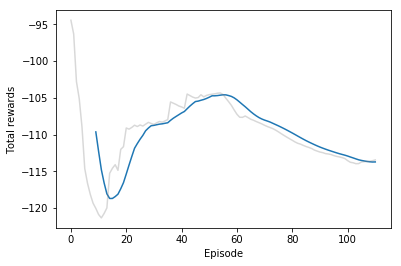

In [44]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

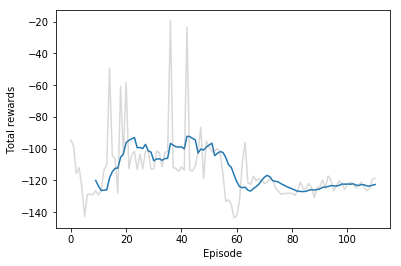

In [45]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

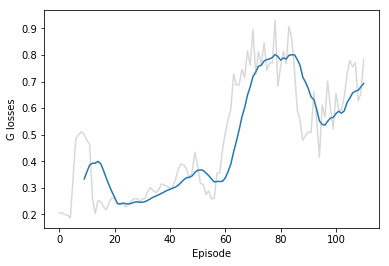

In [46]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

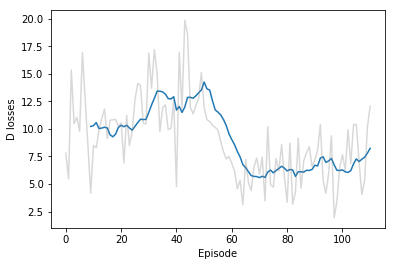

In [47]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [46]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_logits, [-1]) # For continuous action space
            #action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -130.50857430583363


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.